In [1]:
import warnings
from math import sqrt
from os.path import exists
# Initialize Wandb
import wandb
print(wandb.__version__)
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import Callback
from wandb.integration.keras import WandbMetricsLogger
from numpy import concatenate
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional, Dense, Dropout, LSTM, BatchNormalization
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Concatenate, Dense, Embedding, Input, LSTM
import os, random, tensorflow as tf

os.environ["PYTHONHASHSEED"] = "42"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


ori_data = pd.read_csv("All_Data_Reducted.csv", sep = ';')
ori_data['Timestamp'] = pd.to_datetime(ori_data["Timestamp"])
# this yields a better test set, as the last 140 samples are basically on a weekend and the energy consumption is very low, so it is not representative of the data and the metrics are inflated
ori_data = ori_data[:-120] 

0.18.5


2025-10-02 00:59:28.656021: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-02 00:59:28.664646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-02 00:59:28.673879: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-02 00:59:28.676596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-02 00:59:28.684360: I tensorflow/core/platform/cpu_feature_guar

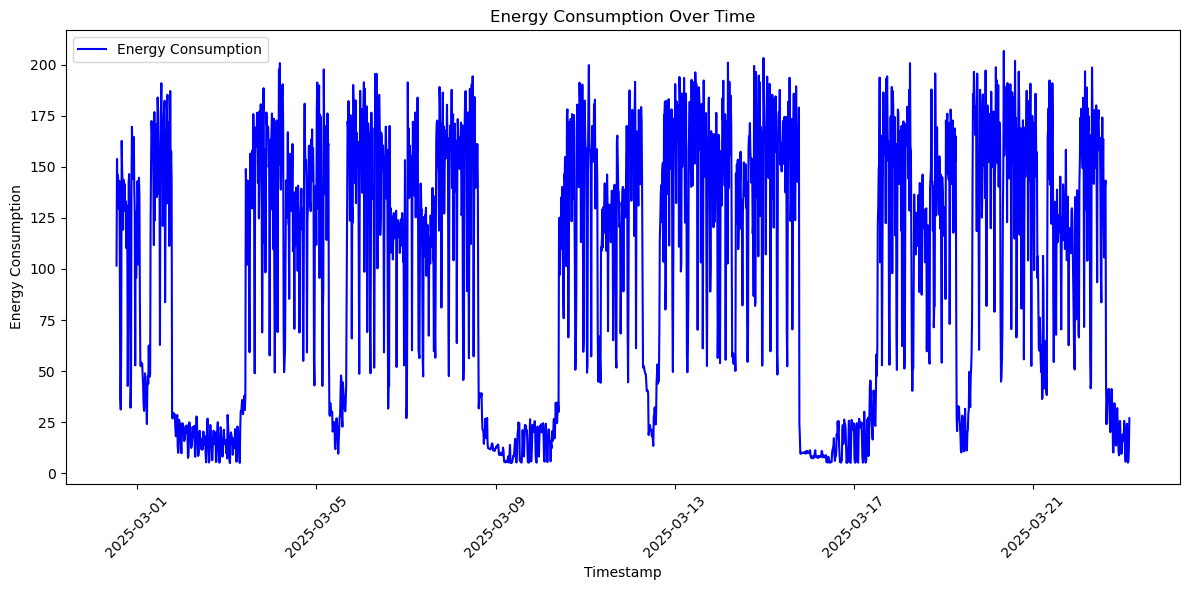

In [2]:
# plot the energy consumption
plt.figure(figsize=(12, 6))
plt.plot(ori_data['Timestamp'], ori_data['Energy'], label='Energy Consumption', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.title('Energy Consumption Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('energy_consumption_plot.png', dpi=600, format='png')  # Save the energy consumption plot
# plt.show()

# Plot the heat map of original data based on day of week and hour

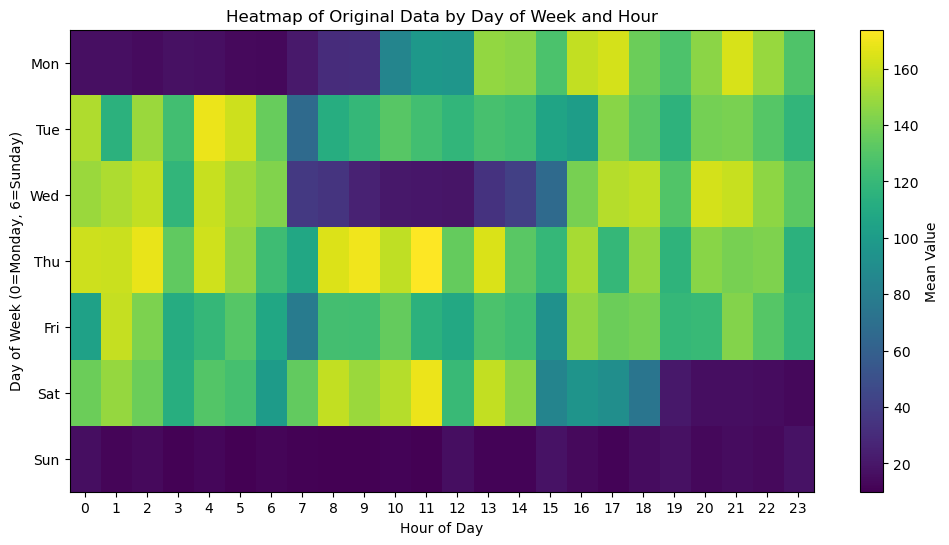

In [3]:
# Plot the heat map of original data based on day of week and hour and delete the newly added columns

def plot_heatmap(data):
    """
    Plot a heatmap of the original data based on day of week and hour.
    
    Args:
        data (pd.DataFrame): DataFrame containing the original data with 'Timestamp' column.
    """
    # Extract day of week and hour from the timestamp
    data['day_of_week'] = data['Timestamp'].dt.dayofweek
    data['hour'] = data['Timestamp'].dt.hour
    
    # Create a pivot table for the heatmap
    heatmap_data = data.pivot_table(index='day_of_week', columns='hour', values='Energy', aggfunc='mean')
    
    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    plt.title('Heatmap of Original Data by Day of Week and Hour')
    plt.imshow(heatmap_data, cmap='viridis', aspect='auto')
    plt.colorbar(label='Mean Value')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week (0=Monday, 6=Sunday)')
    plt.xticks(ticks=np.arange(24), labels=np.arange(24))
    plt.yticks(ticks=np.arange(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.show()
    
    # Drop the newly added columns
    data.drop(columns=['day_of_week', 'hour'], inplace=True)

plot_heatmap(ori_data)

# Plot the ACF (auto-correlation function) and PACF (partial auto-correlation function)

<Figure size 640x480 with 0 Axes>

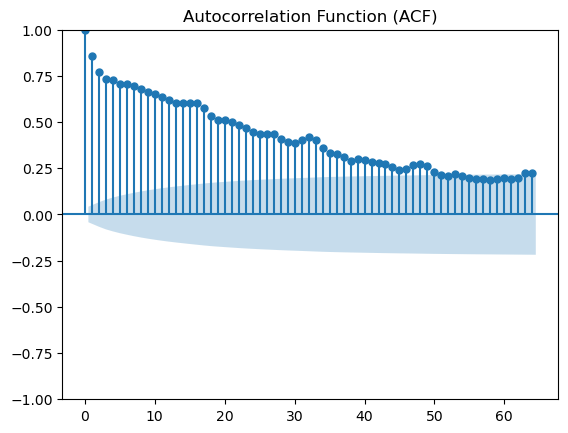

<Figure size 640x480 with 0 Axes>

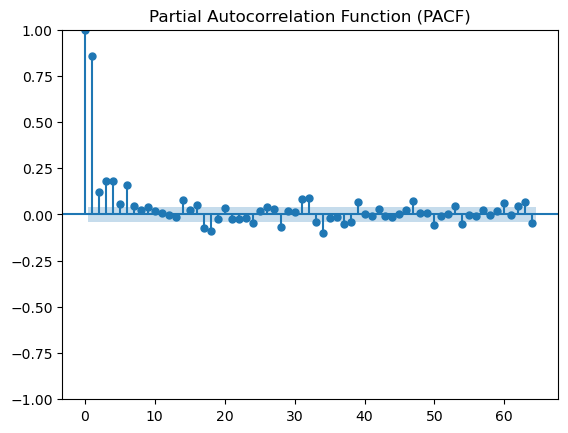

In [4]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


series = ori_data['Energy']

# 1) Autocorrelation Function
plt.figure()
plot_acf(series, lags=64)        # adjust lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.show()

# 2) Partial Autocorrelation Function
plt.figure()
plot_pacf(series, lags=64, method='ywm')  # you can also try method='ld' or 'ywmle'
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


In [5]:
def standard_scaler(data):

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def min_max_scaler(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

In [6]:
def XGBoost_model(X_train, Y_train, X_val, Y_val, X_test, Y_test, seed_val=42, pinball_loss_usage=False):
    """
    Trains XGBoost quantile regression models for 5%, 50%, 95% intervals.
    """

    quantiles = [0.05, 0.5, 0.95]
    models = {}
    predictions = {}
    X_test = X_test[48:-1]
    Y_test = Y_test[48:-1]
    if pinball_loss_usage:
        for q in quantiles:
            train_data = xgb.QuantileDMatrix(X_train, label=Y_train)
            val_data = xgb.QuantileDMatrix(X_val, label=Y_val)
            test_data = xgb.QuantileDMatrix(X_test, label=Y_test)

            params = {
                'objective': 'reg:quantileerror',
                'quantile_alpha': q,
                'eval_metric': 'mae',
                'learning_rate': 0.01,
                'max_depth': 5,
                'gamma': 1.0,
                'alpha': 0.1,
                'colsample_bytree': 0.8,
                'colsample_bynode': 0.8,
                'lambda': 0.1,
                'tree_method': 'hist',  # Required for QuantileDMatrix
                'seed': seed_val,
            }

            evals = [(train_data, 'train'), (val_data, 'eval')]
            model = xgb.train(params, train_data, num_boost_round=2000, early_stopping_rounds=100, evals=evals, verbose_eval=False)

            models[q] = model
            predictions[q] = model.predict(test_data)
        print("Shape of Y_test: ", Y_test.shape)
        return {
            'models': models,
            'predictions': predictions,
            'y_true': Y_test
        }
    else:
        train_data = xgb.DMatrix(X_train, label=Y_train)
        val_data = xgb.DMatrix(X_val, label=Y_val)
        test_data = xgb.DMatrix(X_test, label=Y_test)

        params = {
                'objective': 'reg:squarederror',
                # 'quantile_alpha': q,
                'eval_metric': 'rmse',
                'learning_rate': 0.01,
                'max_depth': 5,
                'gamma': 1.0,
                'alpha': 0.1,
                'colsample_bytree': 0.8,
                'colsample_bynode': 0.8,
                'lambda': 0.1,
                'tree_method': 'hist',  # Required for QuantileDMatrix
                'seed': seed_val,
            }

        evals = [(train_data, 'train'), (val_data, 'eval')]
        model = xgb.train(params, train_data, num_boost_round=1000, early_stopping_rounds=100, evals=evals, verbose_eval=False)
        predictions = model.predict(test_data)
        return predictions, model
def RF_model(X_train, Y_train, seed_val=42):
    from sklearn.ensemble import RandomForestRegressor
    
    model = RandomForestRegressor(n_estimators=100, random_state=seed_val)
    model.fit(X_train, Y_train)
    return model

def quantile_loss(q):
    def loss(y_true, y_pred):
        e = y_true - y_pred
        return tf.reduce_mean(tf.maximum(q * e, (q - 1) * e))
    return loss

def BiLSTM_model(X_train, q, pinball_loss_usage=False):
        """Normalize all features to zero mean and unit variance (StandardScaler) after cutting your windows.


        Constructing the Bidirectional LSTM architecture.

        Returns:
            model (keras.model) : Returns the keras model.
        """
        # lr_schedule = ExponentialDecay(0.001, decay_steps=2500, decay_rate=0.96, staircase=True)
        model = Sequential()
        # model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.2, input_shape=(X_train.shape[1], X_train.shape[2])), merge_mode='concat'))
        model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True, dropout= 0.1, recurrent_dropout=0.2,input_shape=(X_train.shape[1], X_train.shape[2]))))
        # model.add(BatchNormalization())
        model.add(Dropout(0.1))
        model.add(Bidirectional(LSTM(128, activation='tanh', dropout= 0.1, recurrent_dropout=0.2, return_sequences=False)))
        # model.add(BatchNormalization())
        model.add(Dropout(0.1))
        model.add(Dense(1, activation='linear'))
        optimizer = Adam(learning_rate= 0.004)
        if pinball_loss_usage:
            model.compile(loss=quantile_loss(q), optimizer=optimizer, metrics=['mae', 'mape', 'mse'])
        else:
            model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mape'])
        return model


def LSTM_model(X_train, q, pinball_loss_usage=False):
    # lr_schedule = ExponentialDecay(0.001, decay_steps=2500, decay_rate=0.96, staircase=True)
    model = Sequential()
    model.add(LSTM(128, activation= 'tanh', return_sequences=True, dropout= 0.1, recurrent_dropout=0.2, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation= 'tanh', recurrent_dropout=0.2, dropout= 0.1, return_sequences=False))
    # model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    # optimizer = Adam(learning_rate=lr_schedule)
    if pinball_loss_usage:
        model.compile(loss=quantile_loss(q), optimizer='Adam', metrics=['mae', 'mape', 'mse'])
    else:
        model.compile(loss='mse', optimizer='Adam', metrics=['mae', 'mape'])

    return model

In [7]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# Baseline model
def Exp_Smoothing_model(train):
    """
    Constructing the Exponential Smoothing model.

    Returns:
        model (statsmodels.tsa.holtwinters.ExponentialSmoothing) : Returns the fitted model.
    """
    # Fit the model
    model = ExponentialSmoothing(train, trend='add', seasonal='add', damped_trend=True, seasonal_periods=48).fit()
    return model



# Baseline model
data = ori_data[['Timestamp','Energy']].copy()
# Ensure 'Timestamp' is the index
data.set_index('Timestamp', inplace=True)

series = data['Energy']
n = len(series)
train_end = int(n * 0.85)
val_end = train_end + int(n * 0.075)
train = series[:train_end]
val   = series[train_end:val_end]
test  = series[val_end:]
model = Exp_Smoothing_model(train)

forecast_steps = len(test)
forecast = model.forecast(forecast_steps)
forecast.index = test.index

shape2 = len(test)
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)
n = len(test)
p = shape2
# MASE function
def mase(y_true, y_pred, y_naive):
    # y_true: Actual values
    # y_pred: Predicted values
    # y_naive: Naive model predictions (e.g., previous period's values)
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_naive = np.asarray(y_naive)
    # Compute errors
    errors = np.abs(y_true - y_pred)
    
    # Calculate MAE of naive model
    naive_errors = np.abs(y_true[1:] - y_naive[1:])
    mae_naive = np.mean(naive_errors)
    
    # Calculate MASE
    mase_value = np.mean(errors) / mae_naive
    return mase_value
# SMAPE function
def smape(y_true, y_pred):
    # y_true: Actual values
    # y_pred: Predicted values
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    # Calculate SMAPE
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    smape_value = 100 * np.mean(diff)
    return smape_value

smape_val = smape(test, forecast)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean squared error (MSE): {mean_squared_error(test, forecast)}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"SMAPE score: {smape_val}")



plt.figure(figsize=(20,12))
plt.plot(forecast, label='prediction', color="r")
plt.plot(test, label='actual', marker='.')
plt.legend()
plt.ylabel('Energy', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 86.90238902337161
Mean squared error (MSE): 11201.179068001
Root Mean Squared Error (RMSE): 105.83562286867782
R² Score: -2.309025987765505
SMAPE score: 74.49866236971027


In [8]:
def training(seed_val = 42, model_type = 'BiLSTM', n_past = 48, batch_size = 32, scaler_name = 'min-max', data_augmentation = False, fake_data_length = 400, testing_stage = False, pinball_loss_usage = False):
    # Define seed for reproducibility
    os.environ["PYTHONHASHSEED"] = str(seed_val)
    random.seed(seed_val)
    np.random.seed(seed_val)
    tf.random.set_seed(seed_val)

    data = ori_data.copy()
    n_past = n_past # the ACF shows around 50 lags, so we can use 48 -> 12 hours of lookback
    n_future = 1

    data['Timestamp'] = pd.to_datetime(data['Timestamp'])

    # Window sliding technique used for Deep Learning models
    def split_sequence(X, Y, steps, out):
        Xs, Ys = list(), list()
        for i in range(len(X)):
            end = i + steps
            outi = end + out
            if outi > len(X)-1:
                break
            seqx, seqy = X[i:end], Y[end:outi]
            Xs.append(seqx)
            Ys.append(seqy)
        return np.array(Xs), np.array(Ys)
    
    # Add time features
    time_related_features = data[['Timestamp']].copy()      
    time_related_features['hour_sin'] = np.sin(2 * np.pi * time_related_features['Timestamp'].dt.hour / 24)
    time_related_features['hour_cos'] = np.cos(2 * np.pi * time_related_features['Timestamp'].dt.hour / 24)
    time_related_features['day_of_week_sin'] = np.sin(2 * np.pi * time_related_features['Timestamp'].dt.dayofweek / 7)
    time_related_features['day_of_week_cos'] = np.cos(2 * np.pi * time_related_features['Timestamp'].dt.dayofweek / 7)

    # Categorical features
    data.set_index('Timestamp', inplace=True)
    data['dow'] = data.index.day_name().str[:3]     # e.g. "Mon","Tue",…,"Sun"
    data['hour'] = data.index.hour # 0–23
    sun_low = data['dow'] == 'Sun' # basically all day on sunday
    mon_low = (data['dow'] == 'Mon') & data['hour'].isin([0,1,2,3,4,5,6,7,8,9]) # basically from 0 to 9 on monday
    wed_low = (data['dow'] == 'Wed') & data['hour'].isin([6,7,8,9,10,11,12,13,14]) # basically from 6 to 14 for maintenance on wednesday
    sat_low = (data['dow'] == 'Sat') & data['hour'].isin([19,20,21,22,23]) # basically from 19 to 23 on saturday
    data['is_low_usage'] = sun_low | mon_low | wed_low | sat_low
    data.drop(columns=['dow', 'hour'], inplace=True)
    data.reset_index(inplace=True)
    data['is_low_usage'] = data['is_low_usage'].astype(int)
    data['is_low_usage_next'] = data['is_low_usage'].shift(-1)
    
    X, Y, X_time= data.drop(columns=['Timestamp']), data['Energy'].values, time_related_features.drop(columns=['Timestamp'])
    X = pd.concat([X, X_time], axis=1)
    timestamps = data['Timestamp']
    X_train, X_val, Y_train, Y_val = train_test_split(X.values, Y, test_size=0.20, random_state=seed_val, shuffle=False)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5, random_state=seed_val, shuffle=False)
    # Split validation data 5% and 5% in order to test in the start and then use the other 5% for the second phase after selection
    X_val1, X_val2, Y_val1, Y_val2 = train_test_split(X_val, Y_val, test_size=0.5, random_state=seed_val, shuffle=False)

    # Create aligned timestamp splits
    timestamps_train, timestamps_val, _Y_train_dummy, _Y_val_dummy = train_test_split(
        timestamps, Y, test_size=0.20, random_state=seed_val, shuffle=False
    )
    timestamps_val, timestamps_test, _Y_val_dummy, _Y_test_dummy = train_test_split(
        timestamps_val, _Y_val_dummy, test_size=0.5, random_state=seed_val, shuffle=False
    )
    timestamps_val1, timestamps_val2, _Y_val1_dummy, _Y_val2_dummy = train_test_split(
        timestamps_val, _Y_val_dummy, test_size=0.5, random_state=seed_val, shuffle=False
    )
    
    # print(X_train.shape, type(X_train), X_val1.shape, type(X_val1))
    X_train, Y_train = split_sequence(X_train, Y_train, n_past, n_future)
    # X_val1, Y_val1 = split_sequence(X_val1, Y_val1, n_past, n_future)
    X_test, Y_test = split_sequence(X_test, Y_test, n_past, n_future)
    X_val1, Y_val1 = split_sequence(X_val1, Y_val1, n_past, n_future)
    X_val2, Y_val2 = split_sequence(X_val2, Y_val2, n_past, n_future)

  
    # train-test split
    # X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=seed_val, shuffle=False)
    # X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.75, random_state=seed_val, shuffle=False)

    #-----------Now the data is Train: 80%, Val_1: 5%, Val_2: 5%, Test: 10%----------------#

    if testing_stage:
        X_train = np.concatenate([X_train, X_val1], axis=0) # concatenate validation set to training set
        Y_train = np.concatenate([Y_train, Y_val1], axis=0)
        timestamps = timestamps_test  # concatenate timestamps for training set
        X_val = X_val2  # use the second validation set for validation
        Y_val = Y_val2  # use the second validation set for validation
    else:
        X_val = X_val1
        Y_val = Y_val1
        timestamps = timestamps_val1

    # separate the lagged values, numerical and time features, time features are the last 4 features in the X, lagged value features is the last before the time features
    X_numerical_train = X_train[:, :, :-7]    # all except last 7 (numerical features)
    X_lagged_train    = X_train[:, :, -7:-6]  # just the 7th-from-last (lagged feature)
    X_cat_train       = X_train[:, :, -6:-4]  # just the 6th-from-last (categorical feature)
    X_time_train      = X_train[:, :, -4:]    # last 4 are time features (time-related features)

    # VAL
    X_numerical_val = X_val[:, :, :-7]
    X_lagged_val    = X_val[:, :, -7:-6]
    X_cat_val       = X_val[:, :, -6:-4]
    X_time_val      = X_val[:, :, -4:]

    # TEST
    X_numerical_test = X_test[:, :, :-7]
    X_lagged_test    = X_test[:, :, -7:-6]
    X_cat_test       = X_test[:, :, -6:-4]
    X_time_test      = X_test[:, :, -4:]


    # broadcast ONLY is_low_usage_next across timesteps, in order to use it as a feature (low_usage from t+1 timestep) and because keep a constant value through the sequence
    # TRAIN
    X_cat_train[:, :, 1] = X_cat_train[:, -1, 1][:, None]
    # VAL
    X_cat_val[:,   :, 1] = X_cat_val[:,   -1, 1][:, None]
    # TEST
    X_cat_test[:,  :, 1] = X_cat_test[:,  -1, 1][:, None]


    if data_augmentation:
        fake_data = np.load("ddpm_fake_energy_raw.npy")
        fake_data = fake_data[:fake_data_length]
        _, seq_len, F = fake_data.shape
        X_fake = fake_data[:, :seq_len-1, :]
        Y_fake = fake_data[:, seq_len-1, F-1]
        Y_fake = Y_fake.reshape(-1, 1)
        X_fake_numerical_train = X_fake[:, :, :-7] 
        X_fake_cat_train= X_fake[:, :, -7:-5] 
        X_fake_lagged_train = X_fake[:, :, -1:] 
        X_fake_time_train = X_fake[:, :, -5:-1] 

    if scaler_name == 'min-max':

        N, seq_len, F = X_numerical_train.shape
        X_numerical_train, scaler = min_max_scaler(X_numerical_train.reshape(-1, X_numerical_train.shape[-1]))
        X_numerical_train = X_numerical_train.reshape(N, seq_len, F)
        X_numerical_val = scaler.transform(X_numerical_val.reshape(-1, X_numerical_val.shape[-1]))
        X_numerical_val = X_numerical_val.reshape(X_val.shape[0], seq_len, F)
        X_numerical_test = scaler.transform(X_numerical_test.reshape(-1, X_numerical_test.shape[-1]))
        X_numerical_test = X_numerical_test.reshape(X_test.shape[0], seq_len, F)
            
        Y_train, scaler_target = min_max_scaler(Y_train)
        Y_val = scaler_target.transform(Y_val)
        Y_test = scaler_target.transform(Y_test)
        X_lagged_train = scaler_target.transform(X_lagged_train.reshape(-1, X_lagged_train.shape[-1]))
        X_lagged_train = X_lagged_train.reshape(N, seq_len, 1)
        X_lagged_val = scaler_target.transform(X_lagged_val.reshape(-1, X_lagged_val.shape[-1]))
        X_lagged_val = X_lagged_val.reshape(X_val.shape[0], seq_len, 1)
        X_lagged_test = scaler_target.transform(X_lagged_test.reshape(-1, X_lagged_test.shape[-1]))
        X_lagged_test = X_lagged_test.reshape(X_test.shape[0], seq_len, 1)


        #fake data augmentation
        if data_augmentation:
            N, seq_len, F = X_fake_numerical_train.shape

            X_fake_numerical_train = scaler.transform(X_fake_numerical_train.reshape(-1, X_fake_numerical_train.shape[-1]))
            X_fake_numerical_train = X_fake_numerical_train.reshape(N, seq_len, F)
            X_fake_lagged_train = scaler_target.transform(X_fake_lagged_train.reshape(-1, X_fake_lagged_train.shape[-1]))
            X_fake_lagged_train = X_fake_lagged_train.reshape(N, seq_len, 1)
            Y_fake = scaler_target.transform(Y_fake)

    elif scaler_name == 'standard':

        N, seq_len, F = X_numerical_train.shape
        X_numerical_train, scaler = standard_scaler(X_numerical_train.reshape(-1, X_numerical_train.shape[-1]))
        X_numerical_train = X_numerical_train.reshape(N, seq_len, F)
        X_numerical_val = scaler.transform(X_numerical_val.reshape(-1, X_numerical_val.shape[-1]))
        X_numerical_val = X_numerical_val.reshape(X_val.shape[0], seq_len, F)
        X_numerical_test = scaler.transform(X_numerical_test.reshape(-1, X_numerical_test.shape[-1]))
        X_numerical_test = X_numerical_test.reshape(X_test.shape[0], seq_len, F)

        Y_train, scaler_target = standard_scaler(Y_train)
        Y_val = scaler_target.transform(Y_val)
        Y_test = scaler_target.transform(Y_test)
        X_lagged_train = scaler_target.transform(X_lagged_train.reshape(-1, X_lagged_train.shape[-1]))
        X_lagged_train = X_lagged_train.reshape(N, seq_len, 1)
        X_lagged_val = scaler_target.transform(X_lagged_val.reshape(-1, X_lagged_val.shape[-1]))
        X_lagged_val = X_lagged_val.reshape(X_val.shape[0], seq_len, 1)
        X_lagged_test = scaler_target.transform(X_lagged_test.reshape(-1, X_lagged_test.shape[-1]))
        X_lagged_test = X_lagged_test.reshape(X_test.shape[0], seq_len, 1)


        #fake data augmentation
        if data_augmentation:
            N, seq_len, F = X_fake_numerical_train.shape

            X_fake_numerical_train = scaler.transform(X_fake_numerical_train.reshape(-1, X_fake_numerical_train.shape[-1]))
            X_fake_numerical_train = X_fake_numerical_train.reshape(N, seq_len, F)
            X_fake_lagged_train = scaler_target.transform(X_fake_lagged_train.reshape(-1, X_fake_lagged_train.shape[-1]))
            X_fake_lagged_train = X_fake_lagged_train.reshape(N, seq_len, 1)
            Y_fake = scaler_target.transform(Y_fake)

    X_train = np.concatenate([X_numerical_train, X_cat_train, X_time_train, X_lagged_train], axis=2)    
    X_val = np.concatenate([X_numerical_val, X_cat_val, X_time_val, X_lagged_val], axis=2)
    X_test = np.concatenate([X_numerical_test, X_cat_test, X_time_test, X_lagged_test], axis=2)
    # X_train = X_numerical_train
    # X_val = X_numerical_val
    # X_test = X_numerical_test

    if data_augmentation:
        X_fake = np.concatenate([X_fake_numerical_train, X_fake_cat_train, X_fake_time_train, X_fake_lagged_train], axis=2)
        X_train, Y_train = np.concatenate([X_train, X_fake], axis=0), np.concatenate([Y_train, Y_fake], axis=0)


    print("Size of training data is: ", X_train.shape)
    quantiles = [0.05, 0.5, 0.95]
    models = {}
    histories = {}

    early_stop = EarlyStopping(
                monitor='val_loss',     # or 'val_mae' depending on preference
                patience=15,             # stop after 15 epochs with no improvement
                restore_best_weights=True # rollback to the best model weights
    )
    if pinball_loss_usage:
        for q in quantiles:
            print(f"Training {model_type} for quantile {q}...")

            if model_type == 'BiLSTM':
                model = BiLSTM_model(X_train, q, pinball_loss_usage)
            elif model_type == 'LSTM':
                model = LSTM_model(X_train, q, pinball_loss_usage)

            history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=500, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[early_stop, WandbMetricsLogger()])
            models[q] = model
            histories[q] = history
    else:
        print(f"Training {model_type}...")

        if model_type == 'BiLSTM':
            model = BiLSTM_model(X_train, 0, pinball_loss_usage)
        elif model_type == 'LSTM':
            model = LSTM_model(X_train, 0, pinball_loss_usage)
        
        model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=500, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[early_stop, WandbMetricsLogger()])
        
    # print(X_val.shape)
    predictions = {}
    if pinball_loss_usage:
        if testing_stage:
            for q in quantiles:
                predictions[q] = models[q].predict(X_test)
        else:
            for q in quantiles:
                predictions[q] = models[q].predict(X_val)
    else:
        if testing_stage:
            predictions = model.predict(X_test)
        else:
            predictions = model.predict(X_val)

    # print(X_val.shape)

    if pinball_loss_usage:
        y_pred_q05 = predictions[0.05]
        y_pred_q50 = predictions[0.5]
        y_pred_q95 = predictions[0.95]

        predictions = scaler_target.inverse_transform(y_pred_q50.reshape(-1, 1))
        y_pred_q05 = scaler_target.inverse_transform(y_pred_q05.reshape(-1, 1))
        y_pred_q95 = scaler_target.inverse_transform(y_pred_q95.reshape(-1, 1))
    else:
        predictions = scaler_target.inverse_transform(predictions.reshape(-1, 1))
        
    # predictions = model.predict(X_val)
    if not testing_stage:
        Y_test = Y_val

    Y_test = scaler_target.inverse_transform(Y_test)


    # Save predictions to a local file
    filename = f"model_name_{model_type}_predictions_seed_{seed_val}_augmentation_{batch_size}_scaler_{scaler_name}_DA_{data_augmentation}_pinball_{pinball_loss_usage}.npz"
    np.savez(filename, predictions=predictions.flatten(), ground_truth=Y_test.flatten())

    # Create an artifact
    artifact = wandb.Artifact(
        name=f"model_name_{model_type}_predictions_seed_{seed_val}_augmentation_{batch_size}_scaler_{scaler_name}_DA_{data_augmentation}_pinball_{pinball_loss_usage}",
        type="predictions",
        description="Predictions and ground truth for one run",
        metadata={
            "seed": seed_val,
            "model": model_type,
            "scaler": scaler_name,
            "batch_size": batch_size,
            "data_aug": data_augmentation,
            "fake_data_len": fake_data_length
        }
    )

    # Add file and log it
    artifact.add_file(filename)
    wandb.log_artifact(artifact)

    # Optional: Clean up local file
    # os.remove(filename)
    


    #------------QUANTILE METRICS-----------------#
    if pinball_loss_usage:
    # Pinball loss for quantiles
        def pinball_loss(y_true, y_pred, q):
            """
            Pinball loss for quantile q.
            y_true, y_pred must be arrays of same shape.
            """
            e = y_true - y_pred
            return np.mean(np.maximum(q*e, (q-1)*e))
        
        loss_q05 = pinball_loss(Y_test, y_pred_q05, 0.05)
        loss_q50 = pinball_loss(Y_test, y_pred_q50, 0.5)
        loss_q95 = pinball_loss(Y_test, y_pred_q95, 0.95)

        # Coverage (Calibration of prediction intervals)
        def interval_coverage(y_true, y_lower, y_upper, nominal=0.90):
            """
            Computes empirical coverage of [y_lower, y_upper].
            """
            inside = (y_true >= y_lower) & (y_true <= y_upper)
            empirical = np.mean(inside)
            return empirical, empirical - nominal
        
        coverage_90, error_90 = interval_coverage(Y_test, y_pred_q05, y_pred_q95, nominal=0.90)


        # Interval Width (Sharpness)
        def interval_width(y_lower, y_upper):
            return np.mean(y_upper - y_lower)
        

        sharpness_90 = interval_width(y_pred_q05, y_pred_q95)


        wandb.log({
        "Pinball_0.05": loss_q05,
        "Pinball_0.50": loss_q50,
        "Pinball_0.95": loss_q95,
        "Coverage_0.90": coverage_90,
        "Coverage_Error_0.90": error_90,
        "Sharpness_0.90": sharpness_90
        })

    #------------QUANTILE METRICS END-----------------#

    #------------Point forecast metrics-----------------#
    mae = mean_absolute_error(Y_test, predictions)
    rmse = np.sqrt(mean_squared_error(Y_test, predictions))
    r2 = r2_score(Y_test, predictions)
    n = len(Y_test)
    # p = shape2
    # MASE function
    def mase(y_true, y_pred, y_naive):
        # y_true: Actual values
        # y_pred: Predicted values
        # y_naive: Naive model predictions (e.g., previous period's values)
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        y_naive = np.asarray(y_naive)
        # Compute errors
        errors = np.abs(y_true - y_pred)
        
        # Calculate MAE of naive model
        naive_errors = np.abs(y_true[1:] - y_naive[1:])
        mae_naive = np.mean(naive_errors)
        
        # Calculate MASE
        mase_value = np.mean(errors) / mae_naive
        return mase_value
    # SMAPE function
    def smape(y_true, y_pred):
        # y_true: Actual values
        # y_pred: Predicted values
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        # Calculate SMAPE
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
        diff = np.abs(y_true - y_pred) / denominator
        smape_value = 100 * np.mean(diff)
        return smape_value
    smape_val = smape(Y_test, predictions)
    y_naive = np.roll(Y_test, 1)
    mase_val = mase(Y_test, predictions, y_naive)
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean squared error (MSE): {mean_squared_error(Y_test, predictions)}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'R² Score: {r2}')
    print(f"SMAPE score: {smape_val}")
    print(f"MASE score: {mase_val}")

    print(predictions.shape, Y_test.shape)
    if pinball_loss_usage:
        # pinball loss plot
        timestamps = timestamps[48:-1]
        print(timestamps.shape)
        plt.figure(figsize=(14, 6))
        plt.plot(timestamps, Y_test.squeeze(), label="Ground Truth", color='black', linewidth=2)
        plt.plot(timestamps, predictions.squeeze(), label="Median Prediction (0.5)", color='#0072B2', linewidth=2)
        plt.fill_between(
            timestamps, y_pred_q05.squeeze(), y_pred_q95.squeeze(),
            color='#0072B2', alpha=0.2, label="90% Confidence Interval (0.05–0.95)"
        )

        # Custom x-axis formatter → weekday + month-day + hour:00
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m-%d %H:%M'))

        plt.grid(alpha=0.3)
        plt.title(f"{model_type} Quantile Regression - Confidence Interval")
        plt.xlabel("Time")
        plt.ylabel("Energy")
        plt.legend(fontsize=12)
        plt.tight_layout()
        wandb.log({"train vs val_predictions": wandb.Image(plt)})
        plt.close()
    else: # mse loss plot
        timestamps = timestamps[48:-1]
        print(timestamps.shape)
        plt.figure(figsize=(14, 6))
        plt.plot(timestamps, Y_test.squeeze(), label="Ground Truth", color='black', linewidth=2)
        plt.plot(timestamps, predictions.squeeze(), label="Prediction", color='#0072B2', linewidth=2)

        # Custom x-axis formatter → weekday + month-day + hour:00
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m-%d %H:%M'))

        plt.grid(alpha=0.3)
        plt.title(f"{model_type} - MSE Regression")
        plt.xlabel("Time")
        plt.ylabel("Energy")
        plt.legend(fontsize=12)
        plt.tight_layout()
        wandb.log({"train vs val_predictions": wandb.Image(plt)})
        plt.close()

    wandb.log({
    "val_MAE": mae,
    "val_MSE": mean_squared_error(Y_test, predictions),
    "val_RMSE": rmse,
    "val_R2": r2,
    "val_SMAPE": smape_val,
    "val_MASE": mase_val
    })

sweep_config = {
    'method': 'grid',
    'parameters': {
        'model_name': {
            'values': ['BiLSTM']
            # 'values': ['BiLSTM', 'LSTM']
        },
        'scaler_name': {
            'values': ['standard']
            
            # 'values': ['standard', 'min-max']
        },
        'batch_size': {
            'values': [32, 16]
            # 'values': [32]
        },
        'data_augmentation': {
            'values': [True]
        },
        'seed': {
            'values': [42, 4242, 777, 2021, 1234]
            # 'values' : [2021, 1234, 777]
        },
        'fake_data_length': {
            # 'values': [200, 400, 800, 1200, 1600]
            'values': [200, 400, 800, 1200, 1600]
        },
        'pinball_loss_usage': {
            'values': [False]
        },
        'testing_stage': {
            'values': [True]
        }
    }
}

project_base = f"HALCOR-ENERGY-TIMESERIES-FORECASTING-MSE-TESTING"
sweep_id = wandb.sweep(sweep=sweep_config, project=project_base)


def sweep_train():
    run = wandb.init()

    # Extract config values
    model = run.config.model_name
    scaler = run.config.scaler_name
    batch_size = run.config.batch_size

    run.name = f"{model}-{scaler}-bs{batch_size}-aug{run.config.data_augmentation}--seed{run.config.seed}--fake_data_length{run.config.fake_data_length}---pinball_loss_usage{run.config.pinball_loss_usage}---testing_stage{run.config.testing_stage}"

    # Run your training pipeline
    training(
        seed_val=run.config.seed,
        model_type=model,
        batch_size=batch_size,
        scaler_name=scaler,
        data_augmentation=run.config.data_augmentation,
        fake_data_length=run.config.fake_data_length,
        testing_stage=run.config.testing_stage,
        pinball_loss_usage=run.config.pinball_loss_usage
    )

wandb.agent(sweep_id, function=sweep_train)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: a1oysoa9
Sweep URL: https://wandb.ai/synthetic-data-gan/HALCOR-ENERGY-TIMESERIES-FORECASTING-MSE-TESTING/sweeps/a1oysoa9


wandb: Agent Starting Run: bln0iv6k with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True
wandb: Currently logged in as: steliobompai (synthetic-data-gan). Use `wandb login --relogin` to force relogin


Size of training data is:  (1946, 48, 57)
Training BiLSTM...
Epoch 1/500


I0000 00:00:1759355999.225975   25342 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1759355999.252444   25342 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1759355999.252744   25342 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1759355999.253618   25342 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.4559 - mae: 0.4900 - mape: 94.0415 - val_loss: 0.0913 - val_mae: 0.2488 - val_mape: 43.2322
Epoch 2/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0767 - mae: 0.2091 - mape: 44.5820 - val_loss: 0.0654 - val_mae: 0.2040 - val_mape: 36.0789
Epoch 3/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0523 - mae: 0.1758 - mape: 36.9013 - val_loss: 0.0558 - val_mae: 0.1925 - val_mape: 30.8136
Epoch 4/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0430 - mae: 0.1618 - mape: 34.8733 - val_loss: 0.0590 - val_mae: 0.1892 - val_mape: 27.7353
Epoch 5/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0374 - mae: 0.1495 - mape: 29.4739 - val_loss: 0.0516 - val_mae: 0.1738 - val_mape: 26.7861
Epoch 6/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0354 - mae: 0.1458 - mape: 31.4898 - val_loss: 0.0547 - val_mae: 0.1801 - val_mape: 27.7252
Epoch 7/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0325 - mae: 0.1408 - mape:

wandb: Agent Starting Run: 04pxwaau with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.4138 - mae: 0.4757 - mape: 108.1405 - val_loss: 0.1352 - val_mae: 0.2763 - val_mape: 51.4826
Epoch 2/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0816 - mae: 0.2118 - mape: 51.0619 - val_loss: 0.1148 - val_mae: 0.2806 - val_mape: 49.4347
Epoch 3/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0581 - mae: 0.1826 - mape: 41.0453 - val_loss: 0.0862 - val_mae: 0.2389 - val_mape: 44.1374
Epoch 4/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0498 - mae: 0.1696 - mape: 41.9571 - val_loss: 0.0793 - val_mae: 0.2356 - val_mape: 40.3159
Epoch 5/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0406 - mae: 0.1556 - mape: 37.3515 - val_loss: 0.0610 - val_mae: 0.2032 - val_mape: 35.2238
Epoch 6/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0359 - mae: 0.1481 - mape: 38.1151 - val_loss: 0.0597 - val_mae: 0.1876 - val_mape: 31.8407
Epoch 7/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0358 - mae: 0.1467 - mape

wandb: Agent Starting Run: 0tzu65ge with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.5749 - mae: 0.5369 - mape: 95.2564 - val_loss: 0.0990 - val_mae: 0.2498 - val_mape: 38.5330
Epoch 2/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0845 - mae: 0.2201 - mape: 45.4255 - val_loss: 0.0646 - val_mae: 0.1976 - val_mape: 29.5501
Epoch 3/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0621 - mae: 0.1925 - mape: 42.3875 - val_loss: 0.0573 - val_mae: 0.1927 - val_mape: 32.5631
Epoch 4/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0499 - mae: 0.1723 - mape: 35.8554 - val_loss: 0.0528 - val_mae: 0.1728 - val_mape: 28.5204
Epoch 5/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0424 - mae: 0.1580 - mape: 35.4616 - val_loss: 0.0457 - val_mae: 0.1629 - val_mape: 26.0466
Epoch 6/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0421 - mae: 0.1560 - mape: 31.1010 - val_loss: 0.0512 - val_mae: 0.1809 - val_mape: 28.9627
Epoch 7/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0356 - mae: 0.1482 - mape:

wandb: Agent Starting Run: w2piqeec with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.4298 - mae: 0.4682 - mape: 73.7940 - val_loss: 0.1056 - val_mae: 0.2565 - val_mape: 43.4900
Epoch 2/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0872 - mae: 0.2274 - mape: 42.5704 - val_loss: 0.0582 - val_mae: 0.1903 - val_mape: 33.1955
Epoch 3/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0554 - mae: 0.1799 - mape: 36.1370 - val_loss: 0.0585 - val_mae: 0.1855 - val_mape: 33.8445
Epoch 4/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0473 - mae: 0.1653 - mape: 34.4867 - val_loss: 0.0525 - val_mae: 0.1766 - val_mape: 30.5064
Epoch 5/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0422 - mae: 0.1585 - mape: 32.7759 - val_loss: 0.0515 - val_mae: 0.1759 - val_mape: 29.5473
Epoch 6/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0364 - mae: 0.1458 - mape: 29.7398 - val_loss: 0.0546 - val_mae: 0.1823 - val_mape: 31.1829
Epoch 7/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0335 - mae: 0.1397 - mape:

wandb: Agent Starting Run: ertmpbgm with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.4737 - mae: 0.5098 - mape: 87.6676 - val_loss: 0.1060 - val_mae: 0.2684 - val_mape: 45.8112
Epoch 2/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0755 - mae: 0.2088 - mape: 42.8714 - val_loss: 0.0755 - val_mae: 0.2196 - val_mape: 37.6200
Epoch 3/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0533 - mae: 0.1776 - mape: 37.2853 - val_loss: 0.0622 - val_mae: 0.1791 - val_mape: 27.9698
Epoch 4/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0501 - mae: 0.1706 - mape: 37.4641 - val_loss: 0.0572 - val_mae: 0.1841 - val_mape: 29.8030
Epoch 5/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0414 - mae: 0.1565 - mape: 32.6737 - val_loss: 0.0541 - val_mae: 0.1746 - val_mape: 27.2356
Epoch 6/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0382 - mae: 0.1488 - mape: 31.6799 - val_loss: 0.0704 - val_mae: 0.2047 - val_mape: 31.5668
Epoch 7/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0364 - mae: 0.1487 - mape:

wandb: Agent Starting Run: yypuflrx with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.4084 - mae: 0.4746 - mape: 144.7200 - val_loss: 0.1681 - val_mae: 0.3382 - val_mape: 60.0956
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0753 - mae: 0.2096 - mape: 58.2826 - val_loss: 0.0693 - val_mae: 0.2019 - val_mape: 38.2506
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0521 - mae: 0.1735 - mape: 41.3246 - val_loss: 0.0645 - val_mae: 0.1956 - val_mape: 36.5721
Epoch 4/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0460 - mae: 0.1646 - mape: 37.6773 - val_loss: 0.0659 - val_mae: 0.1975 - val_mape: 35.3507
Epoch 5/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0375 - mae: 0.1479 - mape: 34.1153 - val_loss: 0.0555 - val_mae: 0.1760 - val_mape: 30.9743
Epoch 6/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0350 - mae: 0.1456 - mape: 39.2102 - val_loss: 0.0598 - val_mae: 0.1873 - val_mape: 32.9559
Epoch 7/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0327 - mae: 0.1392 - mape

wandb: Agent Starting Run: n40qb46t with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.4148 - mae: 0.4729 - mape: 105.5739 - val_loss: 0.0999 - val_mae: 0.2595 - val_mape: 35.6319
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0800 - mae: 0.2171 - mape: 50.3608 - val_loss: 0.0630 - val_mae: 0.2032 - val_mape: 34.5872
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0555 - mae: 0.1794 - mape: 44.8459 - val_loss: 0.0578 - val_mae: 0.1895 - val_mape: 29.8135
Epoch 4/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0488 - mae: 0.1650 - mape: 40.3912 - val_loss: 0.0482 - val_mae: 0.1751 - val_mape: 29.4448
Epoch 5/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0415 - mae: 0.1564 - mape: 35.2584 - val_loss: 0.0537 - val_mae: 0.1866 - val_mape: 31.2913
Epoch 6/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0387 - mae: 0.1497 - mape: 38.4247 - val_loss: 0.0621 - val_mae: 0.2008 - val_mape: 34.6603
Epoch 7/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0367 - mae: 0.1477 - mape

wandb: Agent Starting Run: twf8cv8o with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.4480 - mae: 0.4815 - mape: 89.7412 - val_loss: 0.1131 - val_mae: 0.2686 - val_mape: 47.2098
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0756 - mae: 0.2114 - mape: 39.5247 - val_loss: 0.1176 - val_mae: 0.2829 - val_mape: 48.2060
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0540 - mae: 0.1771 - mape: 34.6519 - val_loss: 0.0608 - val_mae: 0.1920 - val_mape: 33.7277
Epoch 4/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0489 - mae: 0.1687 - mape: 32.9746 - val_loss: 0.0907 - val_mae: 0.2502 - val_mape: 40.3702
Epoch 5/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0404 - mae: 0.1553 - mape: 30.3486 - val_loss: 0.0556 - val_mae: 0.1807 - val_mape: 30.1843
Epoch 6/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0358 - mae: 0.1440 - mape: 32.6497 - val_loss: 0.0570 - val_mae: 0.1825 - val_mape: 30.7997
Epoch 7/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0330 - mae: 0.1398 - mape:

wandb: Agent Starting Run: rz0j9v8n with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.4430 - mae: 0.4832 - mape: 92.6497 - val_loss: 0.1004 - val_mae: 0.2538 - val_mape: 45.3785
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0801 - mae: 0.2151 - mape: 49.4739 - val_loss: 0.0772 - val_mae: 0.2160 - val_mape: 36.9095
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0584 - mae: 0.1814 - mape: 40.7057 - val_loss: 0.0705 - val_mae: 0.2020 - val_mape: 34.6474
Epoch 4/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0461 - mae: 0.1630 - mape: 33.4957 - val_loss: 0.0499 - val_mae: 0.1641 - val_mape: 28.0009
Epoch 5/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0405 - mae: 0.1532 - mape: 37.8513 - val_loss: 0.0589 - val_mae: 0.1885 - val_mape: 31.9775
Epoch 6/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0356 - mae: 0.1458 - mape: 36.3908 - val_loss: 0.0549 - val_mae: 0.1712 - val_mape: 27.7389
Epoch 7/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0334 - mae: 0.1397 - mape:

wandb: Agent Starting Run: pq4x92rw with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.4409 - mae: 0.4903 - mape: 81.3408 - val_loss: 0.0949 - val_mae: 0.2450 - val_mape: 40.5594
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0950 - mae: 0.2374 - mape: 45.2980 - val_loss: 0.0672 - val_mae: 0.2005 - val_mape: 33.2781
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0627 - mae: 0.1880 - mape: 38.2285 - val_loss: 0.0698 - val_mae: 0.1995 - val_mape: 32.1326
Epoch 4/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0546 - mae: 0.1736 - mape: 36.4378 - val_loss: 0.0646 - val_mae: 0.1820 - val_mape: 30.8118
Epoch 5/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0418 - mae: 0.1575 - mape: 29.8487 - val_loss: 0.0702 - val_mae: 0.2008 - val_mape: 29.5686
Epoch 6/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0365 - mae: 0.1462 - mape: 27.8552 - val_loss: 0.0626 - val_mae: 0.1829 - val_mape: 27.2974
Epoch 7/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0338 - mae: 0.1448 - mape:

wandb: Agent Starting Run: rwwvk50e with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.3248 - mae: 0.4227 - mape: 80.6094 - val_loss: 0.0702 - val_mae: 0.2124 - val_mape: 36.1068
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0618 - mae: 0.1911 - mape: 40.8931 - val_loss: 0.0580 - val_mae: 0.1840 - val_mape: 34.5511
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0528 - mae: 0.1728 - mape: 35.7746 - val_loss: 0.0505 - val_mae: 0.1761 - val_mape: 29.0712
Epoch 4/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0469 - mae: 0.1648 - mape: 35.5852 - val_loss: 0.0453 - val_mae: 0.1645 - val_mape: 25.9313
Epoch 5/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0435 - mae: 0.1551 - mape: 34.8596 - val_loss: 0.0467 - val_mae: 0.1706 - val_mape: 27.7865
Epoch 6/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0377 - mae: 0.1453 - mape: 30.7971 - val_loss: 0.0417 - val_mae: 0.1598 - val_mape: 26.4559
Epoch 7/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0323 - mae: 0.1390 - mape:

wandb: Agent Starting Run: v5f5mc6v with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.3586 - mae: 0.4293 - mape: 95.5187 - val_loss: 0.1670 - val_mae: 0.3459 - val_mape: 39.8259
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0725 - mae: 0.2041 - mape: 48.5079 - val_loss: 0.0585 - val_mae: 0.1882 - val_mape: 32.1508
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0497 - mae: 0.1713 - mape: 41.2193 - val_loss: 0.0600 - val_mae: 0.1977 - val_mape: 33.6977
Epoch 4/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0415 - mae: 0.1577 - mape: 39.4115 - val_loss: 0.0565 - val_mae: 0.1928 - val_mape: 31.6651
Epoch 5/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0373 - mae: 0.1493 - mape: 34.7603 - val_loss: 0.0606 - val_mae: 0.1902 - val_mape: 32.0051
Epoch 6/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0331 - mae: 0.1394 - mape: 33.4378 - val_loss: 0.0524 - val_mae: 0.1805 - val_mape: 26.0252
Epoch 7/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0326 - mae: 0.1388 - mape:

wandb: Agent Starting Run: 8sk0qpxq with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.4758 - mae: 0.4864 - mape: 102.6337 - val_loss: 0.0837 - val_mae: 0.2318 - val_mape: 40.8168
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0633 - mae: 0.1917 - mape: 47.7345 - val_loss: 0.0504 - val_mae: 0.1725 - val_mape: 27.0698
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0481 - mae: 0.1687 - mape: 36.0464 - val_loss: 0.0464 - val_mae: 0.1694 - val_mape: 28.5328
Epoch 4/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0411 - mae: 0.1555 - mape: 39.3235 - val_loss: 0.0448 - val_mae: 0.1669 - val_mape: 26.0753
Epoch 5/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0378 - mae: 0.1471 - mape: 32.5292 - val_loss: 0.0382 - val_mae: 0.1497 - val_mape: 23.4814
Epoch 6/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0334 - mae: 0.1429 - mape: 30.9853 - val_loss: 0.0481 - val_mae: 0.1658 - val_mape: 25.3269
Epoch 7/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0310 - mae: 0.1345 - mape

wandb: Agent Starting Run: 7w4kp67m with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.3478 - mae: 0.4324 - mape: 88.4632 - val_loss: 0.0730 - val_mae: 0.2114 - val_mape: 31.8830
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0625 - mae: 0.1898 - mape: 45.5413 - val_loss: 0.0478 - val_mae: 0.1725 - val_mape: 28.6165
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0508 - mae: 0.1683 - mape: 43.0614 - val_loss: 0.0419 - val_mae: 0.1512 - val_mape: 25.2100
Epoch 4/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0397 - mae: 0.1528 - mape: 41.2916 - val_loss: 0.0388 - val_mae: 0.1537 - val_mape: 24.9975
Epoch 5/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0372 - mae: 0.1486 - mape: 45.0449 - val_loss: 0.0390 - val_mae: 0.1486 - val_mape: 23.3725
Epoch 6/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0369 - mae: 0.1470 - mape: 43.8468 - val_loss: 0.0375 - val_mae: 0.1441 - val_mape: 21.9711
Epoch 7/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0308 - mae: 0.1360 - mape:

wandb: Agent Starting Run: m4d3dakl with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.3709 - mae: 0.4492 - mape: 97.6143 - val_loss: 0.0757 - val_mae: 0.2227 - val_mape: 33.6945
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0603 - mae: 0.1854 - mape: 42.1311 - val_loss: 0.0453 - val_mae: 0.1617 - val_mape: 27.9311
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0479 - mae: 0.1670 - mape: 39.6306 - val_loss: 0.0420 - val_mae: 0.1562 - val_mape: 26.6397
Epoch 4/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0419 - mae: 0.1569 - mape: 34.8963 - val_loss: 0.0354 - val_mae: 0.1441 - val_mape: 23.9674
Epoch 5/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0366 - mae: 0.1449 - mape: 30.6042 - val_loss: 0.0398 - val_mae: 0.1523 - val_mape: 24.7123
Epoch 6/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0336 - mae: 0.1403 - mape: 32.5256 - val_loss: 0.0367 - val_mae: 0.1496 - val_mape: 23.4630
Epoch 7/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0296 - mae: 0.1344 - mape:

wandb: Agent Starting Run: 7dw2zmsv with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.3577 - mae: 0.4316 - mape: 77.1862 - val_loss: 0.0830 - val_mae: 0.2333 - val_mape: 32.8588
Epoch 2/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0772 - mae: 0.2139 - mape: 41.7531 - val_loss: 0.0582 - val_mae: 0.1992 - val_mape: 33.4181
Epoch 3/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0457 - mae: 0.1626 - mape: 36.4731 - val_loss: 0.0477 - val_mae: 0.1781 - val_mape: 27.5023
Epoch 4/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0420 - mae: 0.1593 - mape: 33.1374 - val_loss: 0.0465 - val_mae: 0.1697 - val_mape: 27.9517
Epoch 5/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0326 - mae: 0.1368 - mape: 30.7724 - val_loss: 0.0396 - val_mae: 0.1562 - val_mape: 23.3388
Epoch 6/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0296 - mae: 0.1326 - mape: 26.8296 - val_loss: 0.0411 - val_mae: 0.1576 - val_mape: 24.9615
Epoch 7/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0292 - mae: 0.1305 - mape:

wandb: Agent Starting Run: m3u1k3vm with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.3076 - mae: 0.4102 - mape: 97.7778 - val_loss: 0.0771 - val_mae: 0.2208 - val_mape: 39.1570
Epoch 2/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0548 - mae: 0.1781 - mape: 40.5284 - val_loss: 0.0772 - val_mae: 0.2210 - val_mape: 38.9588
Epoch 3/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0468 - mae: 0.1663 - mape: 37.6619 - val_loss: 0.0668 - val_mae: 0.2071 - val_mape: 36.2821
Epoch 4/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0392 - mae: 0.1548 - mape: 35.7818 - val_loss: 0.0743 - val_mae: 0.2236 - val_mape: 33.8285
Epoch 5/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0336 - mae: 0.1413 - mape: 33.3812 - val_loss: 0.0465 - val_mae: 0.1666 - val_mape: 25.7121
Epoch 6/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0320 - mae: 0.1418 - mape: 29.9540 - val_loss: 0.0972 - val_mae: 0.2677 - val_mape: 38.1075
Epoch 7/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0331 - mae: 0.1396 - mape:

wandb: Agent Starting Run: 4r11rr2x with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.4060 - mae: 0.4558 - mape: 98.8330 - val_loss: 0.0692 - val_mae: 0.2081 - val_mape: 35.0525
Epoch 2/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0676 - mae: 0.2010 - mape: 49.8320 - val_loss: 0.0602 - val_mae: 0.1905 - val_mape: 33.8257
Epoch 3/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0495 - mae: 0.1730 - mape: 44.0327 - val_loss: 0.0452 - val_mae: 0.1607 - val_mape: 28.2094
Epoch 4/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0450 - mae: 0.1654 - mape: 40.7825 - val_loss: 0.0435 - val_mae: 0.1601 - val_mape: 27.2280
Epoch 5/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0345 - mae: 0.1425 - mape: 35.0703 - val_loss: 0.0469 - val_mae: 0.1712 - val_mape: 28.3561
Epoch 6/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0308 - mae: 0.1363 - mape: 32.1587 - val_loss: 0.0485 - val_mae: 0.1728 - val_mape: 26.0322
Epoch 7/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0309 - mae: 0.1365 - mape:

wandb: Agent Starting Run: yg1b76mm with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.3684 - mae: 0.4316 - mape: 91.5666 - val_loss: 0.1154 - val_mae: 0.2740 - val_mape: 32.9955
Epoch 2/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0824 - mae: 0.2167 - mape: 51.1950 - val_loss: 0.0442 - val_mae: 0.1543 - val_mape: 24.2757
Epoch 3/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0545 - mae: 0.1774 - mape: 38.4492 - val_loss: 0.0418 - val_mae: 0.1555 - val_mape: 22.8351
Epoch 4/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0380 - mae: 0.1504 - mape: 30.0551 - val_loss: 0.0503 - val_mae: 0.1685 - val_mape: 24.2109
Epoch 5/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0575 - mae: 0.1711 - mape: 38.8278 - val_loss: 0.0419 - val_mae: 0.1604 - val_mape: 25.6227
Epoch 6/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0304 - mae: 0.1364 - mape: 33.1075 - val_loss: 0.0374 - val_mae: 0.1526 - val_mape: 22.3656
Epoch 7/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0285 - mae: 0.1289 - mape:

wandb: Agent Starting Run: ik1vcwwo with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.3695 - mae: 0.4347 - mape: 87.7410 - val_loss: 0.1059 - val_mae: 0.2618 - val_mape: 32.4825
Epoch 2/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0604 - mae: 0.1883 - mape: 44.4373 - val_loss: 0.0673 - val_mae: 0.2109 - val_mape: 29.9241
Epoch 3/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0462 - mae: 0.1638 - mape: 44.6180 - val_loss: 0.0440 - val_mae: 0.1540 - val_mape: 24.3879
Epoch 4/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0399 - mae: 0.1526 - mape: 35.8251 - val_loss: 0.0481 - val_mae: 0.1674 - val_mape: 26.5946
Epoch 5/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0361 - mae: 0.1453 - mape: 38.7156 - val_loss: 0.0361 - val_mae: 0.1438 - val_mape: 22.2368
Epoch 6/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0298 - mae: 0.1333 - mape: 29.5059 - val_loss: 0.0379 - val_mae: 0.1439 - val_mape: 22.9647
Epoch 7/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0284 - mae: 0.1295 - mape:

wandb: Agent Starting Run: 3c0otzm9 with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.3050 - mae: 0.3926 - mape: 87.2585 - val_loss: 0.0915 - val_mae: 0.2446 - val_mape: 43.8240
Epoch 2/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0597 - mae: 0.1847 - mape: 44.5904 - val_loss: 0.0668 - val_mae: 0.2161 - val_mape: 37.1895
Epoch 3/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0435 - mae: 0.1593 - mape: 36.9510 - val_loss: 0.0496 - val_mae: 0.1780 - val_mape: 29.5419
Epoch 4/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0360 - mae: 0.1449 - mape: 34.0889 - val_loss: 0.0659 - val_mae: 0.2037 - val_mape: 29.2904
Epoch 5/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0357 - mae: 0.1465 - mape: 31.5800 - val_loss: 0.0390 - val_mae: 0.1435 - val_mape: 21.9185
Epoch 6/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0312 - mae: 0.1338 - mape: 31.3396 - val_loss: 0.0474 - val_mae: 0.1740 - val_mape: 26.8230
Epoch 7/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0284 - mae: 

wandb: Agent Starting Run: eqaoeg5w with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.2743 - mae: 0.3765 - mape: 74.2599 - val_loss: 0.0610 - val_mae: 0.1937 - val_mape: 33.4050
Epoch 2/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0544 - mae: 0.1784 - mape: 40.9931 - val_loss: 0.0489 - val_mae: 0.1773 - val_mape: 26.9576
Epoch 3/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0438 - mae: 0.1604 - mape: 34.4823 - val_loss: 0.0455 - val_mae: 0.1548 - val_mape: 23.6161
Epoch 4/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0358 - mae: 0.1431 - mape: 32.4408 - val_loss: 0.0470 - val_mae: 0.1650 - val_mape: 25.8904
Epoch 5/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0318 - mae: 0.1365 - mape: 30.7008 - val_loss: 0.0378 - val_mae: 0.1428 - val_mape: 21.0569
Epoch 6/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0267 - mae: 0.1263 - mape: 27.0290 - val_loss: 0.0366 - val_mae: 0.1351 - val_mape: 21.2719
Epoch 7/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0245 - mae: 

wandb: Agent Starting Run: uod5t64i with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.3643 - mae: 0.4231 - mape: 82.3882 - val_loss: 0.0685 - val_mae: 0.2053 - val_mape: 30.3463
Epoch 2/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0610 - mae: 0.1893 - mape: 40.3340 - val_loss: 0.0489 - val_mae: 0.1730 - val_mape: 28.5951
Epoch 3/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0457 - mae: 0.1628 - mape: 34.0773 - val_loss: 0.0414 - val_mae: 0.1499 - val_mape: 22.1733
Epoch 4/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0386 - mae: 0.1493 - mape: 31.3773 - val_loss: 0.0354 - val_mae: 0.1405 - val_mape: 22.0089
Epoch 5/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0292 - mae: 0.1312 - mape: 26.1465 - val_loss: 0.0398 - val_mae: 0.1535 - val_mape: 23.2136
Epoch 6/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0287 - mae: 0.1301 - mape: 28.9214 - val_loss: 0.0372 - val_mae: 0.1375 - val_mape: 21.6379
Epoch 7/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0271 - mae: 

wandb: Agent Starting Run: m7j48ras with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.3479 - mae: 0.4206 - mape: 77.7673 - val_loss: 0.0772 - val_mae: 0.2205 - val_mape: 39.8192
Epoch 2/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0570 - mae: 0.1790 - mape: 40.6843 - val_loss: 0.0602 - val_mae: 0.1923 - val_mape: 31.8361
Epoch 3/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0424 - mae: 0.1552 - mape: 33.1898 - val_loss: 0.0431 - val_mae: 0.1510 - val_mape: 25.2066
Epoch 4/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0348 - mae: 0.1419 - mape: 29.3747 - val_loss: 0.0557 - val_mae: 0.1821 - val_mape: 27.8253
Epoch 5/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0318 - mae: 0.1368 - mape: 28.8706 - val_loss: 0.0354 - val_mae: 0.1381 - val_mape: 21.7909
Epoch 6/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0269 - mae: 0.1274 - mape: 26.2975 - val_loss: 0.0396 - val_mae: 0.1509 - val_mape: 24.7731
Epoch 7/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0249 - mae: 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u1ct62gr with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.3636 - mae: 0.4310 - mape: 98.5864 - val_loss: 0.0686 - val_mae: 0.2100 - val_mape: 30.4643
Epoch 2/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0507 - mae: 0.1711 - mape: 37.3889 - val_loss: 0.0561 - val_mae: 0.1747 - val_mape: 24.1598
Epoch 3/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0400 - mae: 0.1528 - mape: 35.2349 - val_loss: 0.0430 - val_mae: 0.1568 - val_mape: 23.8193
Epoch 4/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0342 - mae: 0.1408 - mape: 33.4000 - val_loss: 0.0475 - val_mae: 0.1605 - val_mape: 21.8757
Epoch 5/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0318 - mae: 0.1348 - mape: 32.4443 - val_loss: 0.0491 - val_mae: 0.1649 - val_mape: 22.0931
Epoch 6/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0277 - mae: 0.1272 - mape: 31.2270 - val_loss: 0.0492 - val_mae: 0.1710 - val_mape: 22.7904
Epoch 7/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0250 - mae: 

wandb: Agent Starting Run: pvam0118 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.3790 - mae: 0.4533 - mape: 78.9858 - val_loss: 0.1456 - val_mae: 0.3100 - val_mape: 55.2761
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0590 - mae: 0.1869 - mape: 40.7115 - val_loss: 0.1052 - val_mae: 0.2670 - val_mape: 48.3751
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0470 - mae: 0.1703 - mape: 34.5368 - val_loss: 0.0608 - val_mae: 0.1917 - val_mape: 34.6848
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0421 - mae: 0.1582 - mape: 33.0225 - val_loss: 0.0545 - val_mae: 0.1793 - val_mape: 30.3369
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0367 - mae: 0.1487 - mape: 30.5717 - val_loss: 0.0645 - val_mae: 0.1942 - val_mape: 34.2229
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0334 - mae: 0.1430 - mape: 28.0282 - val_loss: 0.0583 - val_mae: 0.1851 - val_mape: 30.9827
Epoch 7/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0326 - mae: 

wandb: Agent Starting Run: 2phpz21i with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.4090 - mae: 0.4587 - mape: 84.9126 - val_loss: 0.0906 - val_mae: 0.2384 - val_mape: 38.5180
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0679 - mae: 0.1959 - mape: 42.5069 - val_loss: 0.0744 - val_mae: 0.2201 - val_mape: 34.7534
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0524 - mae: 0.1725 - mape: 40.3050 - val_loss: 0.0687 - val_mae: 0.2067 - val_mape: 33.7357
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0435 - mae: 0.1597 - mape: 34.9680 - val_loss: 0.0519 - val_mae: 0.1768 - val_mape: 26.8479
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0397 - mae: 0.1538 - mape: 32.6249 - val_loss: 0.0504 - val_mae: 0.1714 - val_mape: 25.7691
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0340 - mae: 0.1437 - mape: 30.0416 - val_loss: 0.0553 - val_mae: 0.1857 - val_mape: 29.0612
Epoch 7/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0338 - mae: 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6c8ipn1u with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.4259 - mae: 0.4691 - mape: 83.6295 - val_loss: 0.0982 - val_mae: 0.2471 - val_mape: 44.9519
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0720 - mae: 0.2049 - mape: 41.8093 - val_loss: 0.0663 - val_mae: 0.2029 - val_mape: 36.6398
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0551 - mae: 0.1820 - mape: 35.5735 - val_loss: 0.0492 - val_mae: 0.1751 - val_mape: 30.3242
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0467 - mae: 0.1673 - mape: 33.0157 - val_loss: 0.0458 - val_mae: 0.1672 - val_mape: 26.9252
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0409 - mae: 0.1580 - mape: 32.8376 - val_loss: 0.0536 - val_mae: 0.1792 - val_mape: 30.9766
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0379 - mae: 0.1510 - mape: 31.0796 - val_loss: 0.0545 - val_mae: 0.1856 - val_mape: 31.4917
Epoch 7/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0361 - mae: 

wandb: Agent Starting Run: eo33u7f5 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.3916 - mae: 0.4522 - mape: 82.1866 - val_loss: 0.0792 - val_mae: 0.2243 - val_mape: 37.7094
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0709 - mae: 0.2040 - mape: 38.7399 - val_loss: 0.0576 - val_mae: 0.1863 - val_mape: 31.6195
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0583 - mae: 0.1831 - mape: 37.9975 - val_loss: 0.0572 - val_mae: 0.1867 - val_mape: 29.8111
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0461 - mae: 0.1611 - mape: 34.4231 - val_loss: 0.0542 - val_mae: 0.1743 - val_mape: 26.8135
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0394 - mae: 0.1529 - mape: 31.0036 - val_loss: 0.0589 - val_mae: 0.1806 - val_mape: 26.1301
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0356 - mae: 0.1465 - mape: 27.7245 - val_loss: 0.0535 - val_mae: 0.1796 - val_mape: 28.4746
Epoch 7/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0322 - mae:

wandb: Agent Starting Run: 3szcrnbf with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.3421 - mae: 0.4303 - mape: 75.9474 - val_loss: 0.0887 - val_mae: 0.2425 - val_mape: 41.6211
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0623 - mae: 0.1916 - mape: 40.0272 - val_loss: 0.0796 - val_mae: 0.2262 - val_mape: 37.9670
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0491 - mae: 0.1701 - mape: 34.9810 - val_loss: 0.0666 - val_mae: 0.1998 - val_mape: 33.1045
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0465 - mae: 0.1650 - mape: 32.2864 - val_loss: 0.0888 - val_mae: 0.2413 - val_mape: 38.6994
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0382 - mae: 0.1524 - mape: 29.8596 - val_loss: 0.0645 - val_mae: 0.1945 - val_mape: 32.1803
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0353 - mae: 0.1447 - mape: 28.0123 - val_loss: 0.0635 - val_mae: 0.1855 - val_mape: 29.4897
Epoch 7/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0325 - mae: 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5t3tyo3n with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.3451 - mae: 0.4163 - mape: 138.7328 - val_loss: 0.0722 - val_mae: 0.2138 - val_mape: 35.1431
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0635 - mae: 0.1890 - mape: 44.6049 - val_loss: 0.0666 - val_mae: 0.1952 - val_mape: 36.6890
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0492 - mae: 0.1696 - mape: 43.5806 - val_loss: 0.0571 - val_mae: 0.1823 - val_mape: 33.5221
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0434 - mae: 0.1569 - mape: 37.1149 - val_loss: 0.0587 - val_mae: 0.1853 - val_mape: 33.9730
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0362 - mae: 0.1457 - mape: 33.5951 - val_loss: 0.0521 - val_mae: 0.1675 - val_mape: 27.3197
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0359 - mae: 0.1466 - mape: 34.2247 - val_loss: 0.0582 - val_mae: 0.1781 - val_mape: 28.6259
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0310 - mae

wandb: Agent Starting Run: mqo1neb4 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.3190 - mae: 0.4128 - mape: 86.5140 - val_loss: 0.0589 - val_mae: 0.1931 - val_mape: 32.2164
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0692 - mae: 0.1990 - mape: 41.6878 - val_loss: 0.0660 - val_mae: 0.1995 - val_mape: 36.4221
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0493 - mae: 0.1710 - mape: 39.5675 - val_loss: 0.0551 - val_mae: 0.1769 - val_mape: 29.4015
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0450 - mae: 0.1608 - mape: 41.7272 - val_loss: 0.0600 - val_mae: 0.1824 - val_mape: 28.8655
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0374 - mae: 0.1477 - mape: 36.4615 - val_loss: 0.0558 - val_mae: 0.1813 - val_mape: 28.9887
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0351 - mae: 0.1430 - mape: 36.9663 - val_loss: 0.0576 - val_mae: 0.1770 - val_mape: 29.5768
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0315 - mae:

wandb: Agent Starting Run: owwoo9g8 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.3831 - mae: 0.4450 - mape: 81.2492 - val_loss: 0.1161 - val_mae: 0.2752 - val_mape: 48.3057
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0633 - mae: 0.1931 - mape: 38.6081 - val_loss: 0.1039 - val_mae: 0.2587 - val_mape: 41.0224
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0535 - mae: 0.1796 - mape: 37.2177 - val_loss: 0.0803 - val_mae: 0.2295 - val_mape: 37.9183
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0467 - mae: 0.1679 - mape: 33.4601 - val_loss: 0.1000 - val_mae: 0.2499 - val_mape: 39.8485
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0428 - mae: 0.1615 - mape: 33.2897 - val_loss: 0.1028 - val_mae: 0.2526 - val_mape: 40.7726
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0394 - mae: 0.1554 - mape: 33.0006 - val_loss: 0.1159 - val_mae: 0.2687 - val_mape: 42.1853
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0331 - mae:

wandb: Agent Starting Run: 66li51zc with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.3654 - mae: 0.4349 - mape: 86.6317 - val_loss: 0.0771 - val_mae: 0.2182 - val_mape: 37.4681
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0676 - mae: 0.1934 - mape: 50.0097 - val_loss: 0.0606 - val_mae: 0.1774 - val_mape: 30.1158
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0523 - mae: 0.1718 - mape: 35.3917 - val_loss: 0.0564 - val_mae: 0.1631 - val_mape: 28.6160
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0438 - mae: 0.1630 - mape: 36.2489 - val_loss: 0.0539 - val_mae: 0.1643 - val_mape: 27.5493
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0399 - mae: 0.1506 - mape: 38.8302 - val_loss: 0.0498 - val_mae: 0.1567 - val_mape: 24.6282
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0358 - mae: 0.1452 - mape: 33.6968 - val_loss: 0.0530 - val_mae: 0.1596 - val_mape: 25.8983
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0310 - mae:

wandb: Agent Starting Run: tmy3vkuf with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.3510 - mae: 0.4369 - mape: 81.1508 - val_loss: 0.0884 - val_mae: 0.2374 - val_mape: 42.1985
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0883 - mae: 0.2269 - mape: 42.7432 - val_loss: 0.0739 - val_mae: 0.2026 - val_mape: 36.1476
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0495 - mae: 0.1669 - mape: 34.4803 - val_loss: 0.0670 - val_mae: 0.1935 - val_mape: 31.2922
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0417 - mae: 0.1551 - mape: 30.8775 - val_loss: 0.0610 - val_mae: 0.1789 - val_mape: 29.4089
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0385 - mae: 0.1486 - mape: 30.8958 - val_loss: 0.0601 - val_mae: 0.1793 - val_mape: 29.1177
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0340 - mae: 0.1418 - mape: 27.6418 - val_loss: 0.0615 - val_mae: 0.1842 - val_mape: 29.9408
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0321 - mae:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r4j3jkmj with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.3133 - mae: 0.4078 - mape: 75.6360 - val_loss: 0.0688 - val_mae: 0.1983 - val_mape: 37.1521
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0693 - mae: 0.1998 - mape: 42.6266 - val_loss: 0.0594 - val_mae: 0.1839 - val_mape: 33.8716
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0585 - mae: 0.1803 - mape: 39.6926 - val_loss: 0.0523 - val_mae: 0.1759 - val_mape: 30.7847
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0423 - mae: 0.1556 - mape: 34.4167 - val_loss: 0.0449 - val_mae: 0.1617 - val_mape: 28.5394
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0392 - mae: 0.1505 - mape: 32.4837 - val_loss: 0.0386 - val_mae: 0.1471 - val_mape: 24.5908
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0357 - mae: 0.1439 - mape: 30.3402 - val_loss: 0.0412 - val_mae: 0.1535 - val_mape: 26.3646
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0301 - mae:

wandb: Agent Starting Run: 3201x15s with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.3308 - mae: 0.4205 - mape: 97.5413 - val_loss: 0.0917 - val_mae: 0.2505 - val_mape: 32.9854
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0631 - mae: 0.1927 - mape: 44.7800 - val_loss: 0.0562 - val_mae: 0.1873 - val_mape: 28.5208
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0468 - mae: 0.1666 - mape: 41.4154 - val_loss: 0.0740 - val_mae: 0.2159 - val_mape: 30.2841
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0414 - mae: 0.1562 - mape: 31.9159 - val_loss: 0.0923 - val_mae: 0.2460 - val_mape: 31.0860
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0351 - mae: 0.1436 - mape: 33.9356 - val_loss: 0.0647 - val_mae: 0.2002 - val_mape: 25.5753
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0325 - mae: 0.1402 - mape: 33.3852 - val_loss: 0.0617 - val_mae: 0.1964 - val_mape: 28.0073
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0307 - mae:

wandb: Agent Starting Run: vh6cglqu with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.3959 - mae: 0.4312 - mape: 105.1069 - val_loss: 0.0669 - val_mae: 0.1958 - val_mape: 32.1891
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0612 - mae: 0.1885 - mape: 47.1729 - val_loss: 0.0503 - val_mae: 0.1782 - val_mape: 30.1025
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0476 - mae: 0.1669 - mape: 39.1054 - val_loss: 0.0470 - val_mae: 0.1700 - val_mape: 27.6692
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0397 - mae: 0.1518 - mape: 31.7061 - val_loss: 0.0459 - val_mae: 0.1709 - val_mape: 26.0841
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0370 - mae: 0.1502 - mape: 38.1600 - val_loss: 0.0413 - val_mae: 0.1610 - val_mape: 26.3404
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0313 - mae: 0.1355 - mape: 30.2094 - val_loss: 0.0347 - val_mae: 0.1454 - val_mape: 22.3315
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0303 - mae

wandb: Agent Starting Run: z3b0y0iv with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.3120 - mae: 0.4022 - mape: 91.5005 - val_loss: 0.0588 - val_mae: 0.1881 - val_mape: 33.8680
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0615 - mae: 0.1883 - mape: 51.0251 - val_loss: 0.0452 - val_mae: 0.1597 - val_mape: 28.1357
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0455 - mae: 0.1638 - mape: 55.2292 - val_loss: 0.0458 - val_mae: 0.1690 - val_mape: 27.2868
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0383 - mae: 0.1490 - mape: 38.4027 - val_loss: 0.0416 - val_mae: 0.1488 - val_mape: 24.2796
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0364 - mae: 0.1471 - mape: 39.6190 - val_loss: 0.0418 - val_mae: 0.1520 - val_mape: 24.2134
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0330 - mae: 0.1414 - mape: 32.9694 - val_loss: 0.0456 - val_mae: 0.1506 - val_mape: 24.3052
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0291 - mae:

wandb: Agent Starting Run: ltdtpayf with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.3267 - mae: 0.4125 - mape: 84.3319 - val_loss: 0.0620 - val_mae: 0.2008 - val_mape: 29.4049
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0576 - mae: 0.1849 - mape: 42.8348 - val_loss: 0.0445 - val_mae: 0.1614 - val_mape: 25.4391
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0465 - mae: 0.1644 - mape: 36.3877 - val_loss: 0.0479 - val_mae: 0.1698 - val_mape: 27.1266
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0378 - mae: 0.1475 - mape: 33.4355 - val_loss: 0.0591 - val_mae: 0.1929 - val_mape: 30.6170
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0380 - mae: 0.1503 - mape: 36.3386 - val_loss: 0.0457 - val_mae: 0.1662 - val_mape: 26.1680
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0326 - mae: 0.1397 - mape: 29.0589 - val_loss: 0.0418 - val_mae: 0.1585 - val_mape: 25.0485
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0293 - mae:

wandb: Agent Starting Run: pjvy6fsx with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.2784 - mae: 0.3780 - mape: 69.3797 - val_loss: 0.0809 - val_mae: 0.2326 - val_mape: 32.7545
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0605 - mae: 0.1890 - mape: 37.7141 - val_loss: 0.0539 - val_mae: 0.1849 - val_mape: 31.7831
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0471 - mae: 0.1659 - mape: 36.1067 - val_loss: 0.0428 - val_mae: 0.1578 - val_mape: 25.1647
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0360 - mae: 0.1453 - mape: 30.4987 - val_loss: 0.0416 - val_mae: 0.1528 - val_mape: 25.5305
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0315 - mae: 0.1376 - mape: 31.2062 - val_loss: 0.0374 - val_mae: 0.1493 - val_mape: 23.7785
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0298 - mae: 0.1334 - mape: 28.8473 - val_loss: 0.0327 - val_mae: 0.1335 - val_mape: 19.6480
Epoch 7/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0272 

wandb: Agent Starting Run: 4qyqwfjn with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.2659 - mae: 0.3730 - mape: 73.3529 - val_loss: 0.0724 - val_mae: 0.2138 - val_mape: 38.7712
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0514 - mae: 0.1709 - mape: 39.1596 - val_loss: 0.0596 - val_mae: 0.1959 - val_mape: 32.9449
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0411 - mae: 0.1565 - mape: 39.2091 - val_loss: 0.0894 - val_mae: 0.2504 - val_mape: 40.0882
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0361 - mae: 0.1467 - mape: 36.5101 - val_loss: 0.0492 - val_mae: 0.1673 - val_mape: 27.3808
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0293 - mae: 0.1340 - mape: 29.2686 - val_loss: 0.0460 - val_mae: 0.1635 - val_mape: 26.8299
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0292 - mae: 0.1336 - mape: 29.8444 - val_loss: 0.0369 - val_mae: 0.1459 - val_mape: 22.3791
Epoch 7/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0277 

wandb: Agent Starting Run: v5l3lqjw with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.2877 - mae: 0.3802 - mape: 98.7444 - val_loss: 0.0691 - val_mae: 0.2052 - val_mape: 37.3388
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0555 - mae: 0.1790 - mape: 42.2605 - val_loss: 0.0462 - val_mae: 0.1667 - val_mape: 28.4987
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0457 - mae: 0.1638 - mape: 43.3422 - val_loss: 0.0470 - val_mae: 0.1682 - val_mape: 28.2251
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0375 - mae: 0.1496 - mape: 36.3582 - val_loss: 0.0378 - val_mae: 0.1429 - val_mape: 23.3107
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0328 - mae: 0.1404 - mape: 33.8355 - val_loss: 0.0325 - val_mae: 0.1359 - val_mape: 20.6295
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0304 - mae: 0.1370 - mape: 36.9723 - val_loss: 0.0438 - val_mae: 0.1600 - val_mape: 25.0855
Epoch 7/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0272 

wandb: Agent Starting Run: 1w4rcqo1 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.2721 - mae: 0.3776 - mape: 84.5823 - val_loss: 0.0979 - val_mae: 0.2572 - val_mape: 32.3021
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0624 - mae: 0.1859 - mape: 42.0037 - val_loss: 0.0660 - val_mae: 0.1983 - val_mape: 26.4681
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0418 - mae: 0.1585 - mape: 38.2398 - val_loss: 0.0436 - val_mae: 0.1662 - val_mape: 25.5159
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0327 - mae: 0.1391 - mape: 30.3184 - val_loss: 0.0430 - val_mae: 0.1555 - val_mape: 24.1173
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0298 - mae: 0.1329 - mape: 33.8457 - val_loss: 0.0438 - val_mae: 0.1699 - val_mape: 25.3088
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0265 - mae: 0.1265 - mape: 33.3903 - val_loss: 0.0423 - val_mae: 0.1630 - val_mape: 24.1522
Epoch 7/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0270 

wandb: Agent Starting Run: 3ctd5xue with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.2825 - mae: 0.3791 - mape: 76.1948 - val_loss: 0.0520 - val_mae: 0.1749 - val_mape: 26.6912
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0527 - mae: 0.1777 - mape: 42.9130 - val_loss: 0.0509 - val_mae: 0.1658 - val_mape: 26.8232
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0439 - mae: 0.1593 - mape: 42.9087 - val_loss: 0.0501 - val_mae: 0.1781 - val_mape: 30.0203
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0368 - mae: 0.1479 - mape: 49.8479 - val_loss: 0.0381 - val_mae: 0.1397 - val_mape: 21.8252
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0321 - mae: 0.1390 - mape: 30.4396 - val_loss: 0.0416 - val_mae: 0.1441 - val_mape: 21.6837
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0313 - mae: 0.1359 - mape: 32.7060 - val_loss: 0.0424 - val_mae: 0.1539 - val_mape: 22.5510
Epoch 7/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0274 

wandb: Agent Starting Run: 69t0w3x3 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 0.2593 - mae: 0.3642 - mape: 79.8659 - val_loss: 0.0467 - val_mae: 0.1706 - val_mape: 26.0385
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.0506 - mae: 0.1718 - mape: 41.4332 - val_loss: 0.0429 - val_mae: 0.1661 - val_mape: 26.9048
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0404 - mae: 0.1557 - mape: 37.5271 - val_loss: 0.0377 - val_mae: 0.1474 - val_mape: 23.6935
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.0344 - mae: 0.1434 - mape: 32.7427 - val_loss: 0.0353 - val_mae: 0.1403 - val_mape: 22.0382
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.0308 - mae: 0.1350 - mape: 30.6773 - val_loss: 0.0388 - val_mae: 0.1433 - val_mape: 21.3506
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.0273 - mae: 0.1258 - mape: 28.4359 - val_loss: 0.0495 - val_mae: 0.1790 - val_mape: 25.2109
Epoch 7/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.0266 

wandb: Agent Starting Run: djg9mw9f with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 0.2817 - mae: 0.3695 - mape: 73.8834 - val_loss: 0.0714 - val_mae: 0.2148 - val_mape: 37.0908
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0534 - mae: 0.1770 - mape: 42.1804 - val_loss: 0.0532 - val_mae: 0.1686 - val_mape: 26.2358
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0411 - mae: 0.1559 - mape: 36.4020 - val_loss: 0.0408 - val_mae: 0.1416 - val_mape: 21.6311
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0331 - mae: 0.1397 - mape: 30.0219 - val_loss: 0.0332 - val_mae: 0.1290 - val_mape: 19.3223
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0306 - mae: 0.1326 - mape: 29.1526 - val_loss: 0.0401 - val_mae: 0.1412 - val_mape: 21.1653
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0278 - mae: 0.1264 - mape: 25.8124 - val_loss: 0.0330 - val_mae: 0.1287 - val_mape: 20.0504
Epoch 7/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0269 

wandb: Agent Starting Run: 1yhoe8ni with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 0.2937 - mae: 0.3732 - mape: 74.7779 - val_loss: 0.0769 - val_mae: 0.2116 - val_mape: 37.7771
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0558 - mae: 0.1772 - mape: 37.3096 - val_loss: 0.0410 - val_mae: 0.1567 - val_mape: 25.9663
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.0409 - mae: 0.1558 - mape: 33.6441 - val_loss: 0.0397 - val_mae: 0.1554 - val_mape: 23.6159
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0327 - mae: 0.1393 - mape: 31.8392 - val_loss: 0.0380 - val_mae: 0.1460 - val_mape: 23.8176
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.0319 - mae: 0.1373 - mape: 31.5349 - val_loss: 0.0331 - val_mae: 0.1368 - val_mape: 21.9472
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0275 - mae: 0.1290 - mape: 27.7893 - val_loss: 0.0350 - val_mae: 0.1313 - val_mape: 20.4020
Epoch 7/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0251 

wandb: Agent Starting Run: ritn5hdp with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 0.2644 - mae: 0.3659 - mape: 67.6473 - val_loss: 0.0671 - val_mae: 0.1931 - val_mape: 32.5941
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0550 - mae: 0.1794 - mape: 37.1388 - val_loss: 0.0543 - val_mae: 0.1734 - val_mape: 28.0158
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0396 - mae: 0.1509 - mape: 33.3237 - val_loss: 0.0489 - val_mae: 0.1724 - val_mape: 27.8406
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0332 - mae: 0.1400 - mape: 28.4440 - val_loss: 0.0467 - val_mae: 0.1634 - val_mape: 26.3464
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0311 - mae: 0.1359 - mape: 29.1154 - val_loss: 0.0481 - val_mae: 0.1628 - val_mape: 24.8407
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0287 - mae: 0.1308 - mape: 27.6019 - val_loss: 0.0348 - val_mae: 0.1478 - val_mape: 23.9119
Epoch 7/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0277 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r6fko2ed with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 0.2954 - mae: 0.3761 - mape: 80.8620 - val_loss: 0.0543 - val_mae: 0.1866 - val_mape: 27.4817
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0501 - mae: 0.1703 - mape: 38.8488 - val_loss: 0.0500 - val_mae: 0.1709 - val_mape: 27.4421
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0381 - mae: 0.1505 - mape: 37.5029 - val_loss: 0.0546 - val_mae: 0.1749 - val_mape: 24.3050
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0342 - mae: 0.1404 - mape: 35.1840 - val_loss: 0.0526 - val_mae: 0.1726 - val_mape: 24.1047
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0285 - mae: 0.1299 - mape: 32.5717 - val_loss: 0.0391 - val_mae: 0.1387 - val_mape: 20.0589
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0275 - mae: 0.1280 - mape: 30.2490 - val_loss: 0.0388 - val_mae: 0.1429 - val_mape: 19.6332
Epoch 7/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0235 

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [9]:
def training(seed_val = 42, model_type = 'BiLSTM', n_past = 48, batch_size = 32, scaler_name = 'min-max', data_augmentation = False, fake_data_length = 400, testing_stage = False, pinball_loss_usage = False):
    # Define seed for reproducibility
    os.environ["PYTHONHASHSEED"] = str(seed_val)
    random.seed(seed_val)
    np.random.seed(seed_val)
    tf.random.set_seed(seed_val)

    data = ori_data.copy()
    n_past = n_past # the ACF shows around 50 lags, so we can use 48 -> 12 hours of lookback
    n_future = 1

    data['Timestamp'] = pd.to_datetime(data['Timestamp'])

    # Window sliding technique used for Deep Learning models
    def split_sequence(X, Y, steps, out):
        Xs, Ys = list(), list()
        for i in range(len(X)):
            end = i + steps
            outi = end + out
            if outi > len(X)-1:
                break
            seqx, seqy = X[i:end], Y[end:outi]
            Xs.append(seqx)
            Ys.append(seqy)
        return np.array(Xs), np.array(Ys)
    
    # Add time features
    time_related_features = data[['Timestamp']].copy()      
    time_related_features['hour_sin'] = np.sin(2 * np.pi * time_related_features['Timestamp'].dt.hour / 24)
    time_related_features['hour_cos'] = np.cos(2 * np.pi * time_related_features['Timestamp'].dt.hour / 24)
    time_related_features['day_of_week_sin'] = np.sin(2 * np.pi * time_related_features['Timestamp'].dt.dayofweek / 7)
    time_related_features['day_of_week_cos'] = np.cos(2 * np.pi * time_related_features['Timestamp'].dt.dayofweek / 7)

    # Categorical features
    data.set_index('Timestamp', inplace=True)
    data['dow'] = data.index.day_name().str[:3]     # e.g. "Mon","Tue",…,"Sun"
    data['hour'] = data.index.hour # 0–23
    sun_low = data['dow'] == 'Sun' # basically all day on sunday
    mon_low = (data['dow'] == 'Mon') & data['hour'].isin([0,1,2,3,4,5,6,7,8,9]) # basically from 0 to 9 on monday
    wed_low = (data['dow'] == 'Wed') & data['hour'].isin([6,7,8,9,10,11,12,13,14]) # basically from 6 to 14 for maintenance on wednesday
    sat_low = (data['dow'] == 'Sat') & data['hour'].isin([19,20,21,22,23]) # basically from 19 to 23 on saturday
    data['is_low_usage'] = sun_low | mon_low | wed_low | sat_low
    data.drop(columns=['dow', 'hour'], inplace=True)
    data.reset_index(inplace=True)
    data['is_low_usage'] = data['is_low_usage'].astype(int)
    data['is_low_usage_next'] = data['is_low_usage'].shift(-1)
    
    X, Y, X_time= data.drop(columns=['Timestamp']), data['Energy'].values, time_related_features.drop(columns=['Timestamp'])
    X = pd.concat([X, X_time], axis=1)
    timestamps = data['Timestamp']
    X_train, X_val, Y_train, Y_val = train_test_split(X.values, Y, test_size=0.20, random_state=seed_val, shuffle=False)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5, random_state=seed_val, shuffle=False)
    # Split validation data 5% and 5% in order to test in the start and then use the other 5% for the second phase after selection
    X_val1, X_val2, Y_val1, Y_val2 = train_test_split(X_val, Y_val, test_size=0.5, random_state=seed_val, shuffle=False)

    # Create aligned timestamp splits
    timestamps_train, timestamps_val, _Y_train_dummy, _Y_val_dummy = train_test_split(
        timestamps, Y, test_size=0.20, random_state=seed_val, shuffle=False
    )
    timestamps_val, timestamps_test, _Y_val_dummy, _Y_test_dummy = train_test_split(
        timestamps_val, _Y_val_dummy, test_size=0.5, random_state=seed_val, shuffle=False
    )
    timestamps_val1, timestamps_val2, _Y_val1_dummy, _Y_val2_dummy = train_test_split(
        timestamps_val, _Y_val_dummy, test_size=0.5, random_state=seed_val, shuffle=False
    )
    
    # print(X_train.shape, type(X_train), X_val1.shape, type(X_val1))
    X_train, Y_train = split_sequence(X_train, Y_train, n_past, n_future)
    # X_val1, Y_val1 = split_sequence(X_val1, Y_val1, n_past, n_future)
    X_test, Y_test = split_sequence(X_test, Y_test, n_past, n_future)
    X_val1, Y_val1 = split_sequence(X_val1, Y_val1, n_past, n_future)
    X_val2, Y_val2 = split_sequence(X_val2, Y_val2, n_past, n_future)

  
    # train-test split
    # X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=seed_val, shuffle=False)
    # X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.75, random_state=seed_val, shuffle=False)

    #-----------Now the data is Train: 80%, Val_1: 5%, Val_2: 5%, Test: 10%----------------#

    if testing_stage:
        X_train = np.concatenate([X_train, X_val1], axis=0) # concatenate validation set to training set
        Y_train = np.concatenate([Y_train, Y_val1], axis=0)
        timestamps = timestamps_test  # concatenate timestamps for training set
        X_val = X_val2  # use the second validation set for validation
        Y_val = Y_val2  # use the second validation set for validation
    else:
        X_val = X_val1
        Y_val = Y_val1
        timestamps = timestamps_val1

    # separate the lagged values, numerical and time features, time features are the last 4 features in the X, lagged value features is the last before the time features
    X_numerical_train = X_train[:, :, :-7]    # all except last 7 (numerical features)
    X_lagged_train    = X_train[:, :, -7:-6]  # just the 7th-from-last (lagged feature)
    X_cat_train       = X_train[:, :, -6:-4]  # just the 6th-from-last (categorical feature)
    X_time_train      = X_train[:, :, -4:]    # last 4 are time features (time-related features)

    # VAL
    X_numerical_val = X_val[:, :, :-7]
    X_lagged_val    = X_val[:, :, -7:-6]
    X_cat_val       = X_val[:, :, -6:-4]
    X_time_val      = X_val[:, :, -4:]

    # TEST
    X_numerical_test = X_test[:, :, :-7]
    X_lagged_test    = X_test[:, :, -7:-6]
    X_cat_test       = X_test[:, :, -6:-4]
    X_time_test      = X_test[:, :, -4:]


    # broadcast ONLY is_low_usage_next across timesteps, in order to use it as a feature (low_usage from t+1 timestep) and because keep a constant value through the sequence
    # TRAIN
    X_cat_train[:, :, 1] = X_cat_train[:, -1, 1][:, None]
    # VAL
    X_cat_val[:,   :, 1] = X_cat_val[:,   -1, 1][:, None]
    # TEST
    X_cat_test[:,  :, 1] = X_cat_test[:,  -1, 1][:, None]


    if data_augmentation:
        fake_data = np.load("ddpm_fake_energy_raw.npy")
        fake_data = fake_data[:fake_data_length]
        _, seq_len, F = fake_data.shape
        X_fake = fake_data[:, :seq_len-1, :]
        Y_fake = fake_data[:, seq_len-1, F-1]
        Y_fake = Y_fake.reshape(-1, 1)
        X_fake_numerical_train = X_fake[:, :, :-7] 
        X_fake_cat_train= X_fake[:, :, -7:-5] 
        X_fake_lagged_train = X_fake[:, :, -1:] 
        X_fake_time_train = X_fake[:, :, -5:-1] 

    if scaler_name == 'min-max':

        N, seq_len, F = X_numerical_train.shape
        X_numerical_train, scaler = min_max_scaler(X_numerical_train.reshape(-1, X_numerical_train.shape[-1]))
        X_numerical_train = X_numerical_train.reshape(N, seq_len, F)
        X_numerical_val = scaler.transform(X_numerical_val.reshape(-1, X_numerical_val.shape[-1]))
        X_numerical_val = X_numerical_val.reshape(X_val.shape[0], seq_len, F)
        X_numerical_test = scaler.transform(X_numerical_test.reshape(-1, X_numerical_test.shape[-1]))
        X_numerical_test = X_numerical_test.reshape(X_test.shape[0], seq_len, F)
            
        Y_train, scaler_target = min_max_scaler(Y_train)
        Y_val = scaler_target.transform(Y_val)
        Y_test = scaler_target.transform(Y_test)
        X_lagged_train = scaler_target.transform(X_lagged_train.reshape(-1, X_lagged_train.shape[-1]))
        X_lagged_train = X_lagged_train.reshape(N, seq_len, 1)
        X_lagged_val = scaler_target.transform(X_lagged_val.reshape(-1, X_lagged_val.shape[-1]))
        X_lagged_val = X_lagged_val.reshape(X_val.shape[0], seq_len, 1)
        X_lagged_test = scaler_target.transform(X_lagged_test.reshape(-1, X_lagged_test.shape[-1]))
        X_lagged_test = X_lagged_test.reshape(X_test.shape[0], seq_len, 1)


        #fake data augmentation
        if data_augmentation:
            N, seq_len, F = X_fake_numerical_train.shape

            X_fake_numerical_train = scaler.transform(X_fake_numerical_train.reshape(-1, X_fake_numerical_train.shape[-1]))
            X_fake_numerical_train = X_fake_numerical_train.reshape(N, seq_len, F)
            X_fake_lagged_train = scaler_target.transform(X_fake_lagged_train.reshape(-1, X_fake_lagged_train.shape[-1]))
            X_fake_lagged_train = X_fake_lagged_train.reshape(N, seq_len, 1)
            Y_fake = scaler_target.transform(Y_fake)

    elif scaler_name == 'standard':

        N, seq_len, F = X_numerical_train.shape
        X_numerical_train, scaler = standard_scaler(X_numerical_train.reshape(-1, X_numerical_train.shape[-1]))
        X_numerical_train = X_numerical_train.reshape(N, seq_len, F)
        X_numerical_val = scaler.transform(X_numerical_val.reshape(-1, X_numerical_val.shape[-1]))
        X_numerical_val = X_numerical_val.reshape(X_val.shape[0], seq_len, F)
        X_numerical_test = scaler.transform(X_numerical_test.reshape(-1, X_numerical_test.shape[-1]))
        X_numerical_test = X_numerical_test.reshape(X_test.shape[0], seq_len, F)

        Y_train, scaler_target = standard_scaler(Y_train)
        Y_val = scaler_target.transform(Y_val)
        Y_test = scaler_target.transform(Y_test)
        X_lagged_train = scaler_target.transform(X_lagged_train.reshape(-1, X_lagged_train.shape[-1]))
        X_lagged_train = X_lagged_train.reshape(N, seq_len, 1)
        X_lagged_val = scaler_target.transform(X_lagged_val.reshape(-1, X_lagged_val.shape[-1]))
        X_lagged_val = X_lagged_val.reshape(X_val.shape[0], seq_len, 1)
        X_lagged_test = scaler_target.transform(X_lagged_test.reshape(-1, X_lagged_test.shape[-1]))
        X_lagged_test = X_lagged_test.reshape(X_test.shape[0], seq_len, 1)


        #fake data augmentation
        if data_augmentation:
            N, seq_len, F = X_fake_numerical_train.shape

            X_fake_numerical_train = scaler.transform(X_fake_numerical_train.reshape(-1, X_fake_numerical_train.shape[-1]))
            X_fake_numerical_train = X_fake_numerical_train.reshape(N, seq_len, F)
            X_fake_lagged_train = scaler_target.transform(X_fake_lagged_train.reshape(-1, X_fake_lagged_train.shape[-1]))
            X_fake_lagged_train = X_fake_lagged_train.reshape(N, seq_len, 1)
            Y_fake = scaler_target.transform(Y_fake)

    X_train = np.concatenate([X_numerical_train, X_cat_train, X_time_train, X_lagged_train], axis=2)    
    X_val = np.concatenate([X_numerical_val, X_cat_val, X_time_val, X_lagged_val], axis=2)
    X_test = np.concatenate([X_numerical_test, X_cat_test, X_time_test, X_lagged_test], axis=2)
    # X_train = X_numerical_train
    # X_val = X_numerical_val
    # X_test = X_numerical_test

    if data_augmentation:
        X_fake = np.concatenate([X_fake_numerical_train, X_fake_cat_train, X_fake_time_train, X_fake_lagged_train], axis=2)
        X_train, Y_train = np.concatenate([X_train, X_fake], axis=0), np.concatenate([Y_train, Y_fake], axis=0)


    print("Size of training data is: ", X_train.shape)
    quantiles = [0.05, 0.5, 0.95]
    models = {}
    histories = {}

    early_stop = EarlyStopping(
                monitor='val_loss',     # or 'val_mae' depending on preference
                patience=15,             # stop after 15 epochs with no improvement
                restore_best_weights=True # rollback to the best model weights
    )
    if pinball_loss_usage:
        for q in quantiles:
            print(f"Training {model_type} for quantile {q}...")

            if model_type == 'BiLSTM':
                model = BiLSTM_model(X_train, q, pinball_loss_usage)
            elif model_type == 'LSTM':
                model = LSTM_model(X_train, q, pinball_loss_usage)

            history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=500, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[early_stop, WandbMetricsLogger()])
            models[q] = model
            histories[q] = history
    else:
        print(f"Training {model_type}...")

        if model_type == 'BiLSTM':
            model = BiLSTM_model(X_train, 0, pinball_loss_usage)
        elif model_type == 'LSTM':
            model = LSTM_model(X_train, 0, pinball_loss_usage)
        
        model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=500, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[early_stop, WandbMetricsLogger()])
        
    # print(X_val.shape)
    predictions = {}
    if pinball_loss_usage:
        if testing_stage:
            for q in quantiles:
                predictions[q] = models[q].predict(X_test)
        else:
            for q in quantiles:
                predictions[q] = models[q].predict(X_val)
    else:
        if testing_stage:
            predictions = model.predict(X_test)
        else:
            predictions = model.predict(X_val)

    # print(X_val.shape)

    if pinball_loss_usage:
        y_pred_q05 = predictions[0.05]
        y_pred_q50 = predictions[0.5]
        y_pred_q95 = predictions[0.95]

        predictions = scaler_target.inverse_transform(y_pred_q50.reshape(-1, 1))
        y_pred_q05 = scaler_target.inverse_transform(y_pred_q05.reshape(-1, 1))
        y_pred_q95 = scaler_target.inverse_transform(y_pred_q95.reshape(-1, 1))
    else:
        predictions = scaler_target.inverse_transform(predictions.reshape(-1, 1))
        
    # predictions = model.predict(X_val)
    if not testing_stage:
        Y_test = Y_val

    Y_test = scaler_target.inverse_transform(Y_test)


    # Save predictions to a local file
    filename = f"model_name_{model_type}_predictions_seed_{seed_val}_augmentation_{batch_size}_scaler_{scaler_name}_DA_{data_augmentation}_pinball_{pinball_loss_usage}.npz"
    np.savez(filename, predictions=predictions.flatten(), ground_truth=Y_test.flatten())

    # Create an artifact
    artifact = wandb.Artifact(
        name=f"model_name_{model_type}_predictions_seed_{seed_val}_augmentation_{batch_size}_scaler_{scaler_name}_DA_{data_augmentation}_pinball_{pinball_loss_usage}",
        type="predictions",
        description="Predictions and ground truth for one run",
        metadata={
            "seed": seed_val,
            "model": model_type,
            "scaler": scaler_name,
            "batch_size": batch_size,
            "data_aug": data_augmentation,
            "fake_data_len": fake_data_length
        }
    )

    # Add file and log it
    artifact.add_file(filename)
    wandb.log_artifact(artifact)

    # Optional: Clean up local file
    # os.remove(filename)
    


    #------------QUANTILE METRICS-----------------#
    if pinball_loss_usage:
    # Pinball loss for quantiles
        def pinball_loss(y_true, y_pred, q):
            """
            Pinball loss for quantile q.
            y_true, y_pred must be arrays of same shape.
            """
            e = y_true - y_pred
            return np.mean(np.maximum(q*e, (q-1)*e))
        
        loss_q05 = pinball_loss(Y_test, y_pred_q05, 0.05)
        loss_q50 = pinball_loss(Y_test, y_pred_q50, 0.5)
        loss_q95 = pinball_loss(Y_test, y_pred_q95, 0.95)

        # Coverage (Calibration of prediction intervals)
        def interval_coverage(y_true, y_lower, y_upper, nominal=0.90):
            """
            Computes empirical coverage of [y_lower, y_upper].
            """
            inside = (y_true >= y_lower) & (y_true <= y_upper)
            empirical = np.mean(inside)
            return empirical, empirical - nominal
        
        coverage_90, error_90 = interval_coverage(Y_test, y_pred_q05, y_pred_q95, nominal=0.90)


        # Interval Width (Sharpness)
        def interval_width(y_lower, y_upper):
            return np.mean(y_upper - y_lower)
        

        sharpness_90 = interval_width(y_pred_q05, y_pred_q95)


        wandb.log({
        "Pinball_0.05": loss_q05,
        "Pinball_0.50": loss_q50,
        "Pinball_0.95": loss_q95,
        "Coverage_0.90": coverage_90,
        "Coverage_Error_0.90": error_90,
        "Sharpness_0.90": sharpness_90
        })

    #------------QUANTILE METRICS END-----------------#

    #------------Point forecast metrics-----------------#
    mae = mean_absolute_error(Y_test, predictions)
    rmse = np.sqrt(mean_squared_error(Y_test, predictions))
    r2 = r2_score(Y_test, predictions)
    n = len(Y_test)
    # p = shape2
    # MASE function
    def mase(y_true, y_pred, y_naive):
        # y_true: Actual values
        # y_pred: Predicted values
        # y_naive: Naive model predictions (e.g., previous period's values)
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        y_naive = np.asarray(y_naive)
        # Compute errors
        errors = np.abs(y_true - y_pred)
        
        # Calculate MAE of naive model
        naive_errors = np.abs(y_true[1:] - y_naive[1:])
        mae_naive = np.mean(naive_errors)
        
        # Calculate MASE
        mase_value = np.mean(errors) / mae_naive
        return mase_value
    # SMAPE function
    def smape(y_true, y_pred):
        # y_true: Actual values
        # y_pred: Predicted values
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        # Calculate SMAPE
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
        diff = np.abs(y_true - y_pred) / denominator
        smape_value = 100 * np.mean(diff)
        return smape_value
    smape_val = smape(Y_test, predictions)
    y_naive = np.roll(Y_test, 1)
    mase_val = mase(Y_test, predictions, y_naive)
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean squared error (MSE): {mean_squared_error(Y_test, predictions)}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'R² Score: {r2}')
    print(f"SMAPE score: {smape_val}")
    print(f"MASE score: {mase_val}")

    print(predictions.shape, Y_test.shape)
    if pinball_loss_usage:
        # pinball loss plot
        timestamps = timestamps[48:-1]
        print(timestamps.shape)
        plt.figure(figsize=(14, 6))
        plt.plot(timestamps, Y_test.squeeze(), label="Ground Truth", color='black', linewidth=2)
        plt.plot(timestamps, predictions.squeeze(), label="Median Prediction (0.5)", color='#0072B2', linewidth=2)
        plt.fill_between(
            timestamps, y_pred_q05.squeeze(), y_pred_q95.squeeze(),
            color='#0072B2', alpha=0.2, label="90% Confidence Interval (0.05–0.95)"
        )

        # Custom x-axis formatter → weekday + month-day + hour:00
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m-%d %H:%M'))

        plt.grid(alpha=0.3)
        plt.title(f"{model_type} Quantile Regression - Confidence Interval")
        plt.xlabel("Time")
        plt.ylabel("Energy")
        plt.legend(fontsize=12)
        plt.tight_layout()
        wandb.log({"train vs val_predictions": wandb.Image(plt)})
        plt.close()
    else: # mse loss plot
        timestamps = timestamps[48:-1]
        print(timestamps.shape)
        plt.figure(figsize=(14, 6))
        plt.plot(timestamps, Y_test.squeeze(), label="Ground Truth", color='black', linewidth=2)
        plt.plot(timestamps, predictions.squeeze(), label="Prediction", color='#0072B2', linewidth=2)

        # Custom x-axis formatter → weekday + month-day + hour:00
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m-%d %H:%M'))

        plt.grid(alpha=0.3)
        plt.title(f"{model_type} - MSE Regression")
        plt.xlabel("Time")
        plt.ylabel("Energy")
        plt.legend(fontsize=12)
        plt.tight_layout()
        wandb.log({"train vs val_predictions": wandb.Image(plt)})
        plt.close()

    wandb.log({
    "val_MAE": mae,
    "val_MSE": mean_squared_error(Y_test, predictions),
    "val_RMSE": rmse,
    "val_R2": r2,
    "val_SMAPE": smape_val,
    "val_MASE": mase_val
    })

sweep_config = {
    'method': 'grid',
    'parameters': {
        'model_name': {
            'values': ['LSTM']
            # 'values': ['BiLSTM', 'LSTM']
        },
        'scaler_name': {
            # 'values': ['standard']
            
            'values': ['standard', 'min-max']
        },
        'batch_size': {
            'values': [16]
            # 'values': [32]
        },
        'data_augmentation': {
            'values': [True]
        },
        'seed': {
            'values': [42, 4242, 777, 2021, 1234]
            # 'values' : [2021, 1234, 777]
        },
        'fake_data_length': {
            # 'values': [200, 400, 800, 1200, 1600]
            'values': [200, 400, 800, 1200, 1600]
        },
        'pinball_loss_usage': {
            'values': [False]
        },
        'testing_stage': {
            'values': [True]
        }
    }
}

project_base = f"HALCOR-ENERGY-TIMESERIES-FORECASTING-MSE-TESTING"
sweep_id = wandb.sweep(sweep=sweep_config, project=project_base)


def sweep_train():
    run = wandb.init()

    # Extract config values
    model = run.config.model_name
    scaler = run.config.scaler_name
    batch_size = run.config.batch_size

    run.name = f"{model}-{scaler}-bs{batch_size}-aug{run.config.data_augmentation}--seed{run.config.seed}--fake_data_length{run.config.fake_data_length}---pinball_loss_usage{run.config.pinball_loss_usage}---testing_stage{run.config.testing_stage}"

    # Run your training pipeline
    training(
        seed_val=run.config.seed,
        model_type=model,
        batch_size=batch_size,
        scaler_name=scaler,
        data_augmentation=run.config.data_augmentation,
        fake_data_length=run.config.fake_data_length,
        testing_stage=run.config.testing_stage,
        pinball_loss_usage=run.config.pinball_loss_usage
    )

wandb.agent(sweep_id, function=sweep_train)

Create sweep with ID: 2zie0gy2
Sweep URL: https://wandb.ai/synthetic-data-gan/HALCOR-ENERGY-TIMESERIES-FORECASTING-MSE-TESTING/sweeps/2zie0gy2


wandb: Agent Starting Run: obqacwxc with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.4001 - mae: 0.4945 - mape: 92.9824 - val_loss: 0.2889 - val_mae: 0.4156 - val_mape: 71.3766
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1709 - mae: 0.3146 - mape: 75.3867 - val_loss: 0.1549 - val_mae: 0.3111 - val_mape: 50.9911
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1138 - mae: 0.2598 - mape: 55.3847 - val_loss: 0.1043 - val_mae: 0.2671 - val_mape: 42.0491
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0922 - mae: 0.2345 - mape: 44.8484 - val_loss: 0.0846 - val_mae: 0.2374 - val_mape: 38.5969
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0758 - mae: 0.2131 - mape: 42.8980 - val_loss: 0.0686 - val_mae: 0.2087 - val_mape: 33.2530
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0694 - mae: 0.2003 - mape: 42.7945 - val_loss: 0.0627 - val_mae: 0.1964 - val_mape: 30.5045
Epoch 7/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0625 - mae: 

wandb: Agent Starting Run: pni8rgec with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.3521 - mae: 0.4551 - mape: 98.3265 - val_loss: 0.2904 - val_mae: 0.4329 - val_mape: 65.9403
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1930 - mae: 0.3309 - mape: 84.1299 - val_loss: 0.1404 - val_mae: 0.3061 - val_mape: 46.9961
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1287 - mae: 0.2735 - mape: 67.4749 - val_loss: 0.0936 - val_mae: 0.2544 - val_mape: 39.4981
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0963 - mae: 0.2397 - mape: 52.5199 - val_loss: 0.0818 - val_mae: 0.2358 - val_mape: 38.1676
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0807 - mae: 0.2155 - mape: 53.6134 - val_loss: 0.0753 - val_mae: 0.2244 - val_mape: 38.5562
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0694 - mae: 0.2007 - mape: 42.7155 - val_loss: 0.0606 - val_mae: 0.1965 - val_mape: 32.0615
Epoch 7/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0678 - mae: 

wandb: Agent Starting Run: xy22t29r with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.3645 - mae: 0.4677 - mape: 87.5030 - val_loss: 0.2794 - val_mae: 0.3789 - val_mape: 72.1048
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1771 - mae: 0.3073 - mape: 63.7560 - val_loss: 0.1327 - val_mae: 0.2939 - val_mape: 46.0375
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1041 - mae: 0.2429 - mape: 47.8131 - val_loss: 0.0981 - val_mae: 0.2564 - val_mape: 37.8337
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0850 - mae: 0.2246 - mape: 42.2671 - val_loss: 0.0784 - val_mae: 0.2323 - val_mape: 37.6822
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0734 - mae: 0.2069 - mape: 41.1336 - val_loss: 0.0665 - val_mae: 0.2052 - val_mape: 30.9678
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0654 - mae: 0.2000 - mape: 41.2107 - val_loss: 0.0586 - val_mae: 0.1957 - val_mape: 31.7743
Epoch 7/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0631 - mae: 

wandb: Agent Starting Run: 2bc1uap6 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.3731 - mae: 0.4738 - mape: 81.5663 - val_loss: 0.2734 - val_mae: 0.3934 - val_mape: 69.5909
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1797 - mae: 0.3143 - mape: 60.4228 - val_loss: 0.1338 - val_mae: 0.3042 - val_mape: 43.1160
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1148 - mae: 0.2570 - mape: 46.4486 - val_loss: 0.0869 - val_mae: 0.2371 - val_mape: 31.6623
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0901 - mae: 0.2275 - mape: 44.4523 - val_loss: 0.0696 - val_mae: 0.2147 - val_mape: 30.4113
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0751 - mae: 0.2074 - mape: 39.9738 - val_loss: 0.0571 - val_mae: 0.1891 - val_mape: 28.0256
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0669 - mae: 0.1909 - mape: 36.7418 - val_loss: 0.0566 - val_mae: 0.1952 - val_mape: 32.3616
Epoch 7/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0636 - mae: 

wandb: Agent Starting Run: st5fl1xk with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.4349 - mae: 0.5072 - mape: 95.9914 - val_loss: 0.2723 - val_mae: 0.3969 - val_mape: 68.9875
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1823 - mae: 0.3174 - mape: 68.6110 - val_loss: 0.1433 - val_mae: 0.2952 - val_mape: 49.9871
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1178 - mae: 0.2614 - mape: 54.0587 - val_loss: 0.1125 - val_mae: 0.2764 - val_mape: 47.1894
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0902 - mae: 0.2338 - mape: 44.8743 - val_loss: 0.0724 - val_mae: 0.2283 - val_mape: 35.5256
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0733 - mae: 0.2079 - mape: 40.0712 - val_loss: 0.0657 - val_mae: 0.2060 - val_mape: 34.0953
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0734 - mae: 0.2070 - mape: 41.9985 - val_loss: 0.0639 - val_mae: 0.1933 - val_mape: 31.8708
Epoch 7/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0586 - mae: 

wandb: Agent Starting Run: tl7xfnps with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0781 - mae: 0.2126 - mape: 9093.3428 - val_loss: 0.0568 - val_mae: 0.1606 - val_mape: 41.0640
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0330 - mae: 0.1394 - mape: 2273.3889 - val_loss: 0.0494 - val_mae: 0.1518 - val_mape: 37.7120
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0290 - mae: 0.1311 - mape: 6955.1719 - val_loss: 0.0479 - val_mae: 0.1475 - val_mape: 37.2590
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0242 - mae: 0.1194 - mape: 3502.9263 - val_loss: 0.0452 - val_mae: 0.1459 - val_mape: 36.2203
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0217 - mae: 0.1118 - mape: 5379.4458 - val_loss: 0.0282 - val_mae: 0.1156 - val_mape: 28.0769
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0191 - mae: 0.1052 - mape: 4956.7271 - val_loss: 0.0180 - val_mae: 0.0961 - val_mape: 22.4771
Epoch 7/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.

wandb: Agent Starting Run: vbebnain with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0670 - mae: 0.1999 - mape: 15971.7578 - val_loss: 0.0473 - val_mae: 0.1480 - val_mape: 37.0185
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0371 - mae: 0.1492 - mape: 565.8458 - val_loss: 0.0391 - val_mae: 0.1462 - val_mape: 33.5760
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0303 - mae: 0.1317 - mape: 839.0587 - val_loss: 0.0330 - val_mae: 0.1384 - val_mape: 30.6580
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0275 - mae: 0.1271 - mape: 7657.3745 - val_loss: 0.0257 - val_mae: 0.1264 - val_mape: 26.6110
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0227 - mae: 0.1144 - mape: 4391.4854 - val_loss: 0.0176 - val_mae: 0.1023 - val_mape: 22.2625
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0186 - mae: 0.1050 - mape: 1196.8386 - val_loss: 0.0112 - val_mae: 0.0858 - val_mape: 17.4388
Epoch 7/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0

wandb: Agent Starting Run: uahiprj4 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0733 - mae: 0.2071 - mape: 30985.4629 - val_loss: 0.0446 - val_mae: 0.1526 - val_mape: 36.2665
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0349 - mae: 0.1441 - mape: 5926.9985 - val_loss: 0.0416 - val_mae: 0.1714 - val_mape: 34.3783
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0296 - mae: 0.1301 - mape: 6520.5181 - val_loss: 0.0349 - val_mae: 0.1418 - val_mape: 31.6853
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0261 - mae: 0.1213 - mape: 4646.1270 - val_loss: 0.0288 - val_mae: 0.1174 - val_mape: 28.5283
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0222 - mae: 0.1129 - mape: 15795.7969 - val_loss: 0.0177 - val_mae: 0.0967 - val_mape: 22.7020
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0166 - mae: 0.0986 - mape: 12832.3369 - val_loss: 0.0132 - val_mae: 0.0855 - val_mape: 19.6628
Epoch 7/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss:

wandb: Agent Starting Run: m3h4dzo9 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0876 - mae: 0.2216 - mape: 195236.8438 - val_loss: 0.0459 - val_mae: 0.1812 - val_mape: 36.1292
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0332 - mae: 0.1393 - mape: 169819.9531 - val_loss: 0.0420 - val_mae: 0.1590 - val_mape: 35.1601
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0322 - mae: 0.1347 - mape: 21592.4453 - val_loss: 0.0382 - val_mae: 0.1514 - val_mape: 33.3503
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0275 - mae: 0.1240 - mape: 3268.1362 - val_loss: 0.0333 - val_mae: 0.1396 - val_mape: 31.0000
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0243 - mae: 0.1157 - mape: 34337.7852 - val_loss: 0.0282 - val_mae: 0.1389 - val_mape: 27.7157
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0215 - mae: 0.1117 - mape: 42387.4180 - val_loss: 0.0189 - val_mae: 0.1063 - val_mape: 22.9847
Epoch 7/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - l

wandb: Agent Starting Run: 655j9izq with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.1057 - mae: 0.2308 - mape: 286948.1250 - val_loss: 0.0436 - val_mae: 0.1641 - val_mape: 35.9493
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0345 - mae: 0.1438 - mape: 11684.8438 - val_loss: 0.0458 - val_mae: 0.1443 - val_mape: 36.1512
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0306 - mae: 0.1321 - mape: 23830.0996 - val_loss: 0.0423 - val_mae: 0.1388 - val_mape: 34.4218
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0262 - mae: 0.1240 - mape: 54553.8867 - val_loss: 0.0352 - val_mae: 0.1293 - val_mape: 31.3532
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0251 - mae: 0.1190 - mape: 15713.5293 - val_loss: 0.0358 - val_mae: 0.1296 - val_mape: 31.8568
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0226 - mae: 0.1118 - mape: 27768.4453 - val_loss: 0.0218 - val_mae: 0.1064 - val_mape: 25.4239
Epoch 7/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - l

wandb: Agent Starting Run: cm8rvdhd with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.3759 - mae: 0.4595 - mape: 112.4491 - val_loss: 0.2826 - val_mae: 0.3919 - val_mape: 71.3225
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1714 - mae: 0.3141 - mape: 87.4256 - val_loss: 0.1457 - val_mae: 0.3079 - val_mape: 54.5518
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0998 - mae: 0.2413 - mape: 58.6911 - val_loss: 0.0850 - val_mae: 0.2452 - val_mape: 39.4490
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0866 - mae: 0.2225 - mape: 50.4307 - val_loss: 0.0741 - val_mae: 0.2196 - val_mape: 37.6883
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0731 - mae: 0.2061 - mape: 56.0247 - val_loss: 0.0661 - val_mae: 0.2101 - val_mape: 35.7589
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0628 - mae: 0.1891 - mape: 44.3623 - val_loss: 0.0604 - val_mae: 0.1964 - val_mape: 33.2138
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0599 - mae:

wandb: Agent Starting Run: lb9xjx9k with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.3903 - mae: 0.4769 - mape: 111.8064 - val_loss: 0.2215 - val_mae: 0.3649 - val_mape: 60.0583
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1793 - mae: 0.3243 - mape: 79.3128 - val_loss: 0.1002 - val_mae: 0.2652 - val_mape: 41.2747
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1108 - mae: 0.2497 - mape: 60.5022 - val_loss: 0.0816 - val_mae: 0.2382 - val_mape: 37.9553
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0928 - mae: 0.2292 - mape: 50.9514 - val_loss: 0.0858 - val_mae: 0.2474 - val_mape: 41.5518
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0780 - mae: 0.2120 - mape: 42.9172 - val_loss: 0.0611 - val_mae: 0.2039 - val_mape: 32.5182
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0628 - mae: 0.1934 - mape: 40.0539 - val_loss: 0.0588 - val_mae: 0.1973 - val_mape: 32.5581
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0583 - mae:

wandb: Agent Starting Run: zim914ms with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.3560 - mae: 0.4572 - mape: 84.5688 - val_loss: 0.2704 - val_mae: 0.3747 - val_mape: 72.2247
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1609 - mae: 0.3066 - mape: 64.3580 - val_loss: 0.1145 - val_mae: 0.2860 - val_mape: 46.4414
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1103 - mae: 0.2535 - mape: 45.0436 - val_loss: 0.0942 - val_mae: 0.2594 - val_mape: 43.5476
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0849 - mae: 0.2236 - mape: 40.4200 - val_loss: 0.0786 - val_mae: 0.2305 - val_mape: 37.9349
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0729 - mae: 0.2052 - mape: 41.0841 - val_loss: 0.0739 - val_mae: 0.2208 - val_mape: 37.1868
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0634 - mae: 0.1920 - mape: 40.7172 - val_loss: 0.0647 - val_mae: 0.2006 - val_mape: 33.9668
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0513 - mae: 

wandb: Agent Starting Run: owfe408j with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.3766 - mae: 0.4694 - mape: 103.0951 - val_loss: 0.2711 - val_mae: 0.3823 - val_mape: 71.0420
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1758 - mae: 0.3172 - mape: 80.9180 - val_loss: 0.1200 - val_mae: 0.2869 - val_mape: 45.6249
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1252 - mae: 0.2733 - mape: 66.5225 - val_loss: 0.0934 - val_mae: 0.2406 - val_mape: 33.1009
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0906 - mae: 0.2301 - mape: 52.9834 - val_loss: 0.0731 - val_mae: 0.2132 - val_mape: 30.4562
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0746 - mae: 0.2049 - mape: 40.9025 - val_loss: 0.0630 - val_mae: 0.1995 - val_mape: 30.1318
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0679 - mae: 0.2018 - mape: 42.5142 - val_loss: 0.0582 - val_mae: 0.1901 - val_mape: 31.2223
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0608 - mae:

wandb: Agent Starting Run: 464nev5i with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.3883 - mae: 0.4800 - mape: 88.9662 - val_loss: 0.2695 - val_mae: 0.3756 - val_mape: 71.2072
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1731 - mae: 0.3114 - mape: 67.2399 - val_loss: 0.1125 - val_mae: 0.2701 - val_mape: 45.3663
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1128 - mae: 0.2634 - mape: 51.2412 - val_loss: 0.0859 - val_mae: 0.2455 - val_mape: 40.4911
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0940 - mae: 0.2337 - mape: 48.8484 - val_loss: 0.0696 - val_mae: 0.2126 - val_mape: 34.3218
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0712 - mae: 0.2048 - mape: 41.1158 - val_loss: 0.0592 - val_mae: 0.1945 - val_mape: 30.3943
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0667 - mae: 0.1953 - mape: 39.5148 - val_loss: 0.0554 - val_mae: 0.1857 - val_mape: 29.7465
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0591 - mae: 

wandb: Agent Starting Run: mg49pz86 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0762 - mae: 0.2047 - mape: 100267.8672 - val_loss: 0.0448 - val_mae: 0.1832 - val_mape: 35.6044
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0343 - mae: 0.1433 - mape: 5220.2632 - val_loss: 0.0393 - val_mae: 0.1611 - val_mape: 33.8478
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0296 - mae: 0.1312 - mape: 8410.4551 - val_loss: 0.0346 - val_mae: 0.1392 - val_mape: 31.4702
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0272 - mae: 0.1252 - mape: 47517.3438 - val_loss: 0.0297 - val_mae: 0.1425 - val_mape: 28.6824
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0224 - mae: 0.1136 - mape: 17801.6719 - val_loss: 0.0215 - val_mae: 0.1048 - val_mape: 24.5520
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0174 - mae: 0.0982 - mape: 29158.8496 - val_loss: 0.0133 - val_mae: 0.0863 - val_mape: 19.7012
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - los

wandb: Agent Starting Run: iwxv5jnl with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0636 - mae: 0.1942 - mape: 93378.6953 - val_loss: 0.0462 - val_mae: 0.1906 - val_mape: 35.6648
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0387 - mae: 0.1552 - mape: 109756.5312 - val_loss: 0.0386 - val_mae: 0.1608 - val_mape: 33.5808
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0313 - mae: 0.1358 - mape: 25913.8672 - val_loss: 0.0335 - val_mae: 0.1491 - val_mape: 30.7644
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0261 - mae: 0.1229 - mape: 71917.8359 - val_loss: 0.0265 - val_mae: 0.1187 - val_mape: 27.0478
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0233 - mae: 0.1180 - mape: 35143.4297 - val_loss: 0.0190 - val_mae: 0.0992 - val_mape: 23.1890
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0177 - mae: 0.1009 - mape: 75203.6953 - val_loss: 0.0114 - val_mae: 0.0868 - val_mape: 17.6132
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - l

wandb: Agent Starting Run: teunr6vf with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0708 - mae: 0.2069 - mape: 14076.6768 - val_loss: 0.0454 - val_mae: 0.1490 - val_mape: 36.3906
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0326 - mae: 0.1380 - mape: 9958.8701 - val_loss: 0.0492 - val_mae: 0.1482 - val_mape: 37.6495
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0276 - mae: 0.1261 - mape: 1901.5240 - val_loss: 0.0328 - val_mae: 0.1413 - val_mape: 30.6052
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0262 - mae: 0.1233 - mape: 22942.4531 - val_loss: 0.0266 - val_mae: 0.1137 - val_mape: 27.5152
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0200 - mae: 0.1064 - mape: 17125.1406 - val_loss: 0.0200 - val_mae: 0.1033 - val_mape: 24.2657
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0164 - mae: 0.0976 - mape: 4870.1133 - val_loss: 0.0175 - val_mae: 0.1020 - val_mape: 22.8320
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss:

wandb: Agent Starting Run: 1ic5t662 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0949 - mae: 0.2346 - mape: 1037031.0000 - val_loss: 0.0463 - val_mae: 0.1503 - val_mape: 36.7087
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0346 - mae: 0.1424 - mape: 10146.2529 - val_loss: 0.0502 - val_mae: 0.1496 - val_mape: 37.9034
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0348 - mae: 0.1437 - mape: 235939.5156 - val_loss: 0.0374 - val_mae: 0.1371 - val_mape: 32.5537
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0277 - mae: 0.1264 - mape: 98164.4766 - val_loss: 0.0321 - val_mae: 0.1305 - val_mape: 30.1397
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0251 - mae: 0.1189 - mape: 43799.9531 - val_loss: 0.0254 - val_mae: 0.1123 - val_mape: 26.7783
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0211 - mae: 0.1099 - mape: 83498.0547 - val_loss: 0.0161 - val_mae: 0.0912 - val_mape: 21.3042
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step -

wandb: Agent Starting Run: r9asmhsj with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0913 - mae: 0.2255 - mape: 5499.1025 - val_loss: 0.0536 - val_mae: 0.1532 - val_mape: 39.5387
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0355 - mae: 0.1436 - mape: 358.1312 - val_loss: 0.0445 - val_mae: 0.1419 - val_mape: 35.7412
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0315 - mae: 0.1318 - mape: 4937.3701 - val_loss: 0.0371 - val_mae: 0.1331 - val_mape: 32.6842
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0261 - mae: 0.1220 - mape: 7348.2739 - val_loss: 0.0344 - val_mae: 0.1270 - val_mape: 31.3092
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0224 - mae: 0.1113 - mape: 1754.2214 - val_loss: 0.0204 - val_mae: 0.1000 - val_mape: 24.1924
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0172 - mae: 0.0991 - mape: 4469.9121 - val_loss: 0.0136 - val_mae: 0.0892 - val_mape: 20.0759
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0

wandb: Agent Starting Run: 48x26fkm with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.3627 - mae: 0.4656 - mape: 96.6128 - val_loss: 0.2329 - val_mae: 0.3569 - val_mape: 66.4384
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.1611 - mae: 0.3049 - mape: 70.1197 - val_loss: 0.1120 - val_mae: 0.2698 - val_mape: 43.8993
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0990 - mae: 0.2404 - mape: 54.4308 - val_loss: 0.0816 - val_mae: 0.2293 - val_mape: 36.7595
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0866 - mae: 0.2226 - mape: 46.3526 - val_loss: 0.0723 - val_mae: 0.2169 - val_mape: 34.3100
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0736 - mae: 0.2063 - mape: 46.3074 - val_loss: 0.0598 - val_mae: 0.1953 - val_mape: 32.5017
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0658 - mae: 0.1951 - mape: 41.0189 - val_loss: 0.0520 - val_mae: 0.1822 - val_mape: 29.9171
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0600 - mae: 

wandb: Agent Starting Run: 5pe6mn07 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.3519 - mae: 0.4537 - mape: 105.7715 - val_loss: 0.1944 - val_mae: 0.3538 - val_mape: 54.7813
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.1704 - mae: 0.3150 - mape: 69.5798 - val_loss: 0.0988 - val_mae: 0.2612 - val_mape: 38.9471
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0967 - mae: 0.2431 - mape: 54.2207 - val_loss: 0.0872 - val_mae: 0.2357 - val_mape: 32.9549
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0804 - mae: 0.2189 - mape: 55.0167 - val_loss: 0.0719 - val_mae: 0.2111 - val_mape: 31.7618
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0690 - mae: 0.2041 - mape: 43.7872 - val_loss: 0.0609 - val_mae: 0.1943 - val_mape: 27.9541
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0599 - mae: 0.1893 - mape: 49.4115 - val_loss: 0.0589 - val_mae: 0.1927 - val_mape: 32.0446
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0548 - mae:

wandb: Agent Starting Run: 62ejez3y with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.3308 - mae: 0.4367 - mape: 96.5241 - val_loss: 0.2131 - val_mae: 0.3440 - val_mape: 63.4158
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.1624 - mae: 0.3006 - mape: 77.4394 - val_loss: 0.1347 - val_mae: 0.2895 - val_mape: 51.6146
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.1006 - mae: 0.2410 - mape: 55.7487 - val_loss: 0.0715 - val_mae: 0.2219 - val_mape: 34.9500
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0676 - mae: 0.1989 - mape: 44.4833 - val_loss: 0.0646 - val_mae: 0.2016 - val_mape: 30.0164
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0625 - mae: 0.1935 - mape: 47.4128 - val_loss: 0.0605 - val_mae: 0.1999 - val_mape: 32.0420
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0561 - mae: 0.1831 - mape: 46.6511 - val_loss: 0.0516 - val_mae: 0.1795 - val_mape: 27.2561
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0543 - mae: 

wandb: Agent Starting Run: 03weby0a with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.3402 - mae: 0.4442 - mape: 115.3226 - val_loss: 0.2426 - val_mae: 0.3997 - val_mape: 60.5894
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.1488 - mae: 0.2937 - mape: 73.3199 - val_loss: 0.0942 - val_mae: 0.2486 - val_mape: 36.9319
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0934 - mae: 0.2325 - mape: 57.9167 - val_loss: 0.0665 - val_mae: 0.2063 - val_mape: 31.4769
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0772 - mae: 0.2113 - mape: 50.9990 - val_loss: 0.0607 - val_mae: 0.1951 - val_mape: 31.1919
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0630 - mae: 0.1878 - mape: 42.1248 - val_loss: 0.0558 - val_mae: 0.1853 - val_mape: 28.9792
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0576 - mae: 0.1828 - mape: 44.7134 - val_loss: 0.0544 - val_mae: 0.1840 - val_mape: 29.5549
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0559 - mae:

wandb: Agent Starting Run: 7j99jfwr with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.3698 - mae: 0.4623 - mape: 101.5005 - val_loss: 0.2042 - val_mae: 0.3420 - val_mape: 60.0201
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.1408 - mae: 0.2835 - mape: 64.3168 - val_loss: 0.0985 - val_mae: 0.2597 - val_mape: 41.9097
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0960 - mae: 0.2392 - mape: 51.8370 - val_loss: 0.0718 - val_mae: 0.2225 - val_mape: 34.6296
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0784 - mae: 0.2154 - mape: 51.2108 - val_loss: 0.0695 - val_mae: 0.2179 - val_mape: 37.0171
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0677 - mae: 0.1994 - mape: 42.3589 - val_loss: 0.0523 - val_mae: 0.1804 - val_mape: 27.7895
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0530 - mae: 0.1739 - mape: 39.4365 - val_loss: 0.0499 - val_mae: 0.1733 - val_mape: 26.0860
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0557 - mae:

wandb: Agent Starting Run: bjoqx3wg with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0711 - mae: 0.2027 - mape: 58251.6484 - val_loss: 0.0433 - val_mae: 0.1487 - val_mape: 35.5788
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0353 - mae: 0.1445 - mape: 13631.7871 - val_loss: 0.0378 - val_mae: 0.1418 - val_mape: 32.8496
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0294 - mae: 0.1303 - mape: 39229.1758 - val_loss: 0.0314 - val_mae: 0.1242 - val_mape: 29.6566
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0241 - mae: 0.1171 - mape: 7004.2134 - val_loss: 0.0202 - val_mae: 0.1154 - val_mape: 23.7372
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0180 - mae: 0.1029 - mape: 27265.2656 - val_loss: 0.0118 - val_mae: 0.0903 - val_mape: 17.6938
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0157 - mae: 0.0963 - mape: 40470.0430 - val_loss: 0.0102 - val_mae: 0.0822 - val_mape: 16.4907
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - los

wandb: Agent Starting Run: cxpb85k1 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0619 - mae: 0.1932 - mape: 19032.5977 - val_loss: 0.0448 - val_mae: 0.1850 - val_mape: 35.5218
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0347 - mae: 0.1449 - mape: 17887.7891 - val_loss: 0.0400 - val_mae: 0.1775 - val_mape: 32.8387
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0296 - mae: 0.1309 - mape: 5995.2778 - val_loss: 0.0305 - val_mae: 0.1492 - val_mape: 28.5098
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0238 - mae: 0.1167 - mape: 7153.2427 - val_loss: 0.0201 - val_mae: 0.1174 - val_mape: 22.8817
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0197 - mae: 0.1064 - mape: 29310.2461 - val_loss: 0.0120 - val_mae: 0.0815 - val_mape: 18.4046
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0148 - mae: 0.0948 - mape: 5114.0474 - val_loss: 0.0099 - val_mae: 0.0777 - val_mape: 16.2892
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss:

wandb: Agent Starting Run: ldvwro5t with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0591 - mae: 0.1880 - mape: 93389.3906 - val_loss: 0.0481 - val_mae: 0.1471 - val_mape: 37.1638
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0341 - mae: 0.1391 - mape: 90325.6484 - val_loss: 0.0396 - val_mae: 0.1356 - val_mape: 33.4568
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0281 - mae: 0.1271 - mape: 67250.9453 - val_loss: 0.0289 - val_mae: 0.1193 - val_mape: 28.4670
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0222 - mae: 0.1120 - mape: 3626.3428 - val_loss: 0.0157 - val_mae: 0.0930 - val_mape: 21.3193
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0174 - mae: 0.0994 - mape: 18334.7109 - val_loss: 0.0108 - val_mae: 0.0810 - val_mape: 17.9770
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0146 - mae: 0.0919 - mape: 44185.3438 - val_loss: 0.0098 - val_mae: 0.0814 - val_mape: 15.9310
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - los

wandb: Agent Starting Run: dbjaedy2 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0685 - mae: 0.1970 - mape: 107055.7031 - val_loss: 0.0419 - val_mae: 0.1574 - val_mape: 35.0450
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0315 - mae: 0.1353 - mape: 2651.1790 - val_loss: 0.0376 - val_mae: 0.1520 - val_mape: 33.0752
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0283 - mae: 0.1270 - mape: 64087.1562 - val_loss: 0.0322 - val_mae: 0.1443 - val_mape: 30.1823
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0243 - mae: 0.1179 - mape: 49081.3867 - val_loss: 0.0217 - val_mae: 0.1160 - val_mape: 24.4684
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0169 - mae: 0.0998 - mape: 101073.4219 - val_loss: 0.0124 - val_mae: 0.0894 - val_mape: 18.5873
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0145 - mae: 0.0924 - mape: 30629.7695 - val_loss: 0.0099 - val_mae: 0.0766 - val_mape: 16.8936
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - l

wandb: Agent Starting Run: r5djcqra with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0933 - mae: 0.2197 - mape: 7362.5537 - val_loss: 0.0430 - val_mae: 0.1695 - val_mape: 35.3109
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0332 - mae: 0.1394 - mape: 5149.8965 - val_loss: 0.0379 - val_mae: 0.1559 - val_mape: 33.1148
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0290 - mae: 0.1289 - mape: 4607.1592 - val_loss: 0.0306 - val_mae: 0.1350 - val_mape: 29.4095
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0252 - mae: 0.1186 - mape: 2696.9111 - val_loss: 0.0188 - val_mae: 0.1032 - val_mape: 23.0962
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0186 - mae: 0.1026 - mape: 5285.8560 - val_loss: 0.0157 - val_mae: 0.1099 - val_mape: 18.8020
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0161 - mae: 0.0972 - mape: 4343.1157 - val_loss: 0.0107 - val_mae: 0.0839 - val_mape: 16.7901
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.

wandb: Agent Starting Run: tqja0vwt with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.3513 - mae: 0.4458 - mape: 92.4468 - val_loss: 0.2085 - val_mae: 0.3362 - val_mape: 62.3004
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.1408 - mae: 0.2749 - mape: 56.2977 - val_loss: 0.0937 - val_mae: 0.2475 - val_mape: 38.2508
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.1003 - mae: 0.2422 - mape: 50.8730 - val_loss: 0.0674 - val_mae: 0.2110 - val_mape: 34.7232
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0683 - mae: 0.1983 - mape: 43.2282 - val_loss: 0.0547 - val_mae: 0.1858 - val_mape: 29.7876
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0628 - mae: 0.1911 - mape: 39.5342 - val_loss: 0.0481 - val_mae: 0.1662 - val_mape: 27.5763
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0565 - mae: 0.1821 - mape: 38.3900 - val_loss: 0.0458 - val_mae: 0.1634 - val_mape: 26.4666
Epoch 7/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0493 - mae: 

wandb: Agent Starting Run: d8bel8ya with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.3324 - mae: 0.4358 - mape: 94.0636 - val_loss: 0.2035 - val_mae: 0.3410 - val_mape: 63.0840
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.1387 - mae: 0.2823 - mape: 64.6623 - val_loss: 0.0848 - val_mae: 0.2427 - val_mape: 37.3513
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0826 - mae: 0.2217 - mape: 45.4493 - val_loss: 0.0677 - val_mae: 0.2118 - val_mape: 34.9780
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0644 - mae: 0.1919 - mape: 40.9613 - val_loss: 0.0680 - val_mae: 0.2139 - val_mape: 36.1161
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0599 - mae: 0.1877 - mape: 41.4012 - val_loss: 0.0562 - val_mae: 0.1908 - val_mape: 31.5564
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0527 - mae: 0.1777 - mape: 47.1453 - val_loss: 0.0521 - val_mae: 0.1803 - val_mape: 29.4192
Epoch 7/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0522 - mae: 

wandb: Agent Starting Run: gpfvef91 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.3045 - mae: 0.4230 - mape: 95.0191 - val_loss: 0.1752 - val_mae: 0.3345 - val_mape: 51.8717
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.1304 - mae: 0.2780 - mape: 64.3998 - val_loss: 0.0982 - val_mae: 0.2599 - val_mape: 39.1831
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0837 - mae: 0.2213 - mape: 58.7773 - val_loss: 0.0700 - val_mae: 0.2094 - val_mape: 30.4213
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0697 - mae: 0.2027 - mape: 46.6025 - val_loss: 0.0581 - val_mae: 0.1864 - val_mape: 26.5979
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0630 - mae: 0.1923 - mape: 41.1417 - val_loss: 0.0519 - val_mae: 0.1730 - val_mape: 26.5221
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0530 - mae: 0.1731 - mape: 43.6400 - val_loss: 0.0480 - val_mae: 0.1725 - val_mape: 27.3787
Epoch 7/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0504 - mae:

wandb: Agent Starting Run: t5hc4jej with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.3380 - mae: 0.4423 - mape: 98.7532 - val_loss: 0.1944 - val_mae: 0.3606 - val_mape: 55.7154
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.1471 - mae: 0.2901 - mape: 76.5112 - val_loss: 0.0858 - val_mae: 0.2366 - val_mape: 32.5877
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0965 - mae: 0.2368 - mape: 47.6883 - val_loss: 0.0637 - val_mae: 0.2019 - val_mape: 29.5663
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0756 - mae: 0.2117 - mape: 44.1913 - val_loss: 0.0505 - val_mae: 0.1762 - val_mape: 27.1177
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0663 - mae: 0.1960 - mape: 46.3486 - val_loss: 0.0486 - val_mae: 0.1737 - val_mape: 26.9337
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0545 - mae: 0.1802 - mape: 38.3179 - val_loss: 0.0475 - val_mae: 0.1698 - val_mape: 26.9873
Epoch 7/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0521 - mae: 

wandb: Agent Starting Run: 48yqsshj with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.3473 - mae: 0.4505 - mape: 99.4836 - val_loss: 0.1810 - val_mae: 0.3414 - val_mape: 53.5239
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.1344 - mae: 0.2743 - mape: 65.8775 - val_loss: 0.0836 - val_mae: 0.2381 - val_mape: 37.9235
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0793 - mae: 0.2169 - mape: 46.8071 - val_loss: 0.0651 - val_mae: 0.2056 - val_mape: 33.7044
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0629 - mae: 0.1915 - mape: 49.3356 - val_loss: 0.0590 - val_mae: 0.1941 - val_mape: 30.3126
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0591 - mae: 0.1865 - mape: 48.7543 - val_loss: 0.0520 - val_mae: 0.1755 - val_mape: 27.3360
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0525 - mae: 0.1776 - mape: 43.9212 - val_loss: 0.0594 - val_mae: 0.1889 - val_mape: 31.3602
Epoch 7/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0487 - mae: 

wandb: Agent Starting Run: hyew1acf with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0652 - mae: 0.1926 - mape: 15667.8828 - val_loss: 0.0421 - val_mae: 0.1498 - val_mape: 35.1092
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0305 - mae: 0.1310 - mape: 807.0066 - val_loss: 0.0361 - val_mae: 0.1429 - val_mape: 32.0312
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0269 - mae: 0.1243 - mape: 5745.6499 - val_loss: 0.0258 - val_mae: 0.1243 - val_mape: 26.7035
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0207 - mae: 0.1074 - mape: 6312.4702 - val_loss: 0.0136 - val_mae: 0.0888 - val_mape: 19.5292
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0158 - mae: 0.0958 - mape: 2887.7310 - val_loss: 0.0093 - val_mae: 0.0789 - val_mape: 15.9278
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0137 - mae: 0.0899 - mape: 8241.2188 - val_loss: 0.0087 - val_mae: 0.0764 - val_mape: 15.1677
Epoch 7/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.

wandb: Agent Starting Run: gznjoiru with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0677 - mae: 0.1974 - mape: 11179.7598 - val_loss: 0.0460 - val_mae: 0.1453 - val_mape: 36.3840
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0326 - mae: 0.1378 - mape: 8125.9248 - val_loss: 0.0389 - val_mae: 0.1348 - val_mape: 33.2329
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0272 - mae: 0.1239 - mape: 4438.0566 - val_loss: 0.0306 - val_mae: 0.1198 - val_mape: 29.3272
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0212 - mae: 0.1103 - mape: 1795.3997 - val_loss: 0.0199 - val_mae: 0.0990 - val_mape: 23.7189
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0168 - mae: 0.0996 - mape: 5151.5449 - val_loss: 0.0160 - val_mae: 0.0966 - val_mape: 21.9787
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0155 - mae: 0.0944 - mape: 1506.0336 - val_loss: 0.0091 - val_mae: 0.0734 - val_mape: 16.3991
Epoch 7/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0

wandb: Agent Starting Run: w7fk4xiv with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0586 - mae: 0.1866 - mape: 93171.1641 - val_loss: 0.0422 - val_mae: 0.1510 - val_mape: 35.1010
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0303 - mae: 0.1335 - mape: 29354.1875 - val_loss: 0.0390 - val_mae: 0.1344 - val_mape: 33.5390
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0250 - mae: 0.1164 - mape: 16368.3164 - val_loss: 0.0236 - val_mae: 0.1071 - val_mape: 26.0737
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0189 - mae: 0.1045 - mape: 1254.4780 - val_loss: 0.0116 - val_mae: 0.0822 - val_mape: 18.1833
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0154 - mae: 0.0944 - mape: 14081.4150 - val_loss: 0.0124 - val_mae: 0.0885 - val_mape: 19.6339
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0135 - mae: 0.0894 - mape: 34070.6992 - val_loss: 0.0090 - val_mae: 0.0755 - val_mape: 16.0194
Epoch 7/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - los

wandb: Agent Starting Run: vloinqv7 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0633 - mae: 0.1920 - mape: 7843.2021 - val_loss: 0.0495 - val_mae: 0.2002 - val_mape: 36.1390
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0355 - mae: 0.1457 - mape: 2160.1694 - val_loss: 0.0371 - val_mae: 0.1633 - val_mape: 32.4676
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0290 - mae: 0.1304 - mape: 4771.8569 - val_loss: 0.0294 - val_mae: 0.1416 - val_mape: 28.6337
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0238 - mae: 0.1157 - mape: 1847.0233 - val_loss: 0.0191 - val_mae: 0.1164 - val_mape: 22.5332
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0189 - mae: 0.1049 - mape: 7832.9502 - val_loss: 0.0143 - val_mae: 0.1034 - val_mape: 18.3949
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0150 - mae: 0.0937 - mape: 161.0687 - val_loss: 0.0159 - val_mae: 0.1116 - val_mape: 18.2793
Epoch 7/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0

wandb: Agent Starting Run: zthmfmo4 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0777 - mae: 0.2056 - mape: 40536.3438 - val_loss: 0.0429 - val_mae: 0.1704 - val_mape: 35.5254
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0318 - mae: 0.1386 - mape: 12858.2148 - val_loss: 0.0369 - val_mae: 0.1425 - val_mape: 32.6037
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0265 - mae: 0.1222 - mape: 7327.3696 - val_loss: 0.0279 - val_mae: 0.1290 - val_mape: 28.2238
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0210 - mae: 0.1092 - mape: 2329.1123 - val_loss: 0.0155 - val_mae: 0.0908 - val_mape: 21.2104
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0158 - mae: 0.0948 - mape: 58956.6523 - val_loss: 0.0116 - val_mae: 0.0831 - val_mape: 17.7385
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0142 - mae: 0.0905 - mape: 53098.0781 - val_loss: 0.0135 - val_mae: 0.0894 - val_mape: 20.5624
Epoch 7/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss

wandb: Agent Starting Run: g6txujvs with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.3496 - mae: 0.4477 - mape: 95.8139 - val_loss: 0.1507 - val_mae: 0.3176 - val_mape: 49.4733
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.1239 - mae: 0.2684 - mape: 58.9121 - val_loss: 0.0855 - val_mae: 0.2386 - val_mape: 40.4388
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0838 - mae: 0.2206 - mape: 48.8130 - val_loss: 0.0560 - val_mae: 0.1897 - val_mape: 31.1574
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0663 - mae: 0.1975 - mape: 46.7660 - val_loss: 0.0681 - val_mae: 0.2079 - val_mape: 36.5344
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0592 - mae: 0.1866 - mape: 42.2170 - val_loss: 0.0581 - val_mae: 0.1929 - val_mape: 34.3235
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0517 - mae: 0.1777 - mape: 39.9029 - val_loss: 0.0557 - val_mae: 0.1872 - val_mape: 32.4505
Epoch 7/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0470 - mae: 

wandb: Agent Starting Run: cmiz4whi with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.3344 - mae: 0.4364 - mape: 100.3625 - val_loss: 0.1810 - val_mae: 0.3283 - val_mape: 58.7201
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.1371 - mae: 0.2789 - mape: 61.1979 - val_loss: 0.0799 - val_mae: 0.2300 - val_mape: 34.4091
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0857 - mae: 0.2239 - mape: 53.9359 - val_loss: 0.0639 - val_mae: 0.2005 - val_mape: 29.0746
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0655 - mae: 0.1966 - mape: 43.7627 - val_loss: 0.0518 - val_mae: 0.1786 - val_mape: 27.6817
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0558 - mae: 0.1821 - mape: 42.8584 - val_loss: 0.0559 - val_mae: 0.1862 - val_mape: 25.7291
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0515 - mae: 0.1746 - mape: 35.9591 - val_loss: 0.0451 - val_mae: 0.1601 - val_mape: 23.6483
Epoch 7/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0481 - mae:

wandb: Agent Starting Run: t90y2wia with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.3175 - mae: 0.4350 - mape: 86.9659 - val_loss: 0.1543 - val_mae: 0.3161 - val_mape: 46.4834
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.1184 - mae: 0.2612 - mape: 56.7923 - val_loss: 0.0729 - val_mae: 0.2196 - val_mape: 32.9467
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0789 - mae: 0.2148 - mape: 42.0173 - val_loss: 0.0582 - val_mae: 0.1921 - val_mape: 28.2964
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0638 - mae: 0.1948 - mape: 42.5696 - val_loss: 0.0526 - val_mae: 0.1849 - val_mape: 27.8204
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0533 - mae: 0.1771 - mape: 37.3507 - val_loss: 0.0500 - val_mae: 0.1773 - val_mape: 27.3990
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0523 - mae: 0.1745 - mape: 38.1668 - val_loss: 0.0495 - val_mae: 0.1767 - val_mape: 27.2531
Epoch 7/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0462 - mae: 

wandb: Agent Starting Run: 4el3n665 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.3228 - mae: 0.4258 - mape: 84.6934 - val_loss: 0.1657 - val_mae: 0.3173 - val_mape: 54.1056
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.1263 - mae: 0.2738 - mape: 60.4296 - val_loss: 0.0788 - val_mae: 0.2350 - val_mape: 37.9067
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0831 - mae: 0.2192 - mape: 45.4297 - val_loss: 0.0595 - val_mae: 0.1965 - val_mape: 32.9403
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0634 - mae: 0.1925 - mape: 40.7815 - val_loss: 0.0505 - val_mae: 0.1755 - val_mape: 26.6469
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0546 - mae: 0.1753 - mape: 35.6983 - val_loss: 0.0447 - val_mae: 0.1649 - val_mape: 26.4023
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0492 - mae: 0.1707 - mape: 34.8364 - val_loss: 0.0451 - val_mae: 0.1584 - val_mape: 24.5853
Epoch 7/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0467 - mae: 

wandb: Agent Starting Run: 39pe6xf9 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.3404 - mae: 0.4446 - mape: 96.8358 - val_loss: 0.1523 - val_mae: 0.3076 - val_mape: 48.9443
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.1134 - mae: 0.2542 - mape: 59.4501 - val_loss: 0.0695 - val_mae: 0.2105 - val_mape: 31.5950
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0763 - mae: 0.2129 - mape: 47.5128 - val_loss: 0.0572 - val_mae: 0.1879 - val_mape: 28.6534
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0592 - mae: 0.1859 - mape: 41.9514 - val_loss: 0.0529 - val_mae: 0.1769 - val_mape: 26.8791
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0571 - mae: 0.1816 - mape: 40.2855 - val_loss: 0.0531 - val_mae: 0.1790 - val_mape: 27.0396
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0511 - mae: 0.1741 - mape: 40.7570 - val_loss: 0.0483 - val_mae: 0.1640 - val_mape: 24.3965
Epoch 7/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0448 - mae: 

wandb: Agent Starting Run: h96zp60t with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0709 - mae: 0.1984 - mape: 26108.9492 - val_loss: 0.0413 - val_mae: 0.1522 - val_mape: 34.9043
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0323 - mae: 0.1384 - mape: 919.0682 - val_loss: 0.0352 - val_mae: 0.1348 - val_mape: 31.6401
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0254 - mae: 0.1211 - mape: 1920.6613 - val_loss: 0.0247 - val_mae: 0.1098 - val_mape: 26.3090
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0197 - mae: 0.1060 - mape: 11463.5762 - val_loss: 0.0117 - val_mae: 0.0813 - val_mape: 18.3190
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0152 - mae: 0.0952 - mape: 3025.3491 - val_loss: 0.0103 - val_mae: 0.0844 - val_mape: 15.9090
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0130 - mae: 0.0875 - mape: 2075.0923 - val_loss: 0.0083 - val_mae: 0.0730 - val_mape: 15.0799
Epoch 7/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0

wandb: Agent Starting Run: q33ey3ks with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0655 - mae: 0.1983 - mape: 4299.7373 - val_loss: 0.0427 - val_mae: 0.1440 - val_mape: 35.2110
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0321 - mae: 0.1371 - mape: 1221.3119 - val_loss: 0.0368 - val_mae: 0.1314 - val_mape: 32.1689
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0261 - mae: 0.1217 - mape: 356.6236 - val_loss: 0.0238 - val_mae: 0.1098 - val_mape: 25.9178
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0201 - mae: 0.1066 - mape: 188.3472 - val_loss: 0.0120 - val_mae: 0.0850 - val_mape: 18.5232
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0153 - mae: 0.0940 - mape: 1247.5465 - val_loss: 0.0108 - val_mae: 0.0831 - val_mape: 16.6307
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0143 - mae: 0.0915 - mape: 1671.4745 - val_loss: 0.0078 - val_mae: 0.0731 - val_mape: 14.1370
Epoch 7/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.01

wandb: Agent Starting Run: shbzf0sh with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0614 - mae: 0.1932 - mape: 69865.8203 - val_loss: 0.0433 - val_mae: 0.1719 - val_mape: 35.5387
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0320 - mae: 0.1349 - mape: 22622.1973 - val_loss: 0.0356 - val_mae: 0.1304 - val_mape: 31.8503
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0251 - mae: 0.1197 - mape: 32895.5039 - val_loss: 0.0185 - val_mae: 0.1032 - val_mape: 22.6593
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0183 - mae: 0.1026 - mape: 9244.7119 - val_loss: 0.0102 - val_mae: 0.0818 - val_mape: 16.8653
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0134 - mae: 0.0883 - mape: 16894.2070 - val_loss: 0.0109 - val_mae: 0.0887 - val_mape: 15.7221
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0125 - mae: 0.0847 - mape: 18375.3164 - val_loss: 0.0098 - val_mae: 0.0839 - val_mape: 14.5049
Epoch 7/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - los

wandb: Agent Starting Run: 3j520ix3 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0633 - mae: 0.1920 - mape: 270978.4688 - val_loss: 0.0491 - val_mae: 0.1486 - val_mape: 37.8309
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0332 - mae: 0.1390 - mape: 125754.6094 - val_loss: 0.0378 - val_mae: 0.1353 - val_mape: 32.8517
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0254 - mae: 0.1212 - mape: 90429.5859 - val_loss: 0.0294 - val_mae: 0.1155 - val_mape: 28.8585
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0189 - mae: 0.1049 - mape: 81820.5156 - val_loss: 0.0130 - val_mae: 0.0831 - val_mape: 19.6201
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0151 - mae: 0.0947 - mape: 11302.6436 - val_loss: 0.0123 - val_mae: 0.0866 - val_mape: 19.5282
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0131 - mae: 0.0874 - mape: 71257.9141 - val_loss: 0.0095 - val_mae: 0.0748 - val_mape: 16.6837
Epoch 7/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - 

wandb: Agent Starting Run: wkhm2lad with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: LSTM
wandb: 	pinball_loss_usage: False
wandb: 	scaler_name: min-max
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training LSTM...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0702 - mae: 0.1966 - mape: 78413.0469 - val_loss: 0.0541 - val_mae: 0.2134 - val_mape: 36.2869
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0296 - mae: 0.1313 - mape: 29950.9316 - val_loss: 0.0419 - val_mae: 0.1854 - val_mape: 32.8791
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0254 - mae: 0.1193 - mape: 15053.4326 - val_loss: 0.0320 - val_mae: 0.1641 - val_mape: 27.6749
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0181 - mae: 0.1017 - mape: 13116.1494 - val_loss: 0.0140 - val_mae: 0.1004 - val_mape: 18.8159
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0143 - mae: 0.0905 - mape: 15520.1895 - val_loss: 0.0112 - val_mae: 0.0876 - val_mape: 16.5920
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0119 - mae: 0.0822 - mape: 5971.9268 - val_loss: 0.0084 - val_mae: 0.0746 - val_mape: 14.4090
Epoch 7/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - los

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [10]:
def training(seed_val = 42, model_type = 'BiLSTM', n_past = 48, batch_size = 32, scaler_name = 'min-max', data_augmentation = False, fake_data_length = 400, testing_stage = False, pinball_loss_usage = False):
    # Define seed for reproducibility
    os.environ["PYTHONHASHSEED"] = str(seed_val)
    random.seed(seed_val)
    np.random.seed(seed_val)
    tf.random.set_seed(seed_val)

    data = ori_data.copy()
    n_past = n_past # the ACF shows around 50 lags, so we can use 48 -> 12 hours of lookback
    n_future = 1

    data['Timestamp'] = pd.to_datetime(data['Timestamp'])

    # Window sliding technique used for Deep Learning models
    def split_sequence(X, Y, steps, out):
        Xs, Ys = list(), list()
        for i in range(len(X)):
            end = i + steps
            outi = end + out
            if outi > len(X)-1:
                break
            seqx, seqy = X[i:end], Y[end:outi]
            Xs.append(seqx)
            Ys.append(seqy)
        return np.array(Xs), np.array(Ys)
    
    # Add time features
    time_related_features = data[['Timestamp']].copy()      
    time_related_features['hour_sin'] = np.sin(2 * np.pi * time_related_features['Timestamp'].dt.hour / 24)
    time_related_features['hour_cos'] = np.cos(2 * np.pi * time_related_features['Timestamp'].dt.hour / 24)
    time_related_features['day_of_week_sin'] = np.sin(2 * np.pi * time_related_features['Timestamp'].dt.dayofweek / 7)
    time_related_features['day_of_week_cos'] = np.cos(2 * np.pi * time_related_features['Timestamp'].dt.dayofweek / 7)

    # Categorical features
    data.set_index('Timestamp', inplace=True)
    data['dow'] = data.index.day_name().str[:3]     # e.g. "Mon","Tue",…,"Sun"
    data['hour'] = data.index.hour # 0–23
    sun_low = data['dow'] == 'Sun' # basically all day on sunday
    mon_low = (data['dow'] == 'Mon') & data['hour'].isin([0,1,2,3,4,5,6,7,8,9]) # basically from 0 to 9 on monday
    wed_low = (data['dow'] == 'Wed') & data['hour'].isin([6,7,8,9,10,11,12,13,14]) # basically from 6 to 14 for maintenance on wednesday
    sat_low = (data['dow'] == 'Sat') & data['hour'].isin([19,20,21,22,23]) # basically from 19 to 23 on saturday
    data['is_low_usage'] = sun_low | mon_low | wed_low | sat_low
    data.drop(columns=['dow', 'hour'], inplace=True)
    data.reset_index(inplace=True)
    data['is_low_usage'] = data['is_low_usage'].astype(int)
    data['is_low_usage_next'] = data['is_low_usage'].shift(-1)
    
    X, Y, X_time= data.drop(columns=['Timestamp']), data['Energy'].values, time_related_features.drop(columns=['Timestamp'])
    X = pd.concat([X, X_time], axis=1)
    timestamps = data['Timestamp']
    X_train, X_val, Y_train, Y_val = train_test_split(X.values, Y, test_size=0.20, random_state=seed_val, shuffle=False)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5, random_state=seed_val, shuffle=False)
    # Split validation data 5% and 5% in order to test in the start and then use the other 5% for the second phase after selection
    X_val1, X_val2, Y_val1, Y_val2 = train_test_split(X_val, Y_val, test_size=0.5, random_state=seed_val, shuffle=False)

    # Create aligned timestamp splits
    timestamps_train, timestamps_val, _Y_train_dummy, _Y_val_dummy = train_test_split(
        timestamps, Y, test_size=0.20, random_state=seed_val, shuffle=False
    )
    timestamps_val, timestamps_test, _Y_val_dummy, _Y_test_dummy = train_test_split(
        timestamps_val, _Y_val_dummy, test_size=0.5, random_state=seed_val, shuffle=False
    )
    timestamps_val1, timestamps_val2, _Y_val1_dummy, _Y_val2_dummy = train_test_split(
        timestamps_val, _Y_val_dummy, test_size=0.5, random_state=seed_val, shuffle=False
    )
    
    # print(X_train.shape, type(X_train), X_val1.shape, type(X_val1))
    X_train, Y_train = split_sequence(X_train, Y_train, n_past, n_future)
    # X_val1, Y_val1 = split_sequence(X_val1, Y_val1, n_past, n_future)
    X_test, Y_test = split_sequence(X_test, Y_test, n_past, n_future)
    X_val1, Y_val1 = split_sequence(X_val1, Y_val1, n_past, n_future)
    X_val2, Y_val2 = split_sequence(X_val2, Y_val2, n_past, n_future)

  
    # train-test split
    # X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=seed_val, shuffle=False)
    # X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.75, random_state=seed_val, shuffle=False)

    #-----------Now the data is Train: 80%, Val_1: 5%, Val_2: 5%, Test: 10%----------------#

    if testing_stage:
        X_train = np.concatenate([X_train, X_val1], axis=0) # concatenate validation set to training set
        Y_train = np.concatenate([Y_train, Y_val1], axis=0)
        timestamps = timestamps_test  # concatenate timestamps for training set
        X_val = X_val2  # use the second validation set for validation
        Y_val = Y_val2  # use the second validation set for validation
    else:
        X_val = X_val1
        Y_val = Y_val1
        timestamps = timestamps_val1

    # separate the lagged values, numerical and time features, time features are the last 4 features in the X, lagged value features is the last before the time features
    X_numerical_train = X_train[:, :, :-7]    # all except last 7 (numerical features)
    X_lagged_train    = X_train[:, :, -7:-6]  # just the 7th-from-last (lagged feature)
    X_cat_train       = X_train[:, :, -6:-4]  # just the 6th-from-last (categorical feature)
    X_time_train      = X_train[:, :, -4:]    # last 4 are time features (time-related features)

    # VAL
    X_numerical_val = X_val[:, :, :-7]
    X_lagged_val    = X_val[:, :, -7:-6]
    X_cat_val       = X_val[:, :, -6:-4]
    X_time_val      = X_val[:, :, -4:]

    # TEST
    X_numerical_test = X_test[:, :, :-7]
    X_lagged_test    = X_test[:, :, -7:-6]
    X_cat_test       = X_test[:, :, -6:-4]
    X_time_test      = X_test[:, :, -4:]


    # broadcast ONLY is_low_usage_next across timesteps, in order to use it as a feature (low_usage from t+1 timestep) and because keep a constant value through the sequence
    # TRAIN
    X_cat_train[:, :, 1] = X_cat_train[:, -1, 1][:, None]
    # VAL
    X_cat_val[:,   :, 1] = X_cat_val[:,   -1, 1][:, None]
    # TEST
    X_cat_test[:,  :, 1] = X_cat_test[:,  -1, 1][:, None]


    if data_augmentation:
        fake_data = np.load("ddpm_fake_energy_raw.npy")
        fake_data = fake_data[:fake_data_length]
        _, seq_len, F = fake_data.shape
        X_fake = fake_data[:, :seq_len-1, :]
        Y_fake = fake_data[:, seq_len-1, F-1]
        Y_fake = Y_fake.reshape(-1, 1)
        X_fake_numerical_train = X_fake[:, :, :-7] 
        X_fake_cat_train= X_fake[:, :, -7:-5] 
        X_fake_lagged_train = X_fake[:, :, -1:] 
        X_fake_time_train = X_fake[:, :, -5:-1] 

    if scaler_name == 'min-max':

        N, seq_len, F = X_numerical_train.shape
        X_numerical_train, scaler = min_max_scaler(X_numerical_train.reshape(-1, X_numerical_train.shape[-1]))
        X_numerical_train = X_numerical_train.reshape(N, seq_len, F)
        X_numerical_val = scaler.transform(X_numerical_val.reshape(-1, X_numerical_val.shape[-1]))
        X_numerical_val = X_numerical_val.reshape(X_val.shape[0], seq_len, F)
        X_numerical_test = scaler.transform(X_numerical_test.reshape(-1, X_numerical_test.shape[-1]))
        X_numerical_test = X_numerical_test.reshape(X_test.shape[0], seq_len, F)
            
        Y_train, scaler_target = min_max_scaler(Y_train)
        Y_val = scaler_target.transform(Y_val)
        Y_test = scaler_target.transform(Y_test)
        X_lagged_train = scaler_target.transform(X_lagged_train.reshape(-1, X_lagged_train.shape[-1]))
        X_lagged_train = X_lagged_train.reshape(N, seq_len, 1)
        X_lagged_val = scaler_target.transform(X_lagged_val.reshape(-1, X_lagged_val.shape[-1]))
        X_lagged_val = X_lagged_val.reshape(X_val.shape[0], seq_len, 1)
        X_lagged_test = scaler_target.transform(X_lagged_test.reshape(-1, X_lagged_test.shape[-1]))
        X_lagged_test = X_lagged_test.reshape(X_test.shape[0], seq_len, 1)


        #fake data augmentation
        if data_augmentation:
            N, seq_len, F = X_fake_numerical_train.shape

            X_fake_numerical_train = scaler.transform(X_fake_numerical_train.reshape(-1, X_fake_numerical_train.shape[-1]))
            X_fake_numerical_train = X_fake_numerical_train.reshape(N, seq_len, F)
            X_fake_lagged_train = scaler_target.transform(X_fake_lagged_train.reshape(-1, X_fake_lagged_train.shape[-1]))
            X_fake_lagged_train = X_fake_lagged_train.reshape(N, seq_len, 1)filename
            Y_fake = scaler_target.transform(Y_fake)

    elif scaler_name == 'standard':

        N, seq_len, F = X_numerical_train.shape
        X_numerical_train, scaler = standard_scaler(X_numerical_train.reshape(-1, X_numerical_train.shape[-1]))
        X_numerical_train = X_numerical_train.reshape(N, seq_len, F)
        X_numerical_val = scaler.transform(X_numerical_val.reshape(-1, X_numerical_val.shape[-1]))
        X_numerical_val = X_numerical_val.reshape(X_val.shape[0], seq_len, F)
        X_numerical_test = scaler.transform(X_numerical_test.reshape(-1, X_numerical_test.shape[-1]))
        X_numerical_test = X_numerical_test.reshape(X_test.shape[0], seq_len, F)

        Y_train, scaler_target = standard_scaler(Y_train)
        Y_val = scaler_target.transform(Y_val)
        Y_test = scaler_target.transform(Y_test)
        X_lagged_train = scaler_target.transform(X_lagged_train.reshape(-1, X_lagged_train.shape[-1]))
        X_lagged_train = X_lagged_train.reshape(N, seq_len, 1)
        X_lagged_val = scaler_target.transform(X_lagged_val.reshape(-1, X_lagged_val.shape[-1]))
        X_lagged_val = X_lagged_val.reshape(X_val.shape[0], seq_len, 1)
        X_lagged_test = scaler_target.transform(X_lagged_test.reshape(-1, X_lagged_test.shape[-1]))
        X_lagged_test = X_lagged_test.reshape(X_test.shape[0], seq_len, 1)


        #fake data augmentation
        if data_augmentation:
            N, seq_len, F = X_fake_numerical_train.shape

            X_fake_numerical_train = scaler.transform(X_fake_numerical_train.reshape(-1, X_fake_numerical_train.shape[-1]))
            X_fake_numerical_train = X_fake_numerical_train.reshape(N, seq_len, F)
            X_fake_lagged_train = scaler_target.transform(X_fake_lagged_train.reshape(-1, X_fake_lagged_train.shape[-1]))
            X_fake_lagged_train = X_fake_lagged_train.reshape(N, seq_len, 1)
            Y_fake = scaler_target.transform(Y_fake)

    X_train = np.concatenate([X_numerical_train, X_cat_train, X_time_train, X_lagged_train], axis=2)    
    X_val = np.concatenate([X_numerical_val, X_cat_val, X_time_val, X_lagged_val], axis=2)
    X_test = np.concatenate([X_numerical_test, X_cat_test, X_time_test, X_lagged_test], axis=2)
    # X_train = X_numerical_train
    # X_val = X_numerical_val
    # X_test = X_numerical_test

    if data_augmentation:
        X_fake = np.concatenate([X_fake_numerical_train, X_fake_cat_train, X_fake_time_train, X_fake_lagged_train], axis=2)
        X_train, Y_train = np.concatenate([X_train, X_fake], axis=0), np.concatenate([Y_train, Y_fake], axis=0)


    print("Size of training data is: ", X_train.shape)
    quantiles = [0.05, 0.5, 0.95]
    models = {}
    histories = {}

    early_stop = EarlyStopping(
                monitor='val_loss',     # or 'val_mae' depending on preference
                patience=15,             # stop after 15 epochs with no improvement
                restore_best_weights=True # rollback to the best model weights
    )
    if pinball_loss_usage:
        for q in quantiles:
            print(f"Training {model_type} for quantile {q}...")

            if model_type == 'BiLSTM':
                model = BiLSTM_model(X_train, q, pinball_loss_usage)
            elif model_type == 'LSTM':
                model = LSTM_model(X_train, q, pinball_loss_usage)

            history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=500, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[early_stop, WandbMetricsLogger()])
            models[q] = model
            histories[q] = history
    else:
        print(f"Training {model_type}...")

        if model_type == 'BiLSTM':
            model = BiLSTM_model(X_train, 0, pinball_loss_usage)
        elif model_type == 'LSTM':
            model = LSTM_model(X_train, 0, pinball_loss_usage)
        
        model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=500, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[early_stop, WandbMetricsLogger()])
        
    # print(X_val.shape)
    predictions = {}
    if pinball_loss_usage:
        if testing_stage:
            for q in quantiles:
                predictions[q] = models[q].predict(X_test)
        else:
            for q in quantiles:
                predictions[q] = models[q].predict(X_val)
    else:
        if testing_stage:
            predictions = model.predict(X_test)
        else:
            predictions = model.predict(X_val)

    # print(X_val.shape)

    if pinball_loss_usage:
        y_pred_q05 = predictions[0.05]
        y_pred_q50 = predictions[0.5]
        y_pred_q95 = predictions[0.95]

        predictions = scaler_target.inverse_transform(y_pred_q50.reshape(-1, 1))
        y_pred_q05 = scaler_target.inverse_transform(y_pred_q05.reshape(-1, 1))
        y_pred_q95 = scaler_target.inverse_transform(y_pred_q95.reshape(-1, 1))
    else:
        predictions = scaler_target.inverse_transform(predictions.reshape(-1, 1))
        
    # predictions = model.predict(X_val)
    if not testing_stage:
        Y_test = Y_val

    Y_test = scaler_target.inverse_transform(Y_test)


    # Save predictions to a local file
    filename = f"model_name_{model_type}_predictions_seed_{seed_val}_augmentation_{batch_size}_scaler_{scaler_name}_DA_{data_augmentation}_pinball_{pinball_loss_usage}.npz"
    np.savez(filename, predictions=predictions.flatten(), ground_truth=Y_test.flatten())

    # Create an artifact
    artifact = wandb.Artifact(
        name=f"model_name_{model_type}_predictions_seed_{seed_val}_augmentation_{batch_size}_scaler_{scaler_name}_DA_{data_augmentation}_pinball_{pinball_loss_usage}",
        type="predictions",
        description="Predictions and ground truth for one run",
        metadata={
            "seed": seed_val,
            "model": model_type,
            "scaler": scaler_name,
            "batch_size": batch_size,
            "data_aug": data_augmentation,
            "fake_data_len": fake_data_length
        }
    )

    # Add file and log it
    artifact.add_file(filename)
    wandb.log_artifact(artifact)

    # Optional: Clean up local file
    # os.remove(filename)
    


    #------------QUANTILE METRICS-----------------#
    if pinball_loss_usage:
    # Pinball loss for quantiles
        def pinball_loss(y_true, y_pred, q):
            """
            Pinball loss for quantile q.
            y_true, y_pred must be arrays of same shape.
            """
            e = y_true - y_pred
            return np.mean(np.maximum(q*e, (q-1)*e))
        
        loss_q05 = pinball_loss(Y_test, y_pred_q05, 0.05)
        loss_q50 = pinball_loss(Y_test, y_pred_q50, 0.5)
        loss_q95 = pinball_loss(Y_test, y_pred_q95, 0.95)

        # Coverage (Calibration of prediction intervals)
        def interval_coverage(y_true, y_lower, y_upper, nominal=0.90):
            """
            Computes empirical coverage of [y_lower, y_upper].
            """
            inside = (y_true >= y_lower) & (y_true <= y_upper)
            empirical = np.mean(inside)
            return empirical, empirical - nominal
        
        coverage_90, error_90 = interval_coverage(Y_test, y_pred_q05, y_pred_q95, nominal=0.90)


        # Interval Width (Sharpness)
        def interval_width(y_lower, y_upper):
            return np.mean(y_upper - y_lower)
        

        sharpness_90 = interval_width(y_pred_q05, y_pred_q95)


        wandb.log({
        "Pinball_0.05": loss_q05,
        "Pinball_0.50": loss_q50,
        "Pinball_0.95": loss_q95,
        "Coverage_0.90": coverage_90,
        "Coverage_Error_0.90": error_90,
        "Sharpness_0.90": sharpness_90
        })

    #------------QUANTILE METRICS END-----------------#

    #------------Point forecast metrics-----------------#
    mae = mean_absolute_error(Y_test, predictions)
    rmse = np.sqrt(mean_squared_error(Y_test, predictions))
    r2 = r2_score(Y_test, predictions)
    n = len(Y_test)
    # p = shape2
    # MASE function
    def mase(y_true, y_pred, y_naive):
        # y_true: Actual values
        # y_pred: Predicted values
        # y_naive: Naive model predictions (e.g., previous period's values)
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        y_naive = np.asarray(y_naive)
        # Compute errors
        errors = np.abs(y_true - y_pred)
        
        # Calculate MAE of naive model
        naive_errors = np.abs(y_true[1:] - y_naive[1:])
        mae_naive = np.mean(naive_errors)
        
        # Calculate MASE
        mase_value = np.mean(errors) / mae_naive
        return mase_value
    # SMAPE function
    def smape(y_true, y_pred):
        # y_true: Actual values
        # y_pred: Predicted values
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        # Calculate SMAPE
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
        diff = np.abs(y_true - y_pred) / denominator
        smape_value = 100 * np.mean(diff)
        return smape_value
    smape_val = smape(Y_test, predictions)
    y_naive = np.roll(Y_test, 1)
    mase_val = mase(Y_test, predictions, y_naive)
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean squared error (MSE): {mean_squared_error(Y_test, predictions)}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'R² Score: {r2}')
    print(f"SMAPE score: {smape_val}")
    print(f"MASE score: {mase_val}")

    print(predictions.shape, Y_test.shape)
    if pinball_loss_usage:
        # pinball loss plot
        timestamps = timestamps[48:-1]
        print(timestamps.shape)
        plt.figure(figsize=(14, 6))
        plt.plot(timestamps, Y_test.squeeze(), label="Ground Truth", color='black', linewidth=2)
        plt.plot(timestamps, predictions.squeeze(), label="Median Prediction (0.5)", color='#0072B2', linewidth=2)
        plt.fill_between(
            timestamps, y_pred_q05.squeeze(), y_pred_q95.squeeze(),
            color='#0072B2', alpha=0.2, label="90% Confidence Interval (0.05–0.95)"
        )

        # Custom x-axis formatter → weekday + month-day + hour:00
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m-%d %H:%M'))

        plt.grid(alpha=0.3)
        plt.title(f"{model_type} Quantile Regression - Confidence Interval")
        plt.xlabel("Time")
        plt.ylabel("Energy")
        plt.legend(fontsize=12)
        plt.tight_layout()
        wandb.log({"train vs val_predictions": wandb.Image(plt)})
        plt.close()
    else: # mse loss plot
        timestamps = timestamps[48:-1]
        print(timestamps.shape)
        plt.figure(figsize=(14, 6))
        plt.plot(timestamps, Y_test.squeeze(), label="Ground Truth", color='black', linewidth=2)
        plt.plot(timestamps, predictions.squeeze(), label="Prediction", color='#0072B2', linewidth=2)

        # Custom x-axis formatter → weekday + month-day + hour:00
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m-%d %H:%M'))

        plt.grid(alpha=0.3)
        plt.title(f"{model_type} - MSE Regression")
        plt.xlabel("Time")
        plt.ylabel("Energy")
        plt.legend(fontsize=12)
        plt.tight_layout()
        wandb.log({"train vs val_predictions": wandb.Image(plt)})
        plt.close()

    wandb.log({
    "val_MAE": mae,
    "val_MSE": mean_squared_error(Y_test, predictions),
    "val_RMSE": rmse,
    "val_R2": r2,
    "val_SMAPE": smape_val,
    "val_MASE": mase_val
    })

sweep_config = {
    'method': 'grid',
    'parameters': {
        'model_name': {
            'values': ['BiLSTM']
            # 'values': ['BiLSTM', 'LSTM']
        },
        'scaler_name': {
            'values': ['standard']
            
            # 'values': ['standard', 'min-max']
        },
        'batch_size': {
            'values': [16, 32]
            # 'values': [32]
        },
        'data_augmentation': {
            'values': [True]
        },
        'seed': {
            'values': [42, 4242, 777, 2021, 1234]
            # 'values' : [2021, 1234, 777]
        },
        'fake_data_length': {
            # 'values': [200, 400, 800, 1200, 1600]
            'values': [200, 400, 800, 1200, 1600]
        },
        'pinball_loss_usage': {
            'values': [True]
        },
        'testing_stage': {
            'values': [True]
        }
    }
}

project_base = f"HALCOR-ENERGY-TIMESERIES-FORECASTING-PINBALL-TESTING"
sweep_id = wandb.sweep(sweep=sweep_config, project=project_base)


def sweep_train():
    run = wandb.init()

    # Extract config values
    model = run.config.model_name
    scaler = run.config.scaler_name
    batch_size = run.config.batch_size

    run.name = f"{model}-{scaler}-bs{batch_size}-aug{run.config.data_augmentation}--seed{run.config.seed}--fake_data_length{run.config.fake_data_length}---pinball_loss_usage{run.config.pinball_loss_usage}---testing_stage{run.config.testing_stage}"

    # Run your training pipeline
    training(
        seed_val=run.config.seed,
        model_type=model,
        batch_size=batch_size,
        scaler_name=scaler,
        data_augmentation=run.config.data_augmentation,
        fake_data_length=run.config.fake_data_length,
        testing_stage=run.config.testing_stage,
        pinball_loss_usage=run.config.pinball_loss_usage
    )

wandb.agent(sweep_id, function=sweep_train)

Create sweep with ID: dcbiffy1
Sweep URL: https://wandb.ai/synthetic-data-gan/HALCOR-ENERGY-TIMESERIES-FORECASTING-PINBALL-TESTING/sweeps/dcbiffy1


wandb: Agent Starting Run: hnp8rwl7 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.1061 - mae: 1.1712 - mape: 183.0923 - mse: 1.9674 - val_loss: 0.0383 - val_mae: 0.6455 - val_mape: 71.0937 - val_mse: 0.5466
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0351 - mae: 0.5843 - mape: 102.0135 - mse: 0.4799 - val_loss: 0.0349 - val_mae: 0.5910 - val_mape: 63.2575 - val_mse: 0.4325
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0271 - mae: 0.4443 - mape: 81.7882 - mse: 0.2813 - val_loss: 0.0298 - val_mae: 0.5858 - val_mape: 68.3207 - val_mse: 0.4139
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0282 - mae: 0.4694 - mape: 88.9353 - mse: 0.3002 - val_loss: 0.0262 - val_mae: 0.5031 - val_mape: 60.0212 - val_mse: 0.3090
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0229 - mae: 0.3764 - mape: 71.2599 - mse: 0.2005 - val_loss: 0.0306 - val_mae: 0.4690 - val_mape: 51.3861 - val_mse: 0.2895
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0245 

wandb: Agent Starting Run: m7njgxb7 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.1098 - mae: 1.1785 - mape: 195.2591 - mse: 2.0269 - val_loss: 0.0645 - val_mae: 0.4235 - val_mape: 57.1382 - val_mse: 0.2988
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0371 - mae: 0.6007 - mape: 117.5468 - mse: 0.4948 - val_loss: 0.0297 - val_mae: 0.5943 - val_mape: 76.0573 - val_mse: 0.4417
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0315 - mae: 0.5178 - mape: 110.3422 - mse: 0.3590 - val_loss: 0.0307 - val_mae: 0.3886 - val_mape: 45.5353 - val_mse: 0.2020
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0289 - mae: 0.4250 - mape: 88.2270 - mse: 0.2536 - val_loss: 0.0309 - val_mae: 0.3292 - val_mape: 39.4847 - val_mse: 0.1642
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0273 - mae: 0.4646 - mape: 98.0204 - mse: 0.2904 - val_loss: 0.0225 - val_mae: 0.3499 - val_mape: 39.4193 - val_mse: 0.1763
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0234

wandb: Agent Starting Run: s7xjvzst with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.1142 - mae: 1.1793 - mape: 184.2852 - mse: 1.9393 - val_loss: 0.0780 - val_mae: 1.5606 - val_mape: 195.0134 - val_mse: 2.5917
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0422 - mae: 0.7292 - mape: 128.9627 - mse: 0.7680 - val_loss: 0.0335 - val_mae: 0.6652 - val_mape: 77.3732 - val_mse: 0.5501
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0297 - mae: 0.4806 - mape: 89.3654 - mse: 0.3272 - val_loss: 0.0306 - val_mae: 0.6100 - val_mape: 71.7414 - val_mse: 0.4574
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0256 - mae: 0.4337 - mape: 75.1195 - mse: 0.2574 - val_loss: 0.0262 - val_mae: 0.5231 - val_mape: 66.0864 - val_mse: 0.3459
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0237 - mae: 0.3986 - mape: 70.0605 - mse: 0.2260 - val_loss: 0.0258 - val_mae: 0.5164 - val_mape: 69.1763 - val_mse: 0.3251
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0249

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ay0mbq6f with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.1058 - mae: 1.1337 - mape: 170.7981 - mse: 1.8682 - val_loss: 0.0514 - val_mae: 1.0277 - val_mape: 126.0740 - val_mse: 1.1893
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0348 - mae: 0.5875 - mape: 101.4788 - mse: 0.4808 - val_loss: 0.0232 - val_mae: 0.4266 - val_mape: 54.6079 - val_mse: 0.2525
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0279 - mae: 0.4656 - mape: 78.5919 - mse: 0.3052 - val_loss: 0.0272 - val_mae: 0.3928 - val_mape: 46.0657 - val_mse: 0.2161
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0283 - mae: 0.4344 - mape: 84.2604 - mse: 0.2711 - val_loss: 0.0245 - val_mae: 0.4129 - val_mape: 45.8823 - val_mse: 0.2321
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0272 - mae: 0.4154 - mape: 74.6755 - mse: 0.2417 - val_loss: 0.0225 - val_mae: 0.3837 - val_mape: 45.7400 - val_mse: 0.2025
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0244

wandb: Agent Starting Run: 4n9l9lyt with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.1190 - mae: 1.2486 - mape: 201.8395 - mse: 2.2749 - val_loss: 0.0315 - val_mae: 0.4474 - val_mape: 49.3791 - val_mse: 0.2930
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0367 - mae: 0.6228 - mape: 114.0242 - mse: 0.5364 - val_loss: 0.0337 - val_mae: 0.3663 - val_mape: 54.0087 - val_mse: 0.2072
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0359 - mae: 0.5380 - mape: 98.1646 - mse: 0.4025 - val_loss: 0.0276 - val_mae: 0.5058 - val_mape: 73.3458 - val_mse: 0.3455
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0279 - mae: 0.4463 - mape: 82.5272 - mse: 0.2777 - val_loss: 0.0252 - val_mae: 0.5039 - val_mape: 65.9629 - val_mse: 0.3093
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0241 - mae: 0.3900 - mape: 75.6913 - mse: 0.2167 - val_loss: 0.0282 - val_mae: 0.3528 - val_mape: 57.6781 - val_mse: 0.1829
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0243 

wandb: Agent Starting Run: l2ocnqrc with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.1057 - mae: 1.1792 - mape: 250.0260 - mse: 2.1735 - val_loss: 0.0280 - val_mae: 0.5573 - val_mape: 62.9675 - val_mse: 0.3957
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0395 - mae: 0.6589 - mape: 121.4417 - mse: 0.6074 - val_loss: 0.0312 - val_mae: 0.5714 - val_mape: 61.0503 - val_mse: 0.4109
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0293 - mae: 0.4783 - mape: 111.4148 - mse: 0.3089 - val_loss: 0.0236 - val_mae: 0.4346 - val_mape: 50.6205 - val_mse: 0.2439
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0245 - mae: 0.4133 - mape: 105.5039 - mse: 0.2430 - val_loss: 0.0241 - val_mae: 0.3459 - val_mape: 42.1519 - val_mse: 0.1782
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0236 - mae: 0.3927 - mape: 105.5017 - mse: 0.2204 - val_loss: 0.0263 - val_mae: 0.5264 - val_mape: 61.6355 - val_mse: 0.3393
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.02

wandb: Agent Starting Run: ad1e08js with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.0976 - mae: 1.2034 - mape: 203.1913 - mse: 2.2242 - val_loss: 0.0323 - val_mae: 0.6420 - val_mape: 81.0022 - val_mse: 0.5115
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0351 - mae: 0.5563 - mape: 107.4796 - mse: 0.4195 - val_loss: 0.0292 - val_mae: 0.5844 - val_mape: 75.1975 - val_mse: 0.3987
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0291 - mae: 0.4787 - mape: 101.7084 - mse: 0.3223 - val_loss: 0.0267 - val_mae: 0.5120 - val_mape: 71.9187 - val_mse: 0.3251
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0267 - mae: 0.4576 - mape: 104.9414 - mse: 0.2873 - val_loss: 0.0225 - val_mae: 0.4455 - val_mape: 64.5013 - val_mse: 0.2591
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0236 - mae: 0.3903 - mape: 91.3967 - mse: 0.2177 - val_loss: 0.0234 - val_mae: 0.4658 - val_mape: 55.4736 - val_mse: 0.2703
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.024

wandb: Agent Starting Run: 97gv96dy with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0959 - mae: 1.1469 - mape: 170.9159 - mse: 1.9891 - val_loss: 0.0524 - val_mae: 1.0478 - val_mape: 134.0007 - val_mse: 1.1904
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0350 - mae: 0.5933 - mape: 98.8961 - mse: 0.4830 - val_loss: 0.0501 - val_mae: 0.2409 - val_mape: 34.3752 - val_mse: 0.1053
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0306 - mae: 0.5084 - mape: 96.0050 - mse: 0.3762 - val_loss: 0.0357 - val_mae: 0.2877 - val_mape: 35.7149 - val_mse: 0.1206
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0264 - mae: 0.4434 - mape: 80.7048 - mse: 0.2767 - val_loss: 0.0221 - val_mae: 0.4363 - val_mape: 57.8754 - val_mse: 0.2483
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0241 - mae: 0.3804 - mape: 75.2796 - mse: 0.2049 - val_loss: 0.0230 - val_mae: 0.3826 - val_mape: 56.0815 - val_mse: 0.2162
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0248 

wandb: Agent Starting Run: wyf9s1l5 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0965 - mae: 1.2142 - mape: 202.4485 - mse: 2.2451 - val_loss: 0.0450 - val_mae: 0.3305 - val_mape: 45.2089 - val_mse: 0.1963
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0331 - mae: 0.5143 - mape: 95.1466 - mse: 0.3725 - val_loss: 0.0271 - val_mae: 0.4364 - val_mape: 65.2349 - val_mse: 0.2717
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0300 - mae: 0.4715 - mape: 107.4081 - mse: 0.3137 - val_loss: 0.0291 - val_mae: 0.5381 - val_mape: 69.8685 - val_mse: 0.3579
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0260 - mae: 0.4404 - mape: 96.2464 - mse: 0.2702 - val_loss: 0.0231 - val_mae: 0.3352 - val_mape: 47.2265 - val_mse: 0.1640
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0253 - mae: 0.3950 - mape: 85.4718 - mse: 0.2187 - val_loss: 0.0215 - val_mae: 0.3571 - val_mape: 46.6194 - val_mse: 0.1749
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0249 

wandb: Agent Starting Run: njv4r2p3 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.1141 - mae: 1.2980 - mape: 193.8403 - mse: 2.5973 - val_loss: 0.0695 - val_mae: 0.3240 - val_mape: 43.7810 - val_mse: 0.1555
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0346 - mae: 0.5653 - mape: 101.8107 - mse: 0.4606 - val_loss: 0.0338 - val_mae: 0.3951 - val_mape: 47.8263 - val_mse: 0.2158
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0278 - mae: 0.4525 - mape: 77.7690 - mse: 0.2845 - val_loss: 0.0246 - val_mae: 0.4455 - val_mape: 51.4875 - val_mse: 0.2640
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0243 - mae: 0.3966 - mape: 73.4602 - mse: 0.2257 - val_loss: 0.0215 - val_mae: 0.3699 - val_mape: 47.6431 - val_mse: 0.1919
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0228 - mae: 0.3515 - mape: 63.8073 - mse: 0.1794 - val_loss: 0.0236 - val_mae: 0.4422 - val_mape: 59.3749 - val_mse: 0.2539
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0220 

wandb: Agent Starting Run: nqanh5wl with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0877 - mae: 1.1399 - mape: 212.9586 - mse: 1.9924 - val_loss: 0.0381 - val_mae: 0.4467 - val_mape: 53.4011 - val_mse: 0.2627
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0348 - mae: 0.5435 - mape: 100.3100 - mse: 0.4255 - val_loss: 0.0385 - val_mae: 0.7697 - val_mape: 92.7848 - val_mse: 0.6719
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0288 - mae: 0.4864 - mape: 97.6525 - mse: 0.3409 - val_loss: 0.0300 - val_mae: 0.5889 - val_mape: 78.1952 - val_mse: 0.4082
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.0257 - mae: 0.4332 - mape: 84.1063 - mse: 0.2701 - val_loss: 0.0311 - val_mae: 0.6225 - val_mape: 74.6368 - val_mse: 0.4511
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0237 - mae: 0.3983 - mape: 76.4023 - mse: 0.2308 - val_loss: 0.0257 - val_mae: 0.4937 - val_mape: 54.9608 - val_mse: 0.3094
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.0230 

wandb: Agent Starting Run: 2dpcmkc6 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - loss: 0.1047 - mae: 1.0980 - mape: 200.7823 - mse: 1.7467 - val_loss: 0.0302 - val_mae: 0.6045 - val_mape: 74.0137 - val_mse: 0.4408
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0305 - mae: 0.5128 - mape: 91.6353 - mse: 0.3658 - val_loss: 0.0233 - val_mae: 0.4074 - val_mape: 48.5088 - val_mse: 0.2423
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0254 - mae: 0.4161 - mape: 89.3165 - mse: 0.2397 - val_loss: 0.0283 - val_mae: 0.5654 - val_mape: 73.8840 - val_mse: 0.3825
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0276 - mae: 0.4747 - mape: 103.6986 - mse: 0.3245 - val_loss: 0.0427 - val_mae: 0.8535 - val_mape: 99.3702 - val_mse: 0.8202
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0270 - mae: 0.4509 - mape: 92.8999 - mse: 0.2835 - val_loss: 0.0240 - val_mae: 0.4807 - val_mape: 56.3184 - val_mse: 0.2900
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0223 

wandb: Agent Starting Run: ge4zho9y with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.1086 - mae: 1.1670 - mape: 259.4123 - mse: 1.9449 - val_loss: 0.0276 - val_mae: 0.5514 - val_mape: 72.5089 - val_mse: 0.3966
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0305 - mae: 0.4697 - mape: 123.8873 - mse: 0.3178 - val_loss: 0.0225 - val_mae: 0.4505 - val_mape: 54.6431 - val_mse: 0.2633
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0251 - mae: 0.3996 - mape: 104.7812 - mse: 0.2270 - val_loss: 0.0259 - val_mae: 0.5174 - val_mape: 63.7370 - val_mse: 0.3258
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0245 - mae: 0.3986 - mape: 103.4685 - mse: 0.2254 - val_loss: 0.0274 - val_mae: 0.4341 - val_mape: 44.9827 - val_mse: 0.2562
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0217 - mae: 0.3716 - mape: 85.6160 - mse: 0.1990 - val_loss: 0.0271 - val_mae: 0.3288 - val_mape: 40.3536 - val_mse: 0.1555
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.024

wandb: Agent Starting Run: b6n67qgc with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0932 - mae: 1.0501 - mape: 191.9298 - mse: 1.6286 - val_loss: 0.0278 - val_mae: 0.5570 - val_mape: 67.1714 - val_mse: 0.3970
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0334 - mae: 0.5290 - mape: 138.2828 - mse: 0.3901 - val_loss: 0.0248 - val_mae: 0.4956 - val_mape: 61.1505 - val_mse: 0.3086
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0240 - mae: 0.4082 - mape: 115.8434 - mse: 0.2407 - val_loss: 0.0236 - val_mae: 0.4052 - val_mape: 49.8578 - val_mse: 0.2220
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0240 - mae: 0.3937 - mape: 90.3784 - mse: 0.2178 - val_loss: 0.0215 - val_mae: 0.4071 - val_mape: 45.8732 - val_mse: 0.2196
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0231 - mae: 0.3693 - mape: 109.6220 - mse: 0.1982 - val_loss: 0.0230 - val_mae: 0.4610 - val_mape: 55.2539 - val_mse: 0.2715
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.023

wandb: Agent Starting Run: 7i3u1eox with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0971 - mae: 1.1850 - mape: 199.1465 - mse: 2.0295 - val_loss: 0.0374 - val_mae: 0.7479 - val_mape: 85.5466 - val_mse: 0.6594
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0348 - mae: 0.5689 - mape: 104.4214 - mse: 0.4395 - val_loss: 0.0358 - val_mae: 0.7165 - val_mape: 90.3792 - val_mse: 0.5707
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0312 - mae: 0.5511 - mape: 124.5306 - mse: 0.4325 - val_loss: 0.0353 - val_mae: 0.2987 - val_mape: 40.4999 - val_mse: 0.1498
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0251 - mae: 0.3757 - mape: 84.0564 - mse: 0.2004 - val_loss: 0.0197 - val_mae: 0.3730 - val_mape: 44.3004 - val_mse: 0.1963
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0223 - mae: 0.3802 - mape: 82.5609 - mse: 0.2052 - val_loss: 0.0251 - val_mae: 0.4956 - val_mape: 59.1205 - val_mse: 0.3074
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0222

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s5bgdr0o with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - loss: 0.0959 - mae: 1.1192 - mape: 195.7769 - mse: 1.8227 - val_loss: 0.0478 - val_mae: 0.9555 - val_mape: 120.6724 - val_mse: 0.9927
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0354 - mae: 0.5998 - mape: 115.7903 - mse: 0.5040 - val_loss: 0.0262 - val_mae: 0.5243 - val_mape: 67.3257 - val_mse: 0.3350
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0259 - mae: 0.4331 - mape: 91.9155 - mse: 0.2672 - val_loss: 0.0300 - val_mae: 0.5996 - val_mape: 72.7342 - val_mse: 0.4174
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0277 - mae: 0.4923 - mape: 89.7010 - mse: 0.3420 - val_loss: 0.0290 - val_mae: 0.5792 - val_mape: 68.9538 - val_mse: 0.4029
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0221 - mae: 0.3727 - mape: 76.9385 - mse: 0.2040 - val_loss: 0.0229 - val_mae: 0.4570 - val_mape: 57.0828 - val_mse: 0.2556
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0

wandb: Agent Starting Run: bwhxmh7b with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.0872 - mae: 1.0567 - mape: 242.4583 - mse: 1.6086 - val_loss: 0.0288 - val_mae: 0.5765 - val_mape: 77.4627 - val_mse: 0.4490
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0300 - mae: 0.4869 - mape: 102.6884 - mse: 0.3235 - val_loss: 0.0205 - val_mae: 0.3091 - val_mape: 38.1552 - val_mse: 0.1455
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0271 - mae: 0.4312 - mape: 98.6995 - mse: 0.2614 - val_loss: 0.0268 - val_mae: 0.5218 - val_mape: 59.8914 - val_mse: 0.3347
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0242 - mae: 0.4010 - mape: 86.8272 - mse: 0.2205 - val_loss: 0.0223 - val_mae: 0.4466 - val_mape: 62.0797 - val_mse: 0.2521
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0223 - mae: 0.3707 - mape: 85.3823 - mse: 0.1915 - val_loss: 0.0188 - val_mae: 0.3746 - val_mape: 46.4710 - val_mse: 0.1913
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.

wandb: Agent Starting Run: 45w5gboi with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.0895 - mae: 1.0576 - mape: 189.4230 - mse: 1.6431 - val_loss: 0.0308 - val_mae: 0.6025 - val_mape: 66.8218 - val_mse: 0.4446
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0304 - mae: 0.4828 - mape: 110.6598 - mse: 0.3301 - val_loss: 0.0204 - val_mae: 0.4084 - val_mape: 52.9154 - val_mse: 0.2189
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0269 - mae: 0.4359 - mape: 120.1419 - mse: 0.2730 - val_loss: 0.0228 - val_mae: 0.4559 - val_mape: 60.1757 - val_mse: 0.2649
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0232 - mae: 0.3942 - mape: 100.6951 - mse: 0.2175 - val_loss: 0.0220 - val_mae: 0.4062 - val_mape: 48.6034 - val_mse: 0.2114
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0240 - mae: 0.3918 - mape: 92.8543 - mse: 0.2131 - val_loss: 0.0177 - val_mae: 0.3228 - val_mape: 38.9026 - val_mse: 0.1544
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 

wandb: Agent Starting Run: 27dz8atw with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - loss: 0.0981 - mae: 1.0725 - mape: 201.7059 - mse: 1.6329 - val_loss: 0.0354 - val_mae: 0.7071 - val_mape: 93.9374 - val_mse: 0.5837
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0373 - mae: 0.6514 - mape: 143.9018 - mse: 0.6259 - val_loss: 0.0261 - val_mae: 0.5199 - val_mape: 64.7422 - val_mse: 0.3352
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0261 - mae: 0.4298 - mape: 81.6707 - mse: 0.2564 - val_loss: 0.0264 - val_mae: 0.5274 - val_mape: 70.7259 - val_mse: 0.3241
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0248 - mae: 0.4308 - mape: 91.6385 - mse: 0.2532 - val_loss: 0.0226 - val_mae: 0.3468 - val_mape: 50.0610 - val_mse: 0.1685
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0249 - mae: 0.4259 - mape: 99.5705 - mse: 0.2652 - val_loss: 0.0223 - val_mae: 0.4454 - val_mape: 56.8563 - val_mse: 0.2438
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.

wandb: Agent Starting Run: suq9vavb with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - loss: 0.0909 - mae: 1.0782 - mape: 190.2989 - mse: 1.6563 - val_loss: 0.0274 - val_mae: 0.5008 - val_mape: 63.7761 - val_mse: 0.3317
Epoch 2/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0288 - mae: 0.4630 - mape: 102.0908 - mse: 0.3075 - val_loss: 0.0256 - val_mae: 0.5119 - val_mape: 70.4452 - val_mse: 0.3374
Epoch 3/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0255 - mae: 0.4249 - mape: 92.3993 - mse: 0.2551 - val_loss: 0.0191 - val_mae: 0.3668 - val_mape: 48.0253 - val_mse: 0.1898
Epoch 4/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0235 - mae: 0.3983 - mape: 90.6064 - mse: 0.2232 - val_loss: 0.0182 - val_mae: 0.3353 - val_mape: 42.1738 - val_mse: 0.1643
Epoch 5/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0231 - mae: 0.3921 - mape: 83.4603 - mse: 0.2131 - val_loss: 0.0232 - val_mae: 0.3473 - val_mape: 55.3522 - val_mse: 0.1684
Epoch 6/500
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.

wandb: Agent Starting Run: v225aldz with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - loss: 0.0793 - mae: 1.0248 - mape: 179.9452 - mse: 1.5375 - val_loss: 0.0295 - val_mae: 0.5238 - val_mape: 58.8993 - val_mse: 0.3617
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0305 - mae: 0.5254 - mape: 122.0851 - mse: 0.3925 - val_loss: 0.0231 - val_mae: 0.3972 - val_mape: 54.2495 - val_mse: 0.2139
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0254 - mae: 0.4183 - mape: 85.7758 - mse: 0.2464 - val_loss: 0.0237 - val_mae: 0.4543 - val_mape: 55.2427 - val_mse: 0.2647
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0237 - mae: 0.3921 - mape: 75.6005 - mse: 0.2168 - val_loss: 0.0253 - val_mae: 0.5019 - val_mape: 64.4506 - val_mse: 0.3095
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0232 - mae: 0.3601 - mape: 74.3020 - mse: 0.1862 - val_loss: 0.0190 - val_mae: 0.3384 - val_mape: 42.1998 - val_mse: 0.1652
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.

wandb: Agent Starting Run: noemk3ub with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - loss: 0.0938 - mae: 1.0170 - mape: 175.9953 - mse: 1.5675 - val_loss: 0.0298 - val_mae: 0.5778 - val_mape: 77.6256 - val_mse: 0.3964
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0302 - mae: 0.4856 - mape: 103.1624 - mse: 0.3394 - val_loss: 0.0270 - val_mae: 0.5015 - val_mape: 68.9973 - val_mse: 0.3044
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0256 - mae: 0.4115 - mape: 85.7974 - mse: 0.2391 - val_loss: 0.0265 - val_mae: 0.5293 - val_mape: 65.4166 - val_mse: 0.3307
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0225 - mae: 0.3666 - mape: 77.1418 - mse: 0.1910 - val_loss: 0.0257 - val_mae: 0.3799 - val_mape: 57.6177 - val_mse: 0.2051
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0226 - mae: 0.3743 - mape: 77.7150 - mse: 0.2001 - val_loss: 0.0258 - val_mae: 0.5165 - val_mape: 66.5605 - val_mse: 0.3068
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.

wandb: Agent Starting Run: kao91x8s with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - loss: 0.0912 - mae: 1.1004 - mape: 201.8482 - mse: 1.7467 - val_loss: 0.0325 - val_mae: 0.4573 - val_mape: 53.6909 - val_mse: 0.2844
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0305 - mae: 0.4737 - mape: 93.9066 - mse: 0.3160 - val_loss: 0.0235 - val_mae: 0.4478 - val_mape: 61.1104 - val_mse: 0.2561
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0253 - mae: 0.4293 - mape: 87.5714 - mse: 0.2637 - val_loss: 0.0219 - val_mae: 0.4366 - val_mape: 54.9733 - val_mse: 0.2420
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0225 - mae: 0.3682 - mape: 74.7400 - mse: 0.1912 - val_loss: 0.0218 - val_mae: 0.4352 - val_mape: 54.7714 - val_mse: 0.2371
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0218 - mae: 0.3586 - mape: 70.3213 - mse: 0.1828 - val_loss: 0.0256 - val_mae: 0.3062 - val_mape: 39.2161 - val_mse: 0.1408
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0

wandb: Agent Starting Run: 2duz96vd with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.0890 - mae: 1.0154 - mape: 160.9519 - mse: 1.5221 - val_loss: 0.0310 - val_mae: 0.5223 - val_mape: 68.0019 - val_mse: 0.3749
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0301 - mae: 0.4816 - mape: 88.1094 - mse: 0.3356 - val_loss: 0.0273 - val_mae: 0.3017 - val_mape: 40.6773 - val_mse: 0.1444
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0250 - mae: 0.4016 - mape: 74.2790 - mse: 0.2281 - val_loss: 0.0388 - val_mae: 0.3111 - val_mape: 39.6816 - val_mse: 0.1373
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.0277 - mae: 0.4601 - mape: 84.0435 - mse: 0.2915 - val_loss: 0.0200 - val_mae: 0.3411 - val_mape: 43.2139 - val_mse: 0.1646
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0227 - mae: 0.3564 - mape: 66.1407 - mse: 0.1782 - val_loss: 0.0209 - val_mae: 0.3563 - val_mape: 42.9883 - val_mse: 0.1769
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0

wandb: Agent Starting Run: 90qt1do9 with config:
wandb: 	batch_size: 16
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.1031 - mae: 1.0825 - mape: 192.1630 - mse: 1.6479 - val_loss: 0.0329 - val_mae: 0.6585 - val_mape: 80.4525 - val_mse: 0.5338
Epoch 2/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0280 - mae: 0.4673 - mape: 103.0490 - mse: 0.3134 - val_loss: 0.0319 - val_mae: 0.6388 - val_mape: 77.5496 - val_mse: 0.4862
Epoch 3/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0249 - mae: 0.4288 - mape: 97.7900 - mse: 0.2576 - val_loss: 0.0254 - val_mae: 0.5083 - val_mape: 58.7754 - val_mse: 0.3111
Epoch 4/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.0237 - mae: 0.3990 - mape: 86.8094 - mse: 0.2202 - val_loss: 0.0257 - val_mae: 0.5146 - val_mape: 62.5392 - val_mse: 0.3270
Epoch 5/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0251 - mae: 0.4397 - mape: 87.4818 - mse: 0.2813 - val_loss: 0.0244 - val_mae: 0.2948 - val_mape: 41.2120 - val_mse: 0.1314
Epoch 6/500
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.

wandb: Agent Starting Run: roa3yidb with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.1222 - mae: 1.0975 - mape: 176.0755 - mse: 1.6506 - val_loss: 0.0492 - val_mae: 0.9845 - val_mape: 125.1225 - val_mse: 1.1388
Epoch 2/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0392 - mae: 0.6342 - mape: 109.9862 - mse: 0.5585 - val_loss: 0.0244 - val_mae: 0.3952 - val_mape: 47.8804 - val_mse: 0.2214
Epoch 3/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0298 - mae: 0.4890 - mape: 89.9154 - mse: 0.3269 - val_loss: 0.0302 - val_mae: 0.4299 - val_mape: 50.8325 - val_mse: 0.2422
Epoch 4/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0251 - mae: 0.3867 - mape: 72.6709 - mse: 0.2113 - val_loss: 0.0290 - val_mae: 0.5792 - val_mape: 76.0164 - val_mse: 0.3859
Epoch 5/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0251 - mae: 0.4271 - mape: 77.9167 - mse: 0.2569 - val_loss: 0.0280 - val_mae: 0.5313 - val_mape: 67.1784 - val_mse: 0.3338
Epoch 6/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0246 - mae: 0.423

wandb: Agent Starting Run: 7zai2xvg with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.1230 - mae: 1.1155 - mape: 206.9080 - mse: 1.8494 - val_loss: 0.0859 - val_mae: 0.3025 - val_mape: 43.1678 - val_mse: 0.1475
Epoch 2/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0402 - mae: 0.6292 - mape: 126.4323 - mse: 0.5529 - val_loss: 0.0363 - val_mae: 0.6312 - val_mape: 68.4458 - val_mse: 0.4935
Epoch 3/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0306 - mae: 0.4758 - mape: 88.9734 - mse: 0.3213 - val_loss: 0.0277 - val_mae: 0.5292 - val_mape: 65.7381 - val_mse: 0.3357
Epoch 4/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0267 - mae: 0.4338 - mape: 88.7324 - mse: 0.2641 - val_loss: 0.0252 - val_mae: 0.5028 - val_mape: 58.3226 - val_mse: 0.3200
Epoch 5/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0248 - mae: 0.3999 - mape: 77.8818 - mse: 0.2328 - val_loss: 0.0240 - val_mae: 0.4007 - val_mape: 49.6588 - val_mse: 0.2115
Epoch 6/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0219 - mae: 0.3557

wandb: Agent Starting Run: vppmfa2k with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.1524 - mae: 1.2242 - mape: 199.6523 - mse: 2.1287 - val_loss: 0.0470 - val_mae: 0.9298 - val_mape: 104.6824 - val_mse: 1.0210
Epoch 2/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0405 - mae: 0.6796 - mape: 113.9186 - mse: 0.6333 - val_loss: 0.0357 - val_mae: 0.6312 - val_mape: 73.4726 - val_mse: 0.5065
Epoch 3/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0337 - mae: 0.5412 - mape: 98.7789 - mse: 0.4183 - val_loss: 0.0263 - val_mae: 0.5259 - val_mape: 66.5029 - val_mse: 0.3436
Epoch 4/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0278 - mae: 0.4565 - mape: 82.1346 - mse: 0.2871 - val_loss: 0.0360 - val_mae: 0.7201 - val_mape: 80.7524 - val_mse: 0.6143
Epoch 5/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0257 - mae: 0.4401 - mape: 78.5639 - mse: 0.2761 - val_loss: 0.0228 - val_mae: 0.4317 - val_mape: 49.2288 - val_mse: 0.2452
Epoch 6/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0235 - mae: 0.405

wandb: Agent Starting Run: i7fyetfp with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.1285 - mae: 1.4169 - mape: 211.2815 - mse: 2.9948 - val_loss: 0.0410 - val_mae: 0.8078 - val_mape: 92.7850 - val_mse: 0.8176
Epoch 2/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0379 - mae: 0.5958 - mape: 103.8450 - mse: 0.5057 - val_loss: 0.0322 - val_mae: 0.6362 - val_mape: 84.7083 - val_mse: 0.5044
Epoch 3/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0321 - mae: 0.5135 - mape: 90.9452 - mse: 0.3754 - val_loss: 0.0265 - val_mae: 0.4566 - val_mape: 53.3553 - val_mse: 0.2681
Epoch 4/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0290 - mae: 0.4580 - mape: 85.2665 - mse: 0.3008 - val_loss: 0.0228 - val_mae: 0.4498 - val_mape: 55.1949 - val_mse: 0.2604
Epoch 5/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0256 - mae: 0.4498 - mape: 78.3482 - mse: 0.2737 - val_loss: 0.0271 - val_mae: 0.5242 - val_mape: 60.2385 - val_mse: 0.3490
Epoch 6/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0240 - mae: 0.3903

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lvjx9uui with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (1946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.1327 - mae: 1.1729 - mape: 188.4397 - mse: 1.9205 - val_loss: 0.0492 - val_mae: 0.9463 - val_mape: 102.9979 - val_mse: 1.1043
Epoch 2/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0395 - mae: 0.6548 - mape: 119.2893 - mse: 0.6294 - val_loss: 0.0362 - val_mae: 0.7245 - val_mape: 86.0345 - val_mse: 0.6316
Epoch 3/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0315 - mae: 0.5041 - mape: 90.1294 - mse: 0.3556 - val_loss: 0.0271 - val_mae: 0.3905 - val_mape: 53.2169 - val_mse: 0.2127
Epoch 4/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0286 - mae: 0.4531 - mape: 84.5396 - mse: 0.2944 - val_loss: 0.0240 - val_mae: 0.4793 - val_mape: 66.6408 - val_mse: 0.2916
Epoch 5/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0247 - mae: 0.4302 - mape: 75.2741 - mse: 0.2535 - val_loss: 0.0223 - val_mae: 0.4386 - val_mape: 57.6237 - val_mse: 0.2430
Epoch 6/500
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0233 - mae: 0.385

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yzo8f4d2 with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.1177 - mae: 1.1866 - mape: 231.2266 - mse: 1.9449 - val_loss: 0.0397 - val_mae: 0.7941 - val_mape: 93.9060 - val_mse: 0.7335
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0378 - mae: 0.6403 - mape: 154.0626 - mse: 0.5662 - val_loss: 0.0326 - val_mae: 0.6520 - val_mape: 77.3697 - val_mse: 0.5063
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0296 - mae: 0.5167 - mape: 125.1422 - mse: 0.3853 - val_loss: 0.0256 - val_mae: 0.3761 - val_mape: 48.7057 - val_mse: 0.1963
Epoch 4/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0245 - mae: 0.4205 - mape: 104.2383 - mse: 0.2466 - val_loss: 0.0356 - val_mae: 0.7122 - val_mape: 86.8706 - val_mse: 0.5737
Epoch 5/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0270 - mae: 0.4655 - mape: 102.8727 - mse: 0.3117 - val_loss: 0.0257 - val_mae: 0.3041 - val_mape: 46.2974 - val_mse: 0.1390
Epoch 6/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0220 - mae: 0.3

wandb: Agent Starting Run: heqi9e0l with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.1106 - mae: 1.1646 - mape: 193.1701 - mse: 1.9604 - val_loss: 0.0626 - val_mae: 1.2512 - val_mape: 158.3414 - val_mse: 1.6979
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0502 - mae: 0.9168 - mape: 195.1472 - mse: 1.2353 - val_loss: 0.0214 - val_mae: 0.4167 - val_mape: 53.5839 - val_mse: 0.2433
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0300 - mae: 0.4468 - mape: 94.6793 - mse: 0.2813 - val_loss: 0.0304 - val_mae: 0.6070 - val_mape: 75.6944 - val_mse: 0.4260
Epoch 4/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0269 - mae: 0.4356 - mape: 91.2348 - mse: 0.2609 - val_loss: 0.0281 - val_mae: 0.3132 - val_mape: 39.9887 - val_mse: 0.1437
Epoch 5/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0262 - mae: 0.3960 - mape: 94.4707 - mse: 0.2202 - val_loss: 0.0206 - val_mae: 0.3998 - val_mape: 50.1326 - val_mse: 0.2099
Epoch 6/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0224 - mae: 0.359

wandb: Agent Starting Run: lnxrpgbc with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.1081 - mae: 1.1822 - mape: 186.3807 - mse: 2.0556 - val_loss: 0.0418 - val_mae: 0.6407 - val_mape: 73.0301 - val_mse: 0.5134
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0425 - mae: 0.6895 - mape: 114.2862 - mse: 0.6332 - val_loss: 0.0374 - val_mae: 0.3494 - val_mape: 45.9325 - val_mse: 0.1785
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0314 - mae: 0.5441 - mape: 91.5958 - mse: 0.4127 - val_loss: 0.0274 - val_mae: 0.3092 - val_mape: 43.0199 - val_mse: 0.1420
Epoch 4/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0263 - mae: 0.4323 - mape: 82.4438 - mse: 0.2605 - val_loss: 0.0219 - val_mae: 0.4291 - val_mape: 55.8037 - val_mse: 0.2375
Epoch 5/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0246 - mae: 0.3805 - mape: 68.0907 - mse: 0.2060 - val_loss: 0.0214 - val_mae: 0.3999 - val_mape: 52.1921 - val_mse: 0.2090
Epoch 6/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0263 - mae: 0.4575

wandb: Agent Starting Run: lfhtzklb with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.1127 - mae: 1.2374 - mape: 202.0643 - mse: 2.2112 - val_loss: 0.0300 - val_mae: 0.5554 - val_mape: 66.5440 - val_mse: 0.4004
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0349 - mae: 0.5535 - mape: 112.1718 - mse: 0.4354 - val_loss: 0.0233 - val_mae: 0.4661 - val_mape: 64.7901 - val_mse: 0.2936
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0276 - mae: 0.4649 - mape: 96.3139 - mse: 0.3066 - val_loss: 0.0316 - val_mae: 0.6065 - val_mape: 66.7145 - val_mse: 0.4559
Epoch 4/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0288 - mae: 0.4598 - mape: 91.2724 - mse: 0.3014 - val_loss: 0.0205 - val_mae: 0.3302 - val_mape: 40.4711 - val_mse: 0.1526
Epoch 5/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0229 - mae: 0.3834 - mape: 77.7101 - mse: 0.2128 - val_loss: 0.0201 - val_mae: 0.4027 - val_mape: 48.3102 - val_mse: 0.2225
Epoch 6/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0244 - mae: 0.4029

wandb: Agent Starting Run: tzwe3xdh with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 400
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2146, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - loss: 0.1182 - mae: 1.1832 - mape: 172.0347 - mse: 1.9360 - val_loss: 0.0299 - val_mae: 0.5720 - val_mape: 71.5023 - val_mse: 0.4255
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0364 - mae: 0.5506 - mape: 97.3960 - mse: 0.4356 - val_loss: 0.0316 - val_mae: 0.3952 - val_mape: 43.6598 - val_mse: 0.2131
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0301 - mae: 0.4805 - mape: 82.5940 - mse: 0.3213 - val_loss: 0.0270 - val_mae: 0.5153 - val_mape: 65.2872 - val_mse: 0.3402
Epoch 4/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0254 - mae: 0.3999 - mape: 71.1497 - mse: 0.2335 - val_loss: 0.0239 - val_mae: 0.4786 - val_mape: 59.1570 - val_mse: 0.2950
Epoch 5/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0245 - mae: 0.3979 - mape: 72.3173 - mse: 0.2336 - val_loss: 0.0241 - val_mae: 0.4617 - val_mape: 61.3257 - val_mse: 0.2748
Epoch 6/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0235 - mae: 0.393

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rzcf9njr with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.1031 - mae: 1.1138 - mape: 197.4929 - mse: 1.7897 - val_loss: 0.0607 - val_mae: 1.2134 - val_mape: 154.5060 - val_mse: 1.5871
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0322 - mae: 0.5446 - mape: 105.9038 - mse: 0.4374 - val_loss: 0.0297 - val_mae: 0.5940 - val_mape: 77.5196 - val_mse: 0.4007
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0296 - mae: 0.5270 - mape: 106.5233 - mse: 0.3830 - val_loss: 0.0279 - val_mae: 0.5587 - val_mape: 64.6099 - val_mse: 0.3786
Epoch 4/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0261 - mae: 0.4352 - mape: 84.0710 - mse: 0.2773 - val_loss: 0.0187 - val_mae: 0.3739 - val_mape: 44.1901 - val_mse: 0.1915
Epoch 5/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0230 - mae: 0.3706 - mape: 73.6532 - mse: 0.2038 - val_loss: 0.0213 - val_mae: 0.4265 - val_mape: 48.6273 - val_mse: 0.2386
Epoch 6/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0218 - mae: 0.36

wandb: Agent Starting Run: w3euydhi with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.1109 - mae: 1.1181 - mape: 191.3566 - mse: 1.7387 - val_loss: 0.0313 - val_mae: 0.6259 - val_mape: 79.3279 - val_mse: 0.4863
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0315 - mae: 0.5298 - mape: 103.8186 - mse: 0.4075 - val_loss: 0.0373 - val_mae: 0.7452 - val_mape: 93.4847 - val_mse: 0.6253
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0277 - mae: 0.4638 - mape: 89.7168 - mse: 0.2992 - val_loss: 0.0281 - val_mae: 0.5623 - val_mape: 68.5278 - val_mse: 0.3825
Epoch 4/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0263 - mae: 0.4484 - mape: 91.6018 - mse: 0.2728 - val_loss: 0.0267 - val_mae: 0.5346 - val_mape: 63.3717 - val_mse: 0.3479
Epoch 5/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0225 - mae: 0.3742 - mape: 79.1271 - mse: 0.1953 - val_loss: 0.0254 - val_mae: 0.5081 - val_mape: 60.4808 - val_mse: 0.3155
Epoch 6/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0215 - mae: 0.3659

wandb: Agent Starting Run: er8eo081 with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.1269 - mae: 1.1941 - mape: 278.2642 - mse: 2.0928 - val_loss: 0.0657 - val_mae: 1.3140 - val_mape: 159.3812 - val_mse: 1.8755
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0388 - mae: 0.6487 - mape: 133.7230 - mse: 0.5867 - val_loss: 0.0340 - val_mae: 0.6792 - val_mape: 84.4057 - val_mse: 0.5283
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0286 - mae: 0.4697 - mape: 115.4690 - mse: 0.3122 - val_loss: 0.0226 - val_mae: 0.4315 - val_mape: 48.9474 - val_mse: 0.2422
Epoch 4/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0245 - mae: 0.4138 - mape: 97.1193 - mse: 0.2413 - val_loss: 0.0289 - val_mae: 0.5771 - val_mape: 72.6862 - val_mse: 0.3804
Epoch 5/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0228 - mae: 0.3912 - mape: 95.9021 - mse: 0.2172 - val_loss: 0.0212 - val_mae: 0.4245 - val_mape: 48.8634 - val_mse: 0.2330
Epoch 6/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0228 - mae: 0.38

wandb: Agent Starting Run: 7jneekl9 with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0991 - mae: 1.1098 - mape: 199.1572 - mse: 1.7989 - val_loss: 0.0351 - val_mae: 0.6777 - val_mape: 78.6025 - val_mse: 0.5822
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0366 - mae: 0.6250 - mape: 134.3617 - mse: 0.5475 - val_loss: 0.0289 - val_mae: 0.5773 - val_mape: 74.9183 - val_mse: 0.4131
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0273 - mae: 0.4619 - mape: 119.7059 - mse: 0.3105 - val_loss: 0.0290 - val_mae: 0.5582 - val_mape: 75.4970 - val_mse: 0.3878
Epoch 4/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0258 - mae: 0.4413 - mape: 110.8548 - mse: 0.2722 - val_loss: 0.0285 - val_mae: 0.5706 - val_mape: 72.9411 - val_mse: 0.3863
Epoch 5/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0230 - mae: 0.4105 - mape: 107.9715 - mse: 0.2403 - val_loss: 0.0227 - val_mae: 0.3710 - val_mape: 44.9111 - val_mse: 0.1913
Epoch 6/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0227 - mae: 0.3

wandb: Agent Starting Run: 0xpp8e3q with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 800
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2546, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.1108 - mae: 1.0970 - mape: 203.0595 - mse: 1.6983 - val_loss: 0.0479 - val_mae: 0.9240 - val_mape: 111.0124 - val_mse: 0.9808
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0392 - mae: 0.6403 - mape: 120.6038 - mse: 0.5661 - val_loss: 0.0286 - val_mae: 0.4061 - val_mape: 49.2903 - val_mse: 0.2341
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0296 - mae: 0.4924 - mape: 103.4488 - mse: 0.3345 - val_loss: 0.0265 - val_mae: 0.5294 - val_mape: 65.6966 - val_mse: 0.3387
Epoch 4/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0236 - mae: 0.4014 - mape: 87.0822 - mse: 0.2329 - val_loss: 0.0277 - val_mae: 0.2895 - val_mape: 39.8451 - val_mse: 0.1265
Epoch 5/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0242 - mae: 0.4107 - mape: 82.5866 - mse: 0.2363 - val_loss: 0.0196 - val_mae: 0.3908 - val_mape: 49.9457 - val_mse: 0.2082
Epoch 6/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0225 - mae: 0.38

wandb: Agent Starting Run: segc0ioh with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.1070 - mae: 1.1989 - mape: 187.8310 - mse: 2.1352 - val_loss: 0.0280 - val_mae: 0.4297 - val_mape: 48.6298 - val_mse: 0.2677
Epoch 2/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0336 - mae: 0.5132 - mape: 101.1167 - mse: 0.3679 - val_loss: 0.0379 - val_mae: 0.7571 - val_mape: 96.1696 - val_mse: 0.6570
Epoch 3/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0338 - mae: 0.6121 - mape: 116.8818 - mse: 0.5493 - val_loss: 0.0258 - val_mae: 0.5108 - val_mape: 59.3354 - val_mse: 0.3287
Epoch 4/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0240 - mae: 0.3850 - mape: 79.3048 - mse: 0.2137 - val_loss: 0.0177 - val_mae: 0.3393 - val_mape: 41.6669 - val_mse: 0.1713
Epoch 5/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0216 - mae: 0.3675 - mape: 77.4445 - mse: 0.1934 - val_loss: 0.0204 - val_mae: 0.4043 - val_mape: 54.2525 - val_mse: 0.2198
Epoch 6/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0215 - mae: 0.353

wandb: Agent Starting Run: o3q9zq7o with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0936 - mae: 1.1407 - mape: 251.5777 - mse: 1.9015 - val_loss: 0.0371 - val_mae: 0.4216 - val_mape: 49.4283 - val_mse: 0.2583
Epoch 2/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0342 - mae: 0.5238 - mape: 103.9348 - mse: 0.3755 - val_loss: 0.0229 - val_mae: 0.4264 - val_mape: 57.9201 - val_mse: 0.2561
Epoch 3/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0280 - mae: 0.4536 - mape: 91.7334 - mse: 0.2805 - val_loss: 0.0265 - val_mae: 0.3032 - val_mape: 41.5863 - val_mse: 0.1436
Epoch 4/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0295 - mae: 0.5284 - mape: 103.2196 - mse: 0.4188 - val_loss: 0.0191 - val_mae: 0.3217 - val_mape: 40.2003 - val_mse: 0.1492
Epoch 5/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0224 - mae: 0.3450 - mape: 80.1841 - mse: 0.1683 - val_loss: 0.0216 - val_mae: 0.2853 - val_mape: 37.3335 - val_mse: 0.1253
Epoch 6/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0252 - mae: 0.392

wandb: Agent Starting Run: yyo436jz with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.1106 - mae: 1.1085 - mape: 196.8404 - mse: 1.7617 - val_loss: 0.0315 - val_mae: 0.5607 - val_mape: 65.2896 - val_mse: 0.4078
Epoch 2/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0337 - mae: 0.5219 - mape: 107.4489 - mse: 0.3878 - val_loss: 0.0284 - val_mae: 0.5682 - val_mape: 72.7388 - val_mse: 0.3910
Epoch 3/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0268 - mae: 0.4463 - mape: 101.6270 - mse: 0.2808 - val_loss: 0.0205 - val_mae: 0.3821 - val_mape: 48.4926 - val_mse: 0.2052
Epoch 4/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0233 - mae: 0.3989 - mape: 96.6256 - mse: 0.2272 - val_loss: 0.0216 - val_mae: 0.4322 - val_mape: 52.8393 - val_mse: 0.2429
Epoch 5/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0220 - mae: 0.3660 - mape: 83.6618 - mse: 0.1937 - val_loss: 0.0204 - val_mae: 0.4077 - val_mape: 53.2826 - val_mse: 0.2179
Epoch 6/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0227 - mae: 0.378

wandb: Agent Starting Run: pkgbfald with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.1129 - mae: 1.0505 - mape: 225.1335 - mse: 1.6010 - val_loss: 0.0570 - val_mae: 1.1404 - val_mape: 146.6698 - val_mse: 1.4024
Epoch 2/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0391 - mae: 0.6924 - mape: 144.6510 - mse: 0.6980 - val_loss: 0.0212 - val_mae: 0.4045 - val_mape: 51.3864 - val_mse: 0.2201
Epoch 3/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0264 - mae: 0.4370 - mape: 90.8969 - mse: 0.2746 - val_loss: 0.0256 - val_mae: 0.5119 - val_mape: 66.6345 - val_mse: 0.3163
Epoch 4/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0283 - mae: 0.5053 - mape: 116.6689 - mse: 0.3693 - val_loss: 0.0274 - val_mae: 0.5479 - val_mape: 76.0518 - val_mse: 0.3648
Epoch 5/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0240 - mae: 0.4120 - mape: 91.2498 - mse: 0.2373 - val_loss: 0.0251 - val_mae: 0.5012 - val_mape: 66.0867 - val_mse: 0.2948
Epoch 6/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0217 - mae: 0.35

wandb: Agent Starting Run: bfd4ntgl with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1200
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (2946, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.1008 - mae: 1.0786 - mape: 187.2516 - mse: 1.7508 - val_loss: 0.0418 - val_mae: 0.8356 - val_mape: 102.6416 - val_mse: 0.8071
Epoch 2/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0304 - mae: 0.4869 - mape: 117.0949 - mse: 0.3410 - val_loss: 0.0318 - val_mae: 0.6353 - val_mape: 74.1033 - val_mse: 0.4765
Epoch 3/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0256 - mae: 0.4202 - mape: 82.1762 - mse: 0.2463 - val_loss: 0.0293 - val_mae: 0.2461 - val_mape: 30.3424 - val_mse: 0.1000
Epoch 4/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0223 - mae: 0.3616 - mape: 88.7078 - mse: 0.1888 - val_loss: 0.0217 - val_mae: 0.4343 - val_mape: 54.3043 - val_mse: 0.2366
Epoch 5/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0210 - mae: 0.3374 - mape: 73.2533 - mse: 0.1639 - val_loss: 0.0247 - val_mae: 0.4243 - val_mape: 53.8899 - val_mse: 0.2266
Epoch 6/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0200 - mae: 0.330

wandb: Agent Starting Run: mi3tvqim with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 42
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.0960 - mae: 1.0997 - mape: 169.5022 - mse: 1.7478 - val_loss: 0.0314 - val_mae: 0.5068 - val_mape: 63.6989 - val_mse: 0.3322
Epoch 2/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0314 - mae: 0.5261 - mape: 104.3000 - mse: 0.3924 - val_loss: 0.0248 - val_mae: 0.3518 - val_mape: 47.6515 - val_mse: 0.1899
Epoch 3/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0267 - mae: 0.4204 - mape: 87.3007 - mse: 0.2522 - val_loss: 0.0275 - val_mae: 0.3671 - val_mape: 56.0728 - val_mse: 0.2090
Epoch 4/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0231 - mae: 0.3796 - mape: 78.5192 - mse: 0.2073 - val_loss: 0.0223 - val_mae: 0.3251 - val_mape: 43.0785 - val_mse: 0.1513
Epoch 5/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0224 - mae: 0.3704 - mape: 76.1792 - mse: 0.1921 - val_loss: 0.0199 - val_mae: 0.3683 - val_mape: 52.5175 - val_mse: 0.1826
Epoch 6/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0216 -

wandb: Agent Starting Run: jetewr9d with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 4242
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 0.1057 - mae: 1.2355 - mape: 196.9025 - mse: 2.2987 - val_loss: 0.0311 - val_mae: 0.6213 - val_mape: 80.9236 - val_mse: 0.4856
Epoch 2/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0312 - mae: 0.4922 - mape: 98.8743 - mse: 0.3405 - val_loss: 0.0373 - val_mae: 0.7470 - val_mape: 97.8777 - val_mse: 0.6146
Epoch 3/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0258 - mae: 0.4299 - mape: 92.1025 - mse: 0.2622 - val_loss: 0.0253 - val_mae: 0.4873 - val_mape: 60.1415 - val_mse: 0.2952
Epoch 4/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0244 - mae: 0.4212 - mape: 79.0572 - mse: 0.2456 - val_loss: 0.0270 - val_mae: 0.5407 - val_mape: 72.8578 - val_mse: 0.3463
Epoch 5/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0228 - mae: 0.4028 - mape: 83.8645 - mse: 0.2245 - val_loss: 0.0250 - val_mae: 0.5009 - val_mape: 62.9626 - val_mse: 0.3029
Epoch 6/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0206 - 

wandb: Agent Starting Run: 57jnlx4j with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 777
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.1109 - mae: 1.1710 - mape: 191.2792 - mse: 2.0477 - val_loss: 0.0502 - val_mae: 1.0041 - val_mape: 124.8105 - val_mse: 1.1088
Epoch 2/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0331 - mae: 0.5651 - mape: 115.0992 - mse: 0.4414 - val_loss: 0.0214 - val_mae: 0.3803 - val_mape: 43.5902 - val_mse: 0.1997
Epoch 3/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0269 - mae: 0.4454 - mape: 91.9578 - mse: 0.2758 - val_loss: 0.0272 - val_mae: 0.4555 - val_mape: 50.4149 - val_mse: 0.2757
Epoch 4/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0228 - mae: 0.3645 - mape: 74.2900 - mse: 0.1917 - val_loss: 0.0220 - val_mae: 0.4099 - val_mape: 56.4934 - val_mse: 0.2260
Epoch 5/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0228 - mae: 0.3640 - mape: 71.6532 - mse: 0.1858 - val_loss: 0.0235 - val_mae: 0.4704 - val_mape: 61.5089 - val_mse: 0.2699
Epoch 6/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0210 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5hjitrq3 with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 2021
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.1012 - mae: 1.0959 - mape: 177.4068 - mse: 1.7104 - val_loss: 0.0293 - val_mae: 0.5861 - val_mape: 67.1390 - val_mse: 0.4401
Epoch 2/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0339 - mae: 0.5705 - mape: 101.5187 - mse: 0.4583 - val_loss: 0.0348 - val_mae: 0.6965 - val_mape: 96.0112 - val_mse: 0.5552
Epoch 3/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0276 - mae: 0.4571 - mape: 88.3653 - mse: 0.2998 - val_loss: 0.0287 - val_mae: 0.5735 - val_mape: 69.2955 - val_mse: 0.3883
Epoch 4/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0239 - mae: 0.4130 - mape: 76.5572 - mse: 0.2328 - val_loss: 0.0180 - val_mae: 0.3488 - val_mape: 44.3618 - val_mse: 0.1703
Epoch 5/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0219 - mae: 0.3552 - mape: 68.1972 - mse: 0.1793 - val_loss: 0.0260 - val_mae: 0.5200 - val_mape: 61.3678 - val_mse: 0.3266
Epoch 6/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0220 -

wandb: Agent Starting Run: 4kyb7r8x with config:
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	fake_data_length: 1600
wandb: 	model_name: BiLSTM
wandb: 	pinball_loss_usage: True
wandb: 	scaler_name: standard
wandb: 	seed: 1234
wandb: 	testing_stage: True


Size of training data is:  (3346, 48, 57)
Training BiLSTM for quantile 0.05...
Epoch 1/500


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.1073 - mae: 1.0673 - mape: 197.3352 - mse: 1.6813 - val_loss: 0.0267 - val_mae: 0.5024 - val_mape: 55.9616 - val_mse: 0.3390
Epoch 2/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0301 - mae: 0.4847 - mape: 98.8260 - mse: 0.3269 - val_loss: 0.0254 - val_mae: 0.4301 - val_mape: 55.0826 - val_mse: 0.2696
Epoch 3/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0249 - mae: 0.4089 - mape: 90.2812 - mse: 0.2345 - val_loss: 0.0246 - val_mae: 0.3400 - val_mape: 39.1087 - val_mse: 0.1778
Epoch 4/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0220 - mae: 0.3558 - mape: 82.1811 - mse: 0.1827 - val_loss: 0.0214 - val_mae: 0.3818 - val_mape: 48.5055 - val_mse: 0.2045
Epoch 5/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0223 - mae: 0.3727 - mape: 77.8736 - mse: 0.1937 - val_loss: 0.0234 - val_mae: 0.3392 - val_mape: 41.8414 - val_mse: 0.1658
Epoch 6/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0203 - 

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# XGBoost pipeline

In [ ]:
def xgb_training(model_name = 'XGBoost', testing_stage = False, quantile_usage = False, seed_val = 42):
    # Define seed for reproducibility
    
    os.environ["PYTHONHASHSEED"] = str(seed_val)
    random.seed(seed_val)
    np.random.seed(seed_val)
    tf.random.set_seed(seed_val)

    data = ori_data.copy()

    # Preprocessing
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    sensor_feats =  data.drop(columns=['Timestamp', 'Energy'])
    # ---------- 1) Target: next-step energy ----------
    data['lag_0'] = data['Energy']          # Energy at t (current)
    data['y_next'] = data['Energy'].shift(-1)

    # ---------- 2) Lags: past-only info ----------
    for k in range(1, 8):
        data[f'lag_{k}'] = data['Energy'].shift(k)

    # ---------- 3) Time features for the *prediction time* (t+1) ----------
    ts_next = data['Timestamp'].shift(-1)  # the moment we're predicting for
    data['hour_sin'] = np.sin(2 * np.pi * ts_next.dt.hour / 24)
    data['hour_cos'] = np.cos(2 * np.pi * ts_next.dt.hour / 24)
    data['dow_sin']  = np.sin(2 * np.pi * ts_next.dt.dayofweek / 7)
    data['dow_cos']  = np.cos(2 * np.pi * ts_next.dt.dayofweek / 7)

    # ---------- 4) Categorical "low usage" flag at prediction time (t+1) ----------
    dow3  = ts_next.dt.day_name().str[:3]
    hour  = ts_next.dt.hour
    sun_low = dow3 == 'Sun'
    mon_low = (dow3 == 'Mon') & hour.isin([0,1,2,3,4,5,6,7,8,9])
    wed_low = (dow3 == 'Wed') & hour.isin([6,7,8,9,10,11,12,13,14])
    sat_low = (dow3 == 'Sat') & hour.isin([19,20,21,22,23])
    data['is_low_usage'] = (sun_low | mon_low | wed_low | sat_low).astype(int)
    data['is_low_usage_next'] = data['is_low_usage'].shift(-1)  # next step low usage flag

    # ---------- 5) Build the modeling table and keep rows aligned ----------
    sensor_cols = sensor_feats.columns.tolist()
    feature_cols = (
        [f'lag_{k}' for k in range(0, 8)] +           # Energy lag_0..lag_7
        sensor_cols +                                 # all current sensor readings (t)
        ['is_low_usage', 'is_low_usage_next', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
    )

    df_model = data[['Timestamp', 'y_next'] + feature_cols].dropna().reset_index(drop=True)

    # Final X, y (names kept for clarity)
    X = df_model[feature_cols].to_numpy()
    Y = df_model['y_next'].to_numpy().reshape(-1, 1)
    timestamps = df_model['Timestamp'] # optional for plotting later
   
    column_names = list(df_model[feature_cols].columns)
    # X_concat = pd.concat([X_num, X_time], axis=1)
    
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.20, random_state=seed_val, shuffle=False)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5, random_state=seed_val, shuffle=False)
    # Split validation data 5% and 5% in order to test in the start and then use the other 5% for the second phase after selection
    X_val1, X_val2, Y_val1, Y_val2 = train_test_split(X_val, Y_val, test_size=0.5, random_state=seed_val, shuffle=False)

    print(Y.shape, X.shape, timestamps.shape)
    # Create aligned timestamp splits
    timestamps_train, timestamps_val, _Y_train_dummy, _Y_val_dummy = train_test_split(
        timestamps, Y, test_size=0.20, random_state=seed_val, shuffle=False
    )
    timestamps_val, timestamps_test, _Y_val_dummy, _Y_test_dummy = train_test_split(
        timestamps_val, _Y_val_dummy, test_size=0.5, random_state=seed_val, shuffle=False
    )
    timestamps_val1, timestamps_val2, _Y_val1_dummy, _Y_val2_dummy = train_test_split(
        timestamps_val, _Y_val_dummy, test_size=0.5, random_state=seed_val, shuffle=False
    )

    if testing_stage:

        X_train = np.concatenate([X_train, X_val1], axis=0)
        Y_train = np.concatenate([Y_train, Y_val1], axis=0)
        timestamps = timestamps_test
        X_val = X_val2  # use the second validation set for validation
        Y_val = Y_val2
    else:

        X_val = X_val1
        Y_val = Y_val1
        timestamps = timestamps_val1

    Y_train = Y_train.reshape(-1, 1)
    Y_val = Y_val.reshape(-1, 1)
    Y_test = Y_test.reshape(-1, 1)
    # separate the lagged values, numerical and time features, time features are the last 4 features in the X, lagged value features is the last before the time features
    
    n_lags = 8  # number of lagged features
    n_sensors = len(sensor_cols)  # number of sensor features
    # TRAIN
    X_lagged_train = X_train[:, :n_lags]  # lagged features
    X_numerical_train = X_train[:, :n_lags + n_sensors]   # lags + sensors
    X_cat_train       = X_train[:, n_lags + n_sensors : n_lags + n_sensors + 2]  # is_low_usage
    X_time_train      = X_train[:, -4:]                   # last 4 time features

    # VAL
    X_lagged_val = X_val[:, :n_lags]
    X_numerical_val = X_val[:, :n_lags + n_sensors]
    X_cat_val       = X_val[:, n_lags + n_sensors : n_lags + n_sensors + 2]
    X_time_val      = X_val[:, -4:]

    # TEST
    X_lagged_test = X_test[:, :n_lags]
    X_numerical_test = X_test[:, :n_lags + n_sensors]
    X_cat_test       = X_test[:, n_lags + n_sensors : n_lags + n_sensors + 2]
    X_time_test      = X_test[:, -4:]

    # print(X_lagged.shape, X_num.shape, X_time.shape)
    # save the data to csv files

    # Normalization based on the scaler choice

    # Standard Scaler
    X_numerical_train, scaler = standard_scaler(X_numerical_train)
    X_numerical_val = scaler.transform(X_numerical_val)
    X_numerical_test = scaler.transform(X_numerical_test)
    Y_train, scaler_target = standard_scaler(Y_train)  # Reshape to ensure it's a 2D array
    
    # manually scale the lagged features
    lag_mean = scaler_target.mean_[0]
    lag_std  = scaler_target.scale_[0]
    X_lagged_train = (X_lagged_train - lag_mean) / lag_std
    X_lagged_val   = (X_lagged_val - lag_mean) / lag_std
    X_lagged_test  = (X_lagged_test - lag_mean) / lag_std
    Y_val = scaler_target.transform(Y_val)
    Y_test = scaler_target.transform(Y_test)

    X_train = np.concatenate([X_numerical_train, X_cat_train, X_time_train, X_lagged_train], axis=1)    
    X_val = np.concatenate([X_numerical_val, X_cat_val, X_time_val, X_lagged_val], axis=1)
    X_test = np.concatenate([X_numerical_test, X_cat_test, X_time_test, X_lagged_test], axis=1)

    if quantile_usage:
        if testing_stage:
            results = XGBoost_model(X_train, Y_train, X_val, Y_val, X_test, Y_test, seed_val, True)
        else:
            results = XGBoost_model(X_train, Y_train, X_val, Y_val, X_val, Y_val, seed_val, True)
    else:
        if testing_stage:
            results, model = XGBoost_model(X_train, Y_train, X_val, Y_val, X_test, Y_test, seed_val, False)
            Y_test = Y_test[48:-1]
        else:
            results, model = XGBoost_model(X_train, Y_train, X_val, Y_val, X_val, Y_val, seed_val, False)
            Y_val = Y_val[48:-1]
            Y_test = Y_val
            print(Y_test.shape)

    if quantile_usage:
        model = results['models'][0.5]  # Get the model for the median quantile
        Y_test = results['y_true']
        predictions = results['predictions'][0.5]
        lower = results['predictions'][0.05]
        upper = results['predictions'][0.95]
        lower = scaler_target.inverse_transform(lower.reshape(-1, 1))
        upper = scaler_target.inverse_transform(upper.reshape(-1, 1))
        
    else:
        predictions = results
    # Just so we can return the same format as the other models

    # predictions = model.predict(X_val)
    # Y_test = Y_val
    predictions = scaler_target.inverse_transform(predictions.reshape(-1, 1))
    
    Y_test = scaler_target.inverse_transform(Y_test)
    print("Shapes - Predictions: {}, Y_test: {}".format(predictions.shape, Y_test.shape))
    # model = results['models'][0.5]

    # Save predictions to a local file
    filename = f"model_name_XGBoost_predictions_seed_{seed_val}_augmentation_{0}_scaler_standard_pinball_{quantile_usage}.npz"
    np.savez(filename, predictions=predictions.flatten(), ground_truth=Y_test.flatten())

    # Create an artifact
    artifact = wandb.Artifact(
        name=f"model_name_XGBoost_predictions_seed_{seed_val}_augmentation_{0}_scaler_standard_pinball_{quantile_usage}",
        type="predictions",
        description="Predictions and ground truth for one run",
        metadata={
            "seed": seed_val,
            "model": 'XGBoost',
            "scaler": 'standard',
            "batch_size": 0,
            "quantile" : quantile_usage,
        }
    )

    # Add file and log it
    artifact.add_file(filename)
    wandb.log_artifact(artifact)

    # Optional: Clean up local file
    os.remove(filename)

    
    #------------QUANTILE METRICS-----------------#
    if quantile_usage:
    # Pinball loss for quantiles
        def pinball_loss(y_true, y_pred, q):
            """
            Pinball loss for quantile q.
            y_true, y_pred must be arrays of same shape.
            """
            e = y_true - y_pred
            return np.mean(np.maximum(q*e, (q-1)*e))
        
        loss_q05 = pinball_loss(Y_test, lower, 0.05)
        loss_q50 = pinball_loss(Y_test, predictions, 0.5)
        loss_q95 = pinball_loss(Y_test, upper, 0.95)

        # Coverage (Calibration of prediction intervals)
        def interval_coverage(y_true, y_lower, y_upper, nominal=0.90):
            """
            Computes empirical coverage of [y_lower, y_upper].
            """
            inside = (y_true >= y_lower) & (y_true <= y_upper)
            empirical = np.mean(inside)
            return empirical, empirical - nominal
        
        coverage_90, error_90 = interval_coverage(Y_test, lower, upper, nominal=0.90)


        # Interval Width (Sharpness)
        def interval_width(y_lower, y_upper):
            return np.mean(y_upper - y_lower)

        sharpness_90 = interval_width(lower, upper)

        wandb.log({
        "Pinball_0.05": loss_q05,
        "Pinball_0.50": loss_q50,
        "Pinball_0.95": loss_q95,
        "Coverage_0.90": coverage_90,
        "Coverage_Error_0.90": error_90,
        "Sharpness_0.90": sharpness_90
        })



    #------------QUANTILE METRICS END-----------------#

    #------------Point forecast metrics-----------------#
    mae = mean_absolute_error(Y_test, predictions)
    rmse = np.sqrt(mean_squared_error(Y_test, predictions))
    r2 = r2_score(Y_test, predictions)
    n = len(Y_test)
    # p = shape2
    # MASE function
    def mase(y_true, y_pred, y_naive):
        # y_true: Actual values
        # y_pred: Predicted values
        # y_naive: Naive model predictions (e.g., previous period's values)
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        y_naive = np.asarray(y_naive)
        # Compute errors
        errors = np.abs(y_true - y_pred)
        
        # Calculate MAE of naive model
        naive_errors = np.abs(y_true[1:] - y_naive[1:])
        mae_naive = np.mean(naive_errors)
        
        # Calculate MASE
        mase_value = np.mean(errors) / mae_naive
        return mase_value
    # SMAPE function
    def smape(y_true, y_pred):
        # y_true: Actual values
        # y_pred: Predicted values
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        # Calculate SMAPE
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
        diff = np.abs(y_true - y_pred) / denominator
        smape_value = 100 * np.mean(diff)
        return smape_value
    smape_val = smape(Y_test, predictions)
    y_naive = np.roll(Y_test, 1)
    mase_val = mase(Y_test, predictions, y_naive)
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean squared error (MSE): {mean_squared_error(Y_test, predictions)}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'R² Score: {r2}')
    print(f"SMAPE score: {smape_val}")
    print(f"MASE score: {mase_val}")

    if quantile_usage:
        # pinball loss plot
        timestamps = timestamps[48:-1]
        print(timestamps.shape)
        plt.figure(figsize=(14, 6))
        plt.plot(timestamps, Y_test.squeeze(), label="Ground Truth", color='black', linewidth=2)
        plt.plot(timestamps, predictions.squeeze(), label="Median Prediction (0.5)", color='#0072B2', linewidth=2)
        plt.fill_between(
            timestamps, lower.squeeze(), upper.squeeze(),
            color='#0072B2', alpha=0.2, label="90% Confidence Interval (0.05–0.95)"
        )

        # Custom x-axis formatter → weekday + month-day + hour:00
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m-%d %H:%M'))

        plt.grid(alpha=0.3)
        plt.title(f"{'XGBoost'} Quantile Regression - Confidence Interval")
        plt.xlabel("Time")
        plt.ylabel("Energy")
        plt.legend(fontsize=12)
        plt.tight_layout()
        wandb.log({"train vs val_predictions": wandb.Image(plt)})
        plt.close()
    else: # mse loss plot
        print(timestamps.shape)
        timestamps = timestamps[48:-1]
        print(timestamps.shape)
        plt.figure(figsize=(14, 6))
        plt.plot(timestamps, Y_test.squeeze(), label="Ground Truth", color='black', linewidth=2)
        plt.plot(timestamps, predictions.squeeze(), label="Prediction", color='#0072B2', linewidth=2)

        # Custom x-axis formatter → weekday + month-day + hour:00
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m-%d %H:%M'))

        plt.grid(alpha=0.3)
        plt.title(f"{'XGBoost'} - MSE Regression")
        plt.xlabel("Time")
        plt.ylabel("Energy")
        plt.legend(fontsize=12)
        plt.tight_layout()
        wandb.log({"train vs val_predictions": wandb.Image(plt)})
        plt.close()

    wandb.log({
    "val_MAE": mae,
    "val_MSE": mean_squared_error(Y_test, predictions),
    "val_RMSE": rmse,
    "val_R2": r2,
    "val_SMAPE": smape_val,
    "val_MASE": mase_val
    })

    
    importance = model.get_score(importance_type='weight') # For plotting SHAP values later at prediction
    # Convert the importance dictionary to a DataFrame for easier plotting
    importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])
    column_names = list(column_names)
    importance_df['Feature'] = importance_df['Feature'].replace(
            {f'f{i}': column_names[i] for i in range(len(column_names))}
    )
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(14, 8))

    top_features = importance_df[:30] if len(importance_df) > 30 else importance_df
    plt.barh(top_features['Feature'], top_features['Importance'])

    plt.xlabel('Importance')
    plt.gca().invert_yaxis()  # Highest importance at the top

    plt.tight_layout()  # Adjust layout to avoid cutting off labels
    # plt.subplots_adjust(left=0.3)  # Uncomment if tight_layout isn't enough

    wandb.log({"Feature Importance": wandb.Image(plt)})
    plt.close()

sweep_config = {
    'method': 'grid',
    'parameters': {
        'model_name': {
            # 'values': ['XGBoost', 'RandomForest']
            'values': ['XGBoost']
        },
        'scaler_name': {
            'values': ['standard']
            
            # 'values': ['standard', 'min-max']
        },
        'batch_size': {
            'values': [0]
            # 'values': [128]
        },
        'data_augmentation': {
            'values': [False]
        },
        'seed': {
            # 'values': [777, 2021, 1234, 4242, 42]
            'values' : [42]
        },
        'fake_data_length': {
            # 'values': [200, 400, 1000, 1800]
            'values': [0]
        },
        'pinball_loss_usage': {
            'values': [True]
        },
        'testing_stage': {
            'values': [False]
        }
    }
}


project_base = f"HALCOR-ENERGY-TIMESERIES-FORECASTING-PINBALL-VALIDATION"
sweep_id = wandb.sweep(sweep=sweep_config, project=project_base)


def sweep_train():
    run = wandb.init()

    # Extract config values
    model = run.config.model_name
    scaler = run.config.scaler_name
    batch_size = run.config.batch_size

    run.name = f"{model}-{scaler}-bs{batch_size}-aug{run.config.data_augmentation}--seed{run.config.seed}--fake_data_length{run.config.fake_data_length}---pinball_loss_usage{run.config.pinball_loss_usage}---testing_stage{run.config.testing_stage}"

    # Run your training pipeline
    xgb_training(model_name=model, testing_stage=run.config.testing_stage,
                 quantile_usage=run.config.pinball_loss_usage,)

wandb.agent(sweep_id, function=sweep_train)

In [ ]:
data = ori_data.copy()
seed_val = 42
# Preprocessing
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
sensor_feats =  data.drop(columns=['Timestamp', 'Energy'])

# ---------- 1) Target: next-step energy ----------
data['lag_0'] = data['Energy']          # Energy at t (current)
data['y_next'] = data['Energy'].shift(-1)

# ---------- 2) Lags: past-only info ----------
for k in range(1, 8):
    data[f'lag_{k}'] = data['Energy'].shift(k)

# ---------- 3) Time features for the *prediction time* (t+1) ----------
ts_next = data['Timestamp'].shift(-1)  # the moment we're predicting for
data['hour_sin'] = np.sin(2 * np.pi * ts_next.dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * ts_next.dt.hour / 24)
data['dow_sin']  = np.sin(2 * np.pi * ts_next.dt.dayofweek / 7)
data['dow_cos']  = np.cos(2 * np.pi * ts_next.dt.dayofweek / 7)

# ---------- 4) Categorical "low usage" flag at prediction time (t+1) ----------
dow3  = ts_next.dt.day_name().str[:3]
hour  = ts_next.dt.hour
sun_low = dow3 == 'Sun'
mon_low = (dow3 == 'Mon') & hour.isin([0,1,2,3,4,5,6,7,8,9])
wed_low = (dow3 == 'Wed') & hour.isin([6,7,8,9,10,11,12,13,14])
sat_low = (dow3 == 'Sat') & hour.isin([19,20,21,22,23])
data['is_low_usage'] = (sun_low | mon_low | wed_low | sat_low).astype(int)


# ---------- 5) Build the modeling table and keep rows aligned ----------
sensor_cols = sensor_feats.columns.tolist()
feature_cols = (
    [f'lag_{k}' for k in range(0, 8)] +           # Energy lag_0..lag_7
    sensor_cols +                                 # all current sensor readings (t)
    ['is_low_usage', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
)

df_model = data[['Timestamp', 'y_next'] + feature_cols].dropna().reset_index(drop=True)

X = df_model[feature_cols].to_numpy()
Y = df_model['y_next'].to_numpy().reshape(-1, 1)
timestamps = df_model['Timestamp']
column_names = list(df_model[feature_cols].columns)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.20, random_state=seed_val, shuffle=False)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5, random_state=seed_val, shuffle=False)
# Split validation data 5% and 5% in order to test in the start and then use the other 5% for the second phase after selection
X_val1, X_val2, Y_val1, Y_val2 = train_test_split(X_val, Y_val, test_size=0.5, random_state=seed_val, shuffle=False)


# Create aligned timestamp splits
timestamps_train, timestamps_val, _Y_train_dummy, _Y_val_dummy = train_test_split(
    timestamps, Y, test_size=0.20, random_state=seed_val, shuffle=False
)
timestamps_val, timestamps_test, _Y_val_dummy, _Y_test_dummy = train_test_split(
    timestamps_val, _Y_val_dummy, test_size=0.5, random_state=seed_val, shuffle=False
)
timestamps_val1, timestamps_val2, _Y_val1_dummy, _Y_val2_dummy = train_test_split(
    timestamps_val, _Y_val_dummy, test_size=0.5, random_state=seed_val, shuffle=False
)

timestamps_train = pd.concat([timestamps_train, timestamps_val1])

X_train = np.concatenate([X_train, X_val1], axis=0)
Y_train = np.concatenate([Y_train, Y_val1], axis=0)

# separate the lagged values, numerical and time features, time features are the last 4 features in the X, lagged value features is the last before the time features
# TRAIN
n_lags = 8  # number of lagged features
n_sensors = len(sensor_cols)  # number of sensor features

# TRAIN
X_lagged_train = X_train[:, :n_lags]  # lagged features
X_numerical_train = X_train[:, :n_lags + n_sensors]   # lags + sensors
X_cat_train       = X_train[:, n_lags + n_sensors : n_lags + n_sensors + 1]  # is_low_usage
X_time_train      = X_train[:, -4:]                   # last 4 time features

# VAL
X_lagged_val = X_val2[:, :n_lags]
X_numerical_val = X_val2[:, :n_lags + n_sensors]
X_cat_val       = X_val2[:, n_lags + n_sensors : n_lags + n_sensors + 1]
X_time_val      = X_val2[:, -4:]

# TEST
X_lagged_test = X_test[:, :n_lags]
X_numerical_test = X_test[:, :n_lags + n_sensors]
X_cat_test       = X_test[:, n_lags + n_sensors : n_lags + n_sensors + 1]
X_time_test      = X_test[:, -4:]


# print(X_lagged.shape, X_num.shape, X_time.shape)
# save the data to csv files

# Normalization based on the scaler choice

# Standard Scaler
X_numerical_train, scaler = standard_scaler(X_numerical_train)
X_numerical_val = scaler.transform(X_numerical_val)
X_numerical_test = scaler.transform(X_numerical_test)
Y_train, scaler_target = standard_scaler(Y_train)  # Reshape to ensure it's a 2D array

Y_val = scaler_target.transform(Y_val2)
Y_test = scaler_target.transform(Y_test)
# manually scale the lagged features
lag_mean = scaler_target.mean_[0]
lag_std  = scaler_target.scale_[0]
X_lagged_train = (X_lagged_train - lag_mean) / lag_std
X_lagged_val   = (X_lagged_val - lag_mean) / lag_std
X_lagged_test  = (X_lagged_test - lag_mean) / lag_std

X_train = np.concatenate([X_numerical_train, X_cat_train, X_lagged_train, X_time_train], axis=1)    
X_val = np.concatenate([X_numerical_val, X_cat_val, X_lagged_val, X_time_val], axis=1)
X_test = np.concatenate([X_numerical_test, X_cat_test, X_lagged_test, X_time_test], axis=1)

results = XGBoost_model(X_train, Y_train, X_val, Y_val, X_test, Y_test, seed_val)

Y_test = results['y_true']
predictions = results['predictions'][0.5]
lower = results['predictions'][0.05]
upper = results['predictions'][0.95]
# Just so we can return the same format as the other models

# predictions = model.predict(X_val)
# Y_test = Y_val
predictions = scaler_target.inverse_transform(predictions.reshape(-1, 1))
lower = scaler_target.inverse_transform(lower.reshape(-1, 1))
upper = scaler_target.inverse_transform(upper.reshape(-1, 1))
Y_test = scaler_target.inverse_transform(Y_test)

model = results['models'][0.5]
mae = mean_absolute_error(Y_test, predictions)
rmse = np.sqrt(mean_squared_error(Y_test, predictions))
r2 = r2_score(Y_test, predictions)
n = len(Y_test)
# p = shape2
# MASE function
def mase(y_true, y_pred, y_naive):
    # y_true: Actual values
    # y_pred: Predicted values
    # y_naive: Naive model predictions (e.g., previous period's values)
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_naive = np.asarray(y_naive)
    # Compute errors
    errors = np.abs(y_true - y_pred)
    
    # Calculate MAE of naive model
    naive_errors = np.abs(y_true[1:] - y_naive[1:])
    mae_naive = np.mean(naive_errors)
    
    # Calculate MASE
    mase_value = np.mean(errors) / mae_naive
    return mase_value
# SMAPE function
def smape(y_true, y_pred):
    # y_true: Actual values
    # y_pred: Predicted values
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    # Calculate SMAPE
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    smape_value = 100 * np.mean(diff)
    return smape_value
smape_val = smape(Y_test, predictions)
y_naive = np.roll(Y_test, 1)
mase_val = mase(Y_test, predictions, y_naive)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean squared error (MSE): {mean_squared_error(Y_test, predictions)}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"SMAPE score: {smape_val}")
print(f"MASE score: {mase_val}")

timestamps_test = timestamps_test[48:-1]
plt.figure(figsize=(14, 6))
# Plot
plt.plot(timestamps_test, Y_test.squeeze(), label="Ground Truth", color='black', linewidth=2)
plt.plot(timestamps_test, predictions.squeeze(), label="Median Prediction (0.5)", color='#0072B2', linewidth=2)
plt.fill_between(timestamps_test, lower.squeeze(), upper.squeeze(),
                 color='#0072B2', alpha=0.2, label="90% Confidence Interval (0.05–0.95)")
plt.grid(alpha=0.3)
plt.title("XGBoost Quantile Regression - Confidence Interval")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

importance = model.get_score(importance_type='weight') # For plotting SHAP values later at prediction
# Convert the importance dictionary to a DataFrame for easier plotting
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])
column_names = list(column_names)
importance_df['Feature'] = importance_df['Feature'].replace(
        {f'f{i}': column_names[i] for i in range(len(column_names))}
)
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(14, 8))

top_features = importance_df[:30] if len(importance_df) > 30 else importance_df
plt.barh(top_features['Feature'], top_features['Importance'])

plt.xlabel('Importance')
plt.gca().invert_yaxis()  # Highest importance at the top

plt.tight_layout()  # Adjust layout to avoid cutting off labels
# plt.subplots_adjust(left=0.3)  # Uncomment if tight_layout isn't enough
plt.show()

In [ ]:
seed_val = 42
scaler_name = 'standard'
fake_data_length = 0
model_type = 'LSTM'
os.environ["PYTHONHASHSEED"] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
tf.random.set_seed(seed_val)
data_augmentation = False
data = ori_data.copy()
n_past = 48 # the ACF shows around 50 lags, so we can use 48 -> 12 hours of lookback
n_future = 1

data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Window sliding technique used for Deep Learning models
def split_sequence(X, Y, steps, out):
    Xs, Ys = list(), list()
    for i in range(len(X)):
        end = i + steps
        outi = end + out
        if outi > len(X)-1:
            break
        seqx, seqy = X[i:end], Y[end:outi]
        Xs.append(seqx)
        Ys.append(seqy)
    return np.array(Xs), np.array(Ys)

# Add time features
time_related_features = data[['Timestamp']].copy()      
time_related_features['hour_sin'] = np.sin(2 * np.pi * time_related_features['Timestamp'].dt.hour / 24)
time_related_features['hour_cos'] = np.cos(2 * np.pi * time_related_features['Timestamp'].dt.hour / 24)
time_related_features['day_of_week_sin'] = np.sin(2 * np.pi * time_related_features['Timestamp'].dt.dayofweek / 7)
time_related_features['day_of_week_cos'] = np.cos(2 * np.pi * time_related_features['Timestamp'].dt.dayofweek / 7)

# Categorical features
data.set_index('Timestamp', inplace=True)

data['dow'] = data.index.day_name().str[:3]     # e.g. "Mon","Tue",…,"Sun"
data['hour'] = data.index.hour # 0–23
sun_low = data['dow'] == 'Sun' # basically all day on sunday
mon_low = (data['dow'] == 'Mon') & data['hour'].isin([0,1,2,3,4,5,6,7,8,9]) # basically from 0 to 9 on monday
wed_low = (data['dow'] == 'Wed') & data['hour'].isin([6,7,8,9,10,11,12,13,14]) # basically from 6 to 14 for maintenance on wednesday
sat_low = (data['dow'] == 'Sat') & data['hour'].isin([19,20,21,22,23]) # basically from 19 to 23 on saturday
data['is_low_usage'] = sun_low | mon_low | wed_low | sat_low
data.drop(columns=['dow', 'hour'], inplace=True)
data.reset_index(inplace=True)
data['is_low_usage'] = data['is_low_usage'].astype(int)
data['is_low_usage_next'] = data['is_low_usage'].shift(-1)

X, Y, X_time= data.drop(columns=['Timestamp']), data['Energy'].values, time_related_features.drop(columns=['Timestamp'])
X = pd.concat([X, X_time], axis=1)


X_train, X_val, Y_train, Y_val = train_test_split(X.values, Y, test_size=0.20, random_state=seed_val, shuffle=False)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5, random_state=seed_val, shuffle=False)
# Split validation data 5% and 5% in order to test in the start and then use the other 5% for the second phase after selection
X_val1, X_val2, Y_val1, Y_val2 = train_test_split(X_val, Y_val, test_size=0.5, random_state=seed_val, shuffle=False)
# print(X_train.shape, type(X_train), X_val1.shape, type(X_val1))
X_train = np.concatenate([X_train, X_val1], axis=0)
Y_train = np.concatenate([Y_train, Y_val1], axis=0)
X_train, Y_train = split_sequence(X_train, Y_train, n_past, n_future)
# X_val1, Y_val1 = split_sequence(X_val1, Y_val1, n_past, n_future)
X_test, Y_test = split_sequence(X_test, Y_test, n_past, n_future)
X_val2, Y_val2 = split_sequence(X_val2, Y_val2, n_past, n_future)  # Not used in this script

print('**** Data shapes ****')
print(X_train.shape, Y_train.shape)
print(X_val1.shape, Y_val1.shape)
print(X_val2.shape, Y_val2.shape)
print(X_test.shape, Y_test.shape)
print('**** Data shapes ****')

# train-test split
# X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=seed_val, shuffle=False)
# X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.75, random_state=seed_val, shuffle=False)

#-----------Now the data is Train: 80%, Val_1: 5%, Val_2: 5%, Test: 10%----------------#


# separate the lagged values, numerical and time features, time features are the last 4 features in the X, lagged value features is the last before the time features
# TRAIN
X_numerical_train = X_train[:, :, :-7]    # all except last 7 (numerical features)
X_lagged_train    = X_train[:, :, -7:-6]  # just the 7th-from-last (lagged feature)
X_cat_train       = X_train[:, :, -6:-4]  # just the 6th-from-last (categorical feature)
X_time_train      = X_train[:, :, -4:]    # last 4 are time features (time-related features)

# VAL
X_numerical_val = X_val2[:, :, :-7]
X_lagged_val    = X_val2[:, :, -7:-6]
X_cat_val       = X_val2[:, :, -6:-4]
X_time_val      = X_val2[:, :, -4:]

# TEST
X_numerical_test = X_test[:, :, :-7]
X_lagged_test    = X_test[:, :, -7:-6]
X_cat_test       = X_test[:, :, -6:-4]
X_time_test      = X_test[:, :, -4:]


# broadcast ONLY is_low_usage_next across timesteps
# TRAIN
X_cat_train[:, :, 1] = X_cat_train[:, -1, 1][:, None]
# VAL
X_cat_val[:,   :, 1] = X_cat_val[:,   -1, 1][:, None]
# TEST
X_cat_test[:,  :, 1] = X_cat_test[:,  -1, 1][:, None]

if data_augmentation:
    fake_data = np.load("ddpm_fake_energy_raw.npy")
    fake_data = fake_data[:fake_data_length]
    _, seq_len, F = fake_data.shape
    X_fake = fake_data[:, :seq_len-1, :]
    Y_fake = fake_data[:, seq_len-1, F-1]
    Y_fake = Y_fake.reshape(-1, 1)
    X_fake_numerical_train = X_fake[:, :, :-6]
    X_fake_lagged_train = X_fake[:, :, -6:-5]
    X_fake_cat_train = X_fake[:, :, -5:-4]
    X_fake_time_train = X_fake[:, :, -4:]

if scaler_name == 'min-max':

    N, seq_len, F = X_numerical_train.shape
    X_numerical_train, scaler = min_max_scaler(X_numerical_train.reshape(-1, X_numerical_train.shape[-1]))
    X_numerical_train = X_numerical_train.reshape(N, seq_len, F)
    X_numerical_val = scaler.transform(X_numerical_val.reshape(-1, X_numerical_val.shape[-1]))
    X_numerical_val = X_numerical_val.reshape(X_val2.shape[0], seq_len, F)
    X_numerical_test = scaler.transform(X_numerical_test.reshape(-1, X_numerical_test.shape[-1]))
    X_numerical_test = X_numerical_test.reshape(X_test.shape[0], seq_len, F)
        
    Y_train, scaler_target = min_max_scaler(Y_train)
    Y_val = scaler_target.transform(Y_val2)
    Y_test = scaler_target.transform(Y_test)
    X_lagged_train = scaler_target.transform(X_lagged_train.reshape(-1, X_lagged_train.shape[-1]))
    X_lagged_train = X_lagged_train.reshape(N, seq_len, 1)
    X_lagged_val = scaler_target.transform(X_lagged_val.reshape(-1, X_lagged_val.shape[-1]))
    X_lagged_val = X_lagged_val.reshape(X_val2.shape[0], seq_len, 1)
    X_lagged_test = scaler_target.transform(X_lagged_test.reshape(-1, X_lagged_test.shape[-1]))
    X_lagged_test = X_lagged_test.reshape(X_test.shape[0], seq_len, 1)


    #fake data augmentation
    if data_augmentation:
        N, seq_len, F = X_fake_numerical_train.shape

        X_fake_numerical_train = scaler.transform(X_fake_numerical_train.reshape(-1, X_fake_numerical_train.shape[-1]))
        X_fake_numerical_train = X_fake_numerical_train.reshape(N, seq_len, F)
        X_fake_lagged_train = scaler_target.transform(X_fake_lagged_train.reshape(-1, X_fake_lagged_train.shape[-1]))
        X_fake_lagged_train = X_fake_lagged_train.reshape(N, seq_len, 1)
        Y_fake = scaler_target.transform(Y_fake)

elif scaler_name == 'standard':

    N, seq_len, F = X_numerical_train.shape
    X_numerical_train, scaler = standard_scaler(X_numerical_train.reshape(-1, X_numerical_train.shape[-1]))
    X_numerical_train = X_numerical_train.reshape(N, seq_len, F)
    X_numerical_val = scaler.transform(X_numerical_val.reshape(-1, X_numerical_val.shape[-1]))
    X_numerical_val = X_numerical_val.reshape(X_val2.shape[0], seq_len, F)
    X_numerical_test = scaler.transform(X_numerical_test.reshape(-1, X_numerical_test.shape[-1]))
    X_numerical_test = X_numerical_test.reshape(X_test.shape[0], seq_len, F)

    Y_train, scaler_target = standard_scaler(Y_train)
    Y_val = scaler_target.transform(Y_val2)
    Y_test = scaler_target.transform(Y_test)
    X_lagged_train = scaler_target.transform(X_lagged_train.reshape(-1, X_lagged_train.shape[-1]))
    X_lagged_train = X_lagged_train.reshape(N, seq_len, 1)
    X_lagged_val = scaler_target.transform(X_lagged_val.reshape(-1, X_lagged_val.shape[-1]))
    X_lagged_val = X_lagged_val.reshape(X_val2.shape[0], seq_len, 1)
    X_lagged_test = scaler_target.transform(X_lagged_test.reshape(-1, X_lagged_test.shape[-1]))
    X_lagged_test = X_lagged_test.reshape(X_test.shape[0], seq_len, 1)


    #fake data augmentation
    if data_augmentation:
        N, seq_len, F = X_fake_numerical_train.shape

        X_fake_numerical_train = scaler.transform(X_fake_numerical_train.reshape(-1, X_fake_numerical_train.shape[-1]))
        X_fake_numerical_train = X_fake_numerical_train.reshape(N, seq_len, F)
        X_fake_lagged_train = scaler_target.transform(X_fake_lagged_train.reshape(-1, X_fake_lagged_train.shape[-1]))
        X_fake_lagged_train = X_fake_lagged_train.reshape(N, seq_len, 1)
        Y_fake = scaler_target.transform(Y_fake)

X_train = np.concatenate([X_numerical_train, X_cat_train, X_time_train, X_lagged_train], axis=2)    
X_val = np.concatenate([X_numerical_val, X_cat_val, X_time_val, X_lagged_val], axis=2)
X_test = np.concatenate([X_numerical_test, X_cat_test, X_time_test, X_lagged_test], axis=2)
# X_train = X_numerical_train
# X_val = X_numerical_val
# X_test = X_numerical_test

if model_type == 'BiLSTM':
    model = BiLSTM_model(X_train)
elif model_type == 'LSTM':
    quantiles = [0.05, 0.5, 0.95]
    models = {}
    histories = {}
    for q in quantiles:
        print(f"Training LSTM for quantile {q}...")
        model = LSTM_model(X_train, q)
    
        early_stop = EarlyStopping(
            monitor='val_loss',     # or 'val_mae' depending on preference
            patience=20,             # stop after 15 epochs with no improvement
            restore_best_weights=True # rollback to the best model weights
        )
        history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=500, batch_size=16, verbose=1, shuffle=True, callbacks=[early_stop])
        models[q] = model
        histories[q] = history


if data_augmentation:
    X_fake = np.concatenate([X_fake_numerical_train, X_fake_cat_train, X_fake_time_train, X_fake_lagged_train], axis=2)
    X_train, Y_train = np.concatenate([X_train, X_fake], axis=0), np.concatenate([Y_train, Y_fake], axis=0)


print(X_train.shape, Y_train.shape)
predictions = {}
for q in quantiles:
    predictions[q] = models[q].predict(X_test)

# print(X_val.shape)

y_pred_q05 = predictions[0.05]
y_pred_q50 = predictions[0.5]
y_pred_q95 = predictions[0.95]

predictions = scaler_target.inverse_transform(y_pred_q50.reshape(-1, 1))
y_pred_q05 = scaler_target.inverse_transform(y_pred_q05.reshape(-1, 1))
y_pred_q95 = scaler_target.inverse_transform(y_pred_q95.reshape(-1, 1))
Y_test = scaler_target.inverse_transform(Y_test)

mae = mean_absolute_error(Y_test, predictions)
rmse = np.sqrt(mean_squared_error(Y_test, predictions))
r2 = r2_score(Y_test, predictions)
n = len(Y_test)
# p = shape2
# MASE function
def mase(y_true, y_pred, y_naive):
    # y_true: Actual values
    # y_pred: Predicted values
    # y_naive: Naive model predictions (e.g., previous period's values)
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_naive = np.asarray(y_naive)
    # Compute errors
    errors = np.abs(y_true - y_pred)
    
    # Calculate MAE of naive model
    naive_errors = np.abs(y_true[1:] - y_naive[1:])
    mae_naive = np.mean(naive_errors)
    
    # Calculate MASE
    mase_value = np.mean(errors) / mae_naive
    return mase_value
# SMAPE function
def smape(y_true, y_pred):
    # y_true: Actual values
    # y_pred: Predicted values
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    # Calculate SMAPE
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    smape_value = 100 * np.mean(diff)
    return smape_value
smape_val = smape(Y_test, predictions)
y_naive = np.roll(Y_test, 1)
mase_val = mase(Y_test, predictions, y_naive)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean squared error (MSE): {mean_squared_error(Y_test, predictions)}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"SMAPE score: {smape_val}")
print(f"MASE score: {mase_val}")



plt.figure(figsize=(14, 6))
# Plot
plt.plot(Y_test.squeeze(), label="Ground Truth", color='black', linewidth=2)
plt.plot(predictions.squeeze(), label="Median Prediction (0.5)", color='#0072B2', linewidth=2)
plt.fill_between(
    np.arange(len(predictions.squeeze())), y_pred_q05.squeeze(), y_pred_q95.squeeze(),
    color='#0072B2', alpha=0.2, label="90% Confidence Interval (0.05–0.95)"
)
plt.grid(alpha=0.3)
plt.title("XGBoost Quantile Regression - Confidence Interval")
plt.xlabel("Time Step")
plt.ylabel("Energy")
plt.legend(fontsize=12)
plt.tight_layout()
# wandb.log({"Prediction vs Actual (train vs validation)": wandb.Image(plt)})
plt.show()
